## Problem Statement

### Context¶

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.


### Objective
In FY 2016, the OFLC processed 775,979 employer applications for 1,699,957 positions for temporary and permanent labor certifications. This was a nine percent increase in the overall number of processed applications from the previous year. The process of reviewing every case is becoming a tedious task as the number of applicants is increasing every year.

The increasing number of applicants every year calls for a Machine Learning based solution that can help in shortlisting the candidates having higher chances of VISA approval. OFLC has hired your firm EasyVisa for data-driven solutions. You as a data scientist have to analyze the data provided and, with the help of a classification model:

Facilitate the process of visa approvals.
Recommend a suitable profile for the applicants for whom the visa should be certified or denied based on the drivers that significantly influence the case status.

### Data Description

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

- case_id: ID of each visa application
- continent: Information of continent the employee
- education_of_employee: Information of education of the employee
- has_job_experience: Does the employee has any job experience? Y= Yes; N = No
- requires_job_training: Does the employee require any job training? Y = Yes; N = No
- no_of_employees: Number of employees in the employer's company
- yr_of_estab: Year in which the employer's company was established
- region_of_employment: Information of foreign worker's intended region of employment in the US.
- prevailing_wage: Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
- unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
- full_time_position: Is the position of work full-time? Y = Full Time Position; N = Part Time Position
- case_status: Flag indicating if the Visa was certified or denied

## Importing Required Libraries

In [ ]:
## Packages required for data importing & exploratory data analysis
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import warnings
import datetime as dt

## Functions for splitting data into train test
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

## Functions for preprocessing data
from sklearn.preprocessing import LabelEncoder

## Functions to build a pipeline for train-test split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

## Function to build machine learning model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier

## Functions to evaluate models
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Functions for hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Functions to perform over or under sampling of target classes (if needed)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

## Functions for saving models for resuse
import joblib

## Importing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Masters_2025_AI_ML")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("EasyVisa.csv")

In [ ]:
df = data.copy()

In [ ]:
df.head()

case_id continent education_of_employee has_job_experience  \
0  EZYV01      Asia           High School                  N   
1  EZYV02      Asia              Master's                  Y   
2  EZYV03      Asia            Bachelor's                  N   
3  EZYV04      Asia            Bachelor's                  N   
4  EZYV05    Africa              Master's                  Y   

  requires_job_training  no_of_employees  yr_of_estab region_of_employment  \
0                     N            14513         2007                 West   
1                     N             2412         2002            Northeast   
2                     Y            44444         2008                 West   
3                     N               98         1897                 West   
4                     N             1082         2005                South   

   prevailing_wage unit_of_wage full_time_position case_status  
0         592.2029         Hour                  Y      Denied  
1       83425.6500         Year                  Y   Certified  
2      122996.8600         Year                  Y      Denied  
3       83434.0300         Year                  Y      Denied  
4      149907.3900         Year                  Y   Certified

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


In [ ]:
df.shape

(25480, 12)

In [ ]:
df.isnull().sum()

case_id                  0
continent                0
education_of_employee    0
has_job_experience       0
requires_job_training    0
no_of_employees          0
yr_of_estab              0
region_of_employment     0
prevailing_wage          0
unit_of_wage             0
full_time_position       0
case_status              0
dtype: int64

### Key Observations -
1. The dataset has 25480 records & 12 fields (including the target variable i.e "case_status")
2. No Missing values in the fields
3. Field "yr_of_estab" should be object, not int. Also, needs to be converted for EDA & Will be used for engineering a new feature for mpdel building
4. "case_id" should be turned to index of dataset as its unique for every record and not relevant for analysis or model building

In [ ]:
df.yr_of_estab = df.yr_of_estab.astype(np.object_)

In [ ]:
df.set_index("case_id",inplace=True)

## Exploratory Data Analysis

In [ ]:
df.describe()

no_of_employees  prevailing_wage
count     25480.000000     25480.000000
mean       5667.043210     74455.814592
std       22877.928848     52815.942327
min         -26.000000         2.136700
25%        1022.000000     34015.480000
50%        2109.000000     70308.210000
75%        3504.000000    107735.512500
max      602069.000000    319210.270000

In [ ]:
cat_columns = [col for col in df.select_dtypes(np.object_).columns if col != 'case_status']

In [ ]:
num_columns = [col for col in df.select_dtypes(np.number).columns]

In [ ]:
print("Categorical Columns:",cat_columns,"\n")
print("Numerical Columns:",num_columns)

Categorical Columns: ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'yr_of_estab', 'region_of_employment', 'unit_of_wage', 'full_time_position'] 

Numerical Columns: ['no_of_employees', 'prevailing_wage']


### **Univariate Analysis**

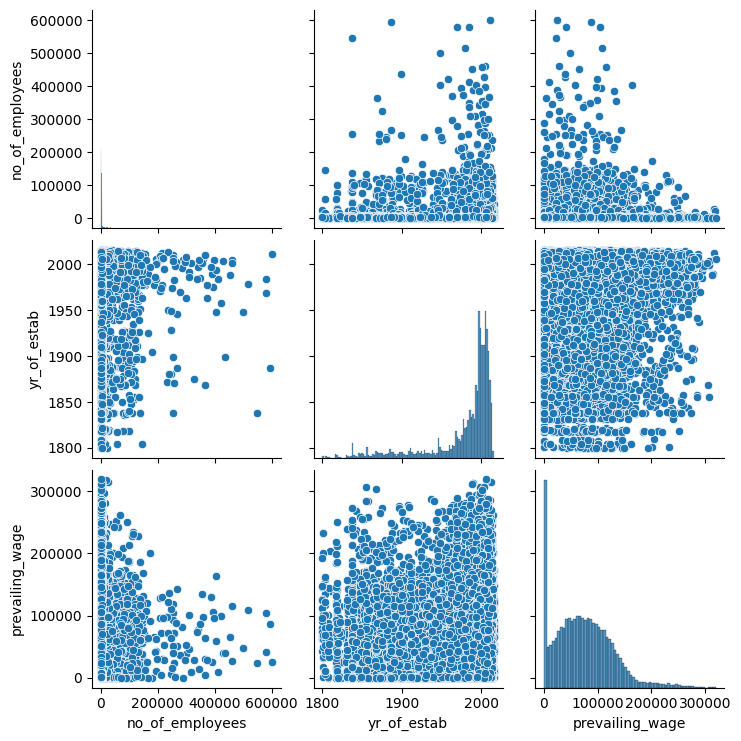

In [ ]:
sns.pairplot(df)

In [ ]:
def create_boxplot(data, numeric_features,y=None, hue=None):
    columns = 2
    rows = int(np.ceil(len(numeric_features) / columns))

    fig, axes = plt.subplots(rows, columns, figsize=(14, 5 * rows))
    axes = axes.flatten()  # Make it easier to index
    legend_labels = None

    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        plot = sns.boxplot(data=data, x=feature,y=y, hue=hue, ax=ax)
        ax.set_title(f"Boxplot for {feature}")

        # Store legend info from first plot only
        if i == 0 and hue:
            handles, labels = ax.get_legend_handles_labels()
            legend_labels = (handles, labels)

        # Remove legend from all but the first subplot
        if hue:
            ax.legend_.remove()

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add the legend at the top center
    if legend_labels:
        fig.legend(*legend_labels, loc='upper center', ncol=len(legend_labels[1]), fontsize='medium')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space at top for legend
    plt.show()


In [ ]:
def create_histplot(data, numeric_features, hue=None):
    """
    Safely plots histograms for numeric features, one per subplot, colored by hue.
    """

    # Filter only valid numeric columns
    valid_features = [col for col in numeric_features if col in data.columns and pd.api.types.is_numeric_dtype(data[col])]

    if len(valid_features) == 0:
        print("No valid numeric features found.")
        return

    columns = 2
    rows = int(np.ceil(len(valid_features) / columns))

    fig, axes = plt.subplots(rows, columns, figsize=(14, 5 * rows))
    axes = axes.flatten()
    legend_labels = None

    for i, feature in enumerate(valid_features):
        ax = axes[i]
        try:
            sns.histplot(data=data, x=feature, hue=hue, ax=ax, bins=30, kde=False)
            ax.set_title(f"Distribution for {feature}")

            # Save legend from first plot
            if i == 0 and hue:
                handles, labels = ax.get_legend_handles_labels()
                legend_labels = (handles, labels)

            # Remove legend from other plots
            if hue and ax.get_legend():
                ax.get_legend().remove()

        except Exception as e:
            ax.text(0.5, 0.5, f"Error plotting {feature}\n{str(e)}", ha='center')
            print(f"Skipped feature '{feature}' due to error: {e}")

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Shared legend
    if legend_labels:
        fig.legend(*legend_labels, loc='upper center', ncol=len(legend_labels[1]), fontsize='medium')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

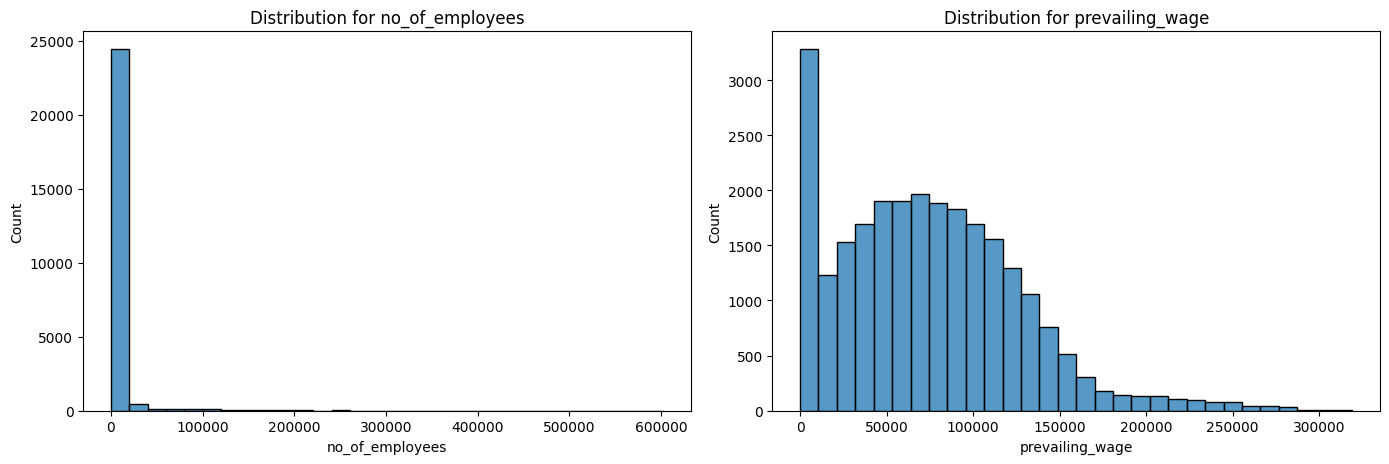

In [ ]:
create_histplot(data=df,numeric_features = num_columns)

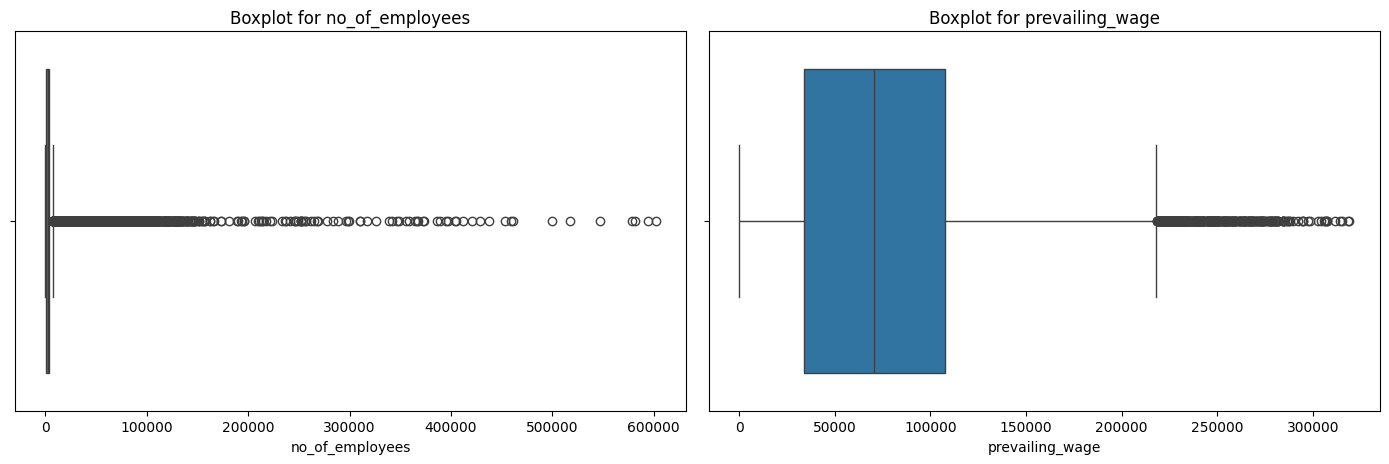

In [ ]:
create_boxplot(data=df,numeric_features = num_columns)

<Axes: xlabel='case_status', ylabel='count'>

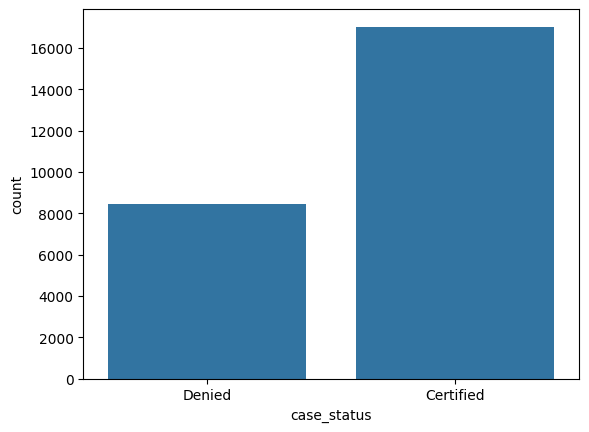

In [ ]:
sns.countplot(data=df,x="case_status")

In [ ]:
len(df.yr_of_estab.unique())

199

In [ ]:
df.yr_of_estab.value_counts().head(50)

yr_of_estab
1998    1134
2005    1051
2001    1017
2007     994
1999     870
2004     846
2006     844
2000     806
1997     761
2010     743
2008     674
2009     640
2003     614
2013     533
2011     518
2012     492
1994     474
1996     466
1993     464
2002     435
1995     392
1989     383
1984     328
1977     319
1985     315
1986     304
1968     302
1987     295
1992     257
1981     256
1991     243
1988     233
1979     213
1990     184
1978     182
2014     175
1980     171
1983     160
1838     157
1969     157
1975     149
1976     146
1971     140
1982     135
1963     129
1946     128
1947     128
1974     123
1855     120
1962     114
Name: count, dtype: int64

In [ ]:
df["company_age"] = dt.datetime.now().year - df.yr_of_estab.astype(int)

In [ ]:
df.company_age.describe()

count    25480.000000
mean        45.590071
std         42.366929
min          9.000000
25%         20.000000
50%         28.000000
75%         49.000000
max        225.000000
Name: company_age, dtype: float64

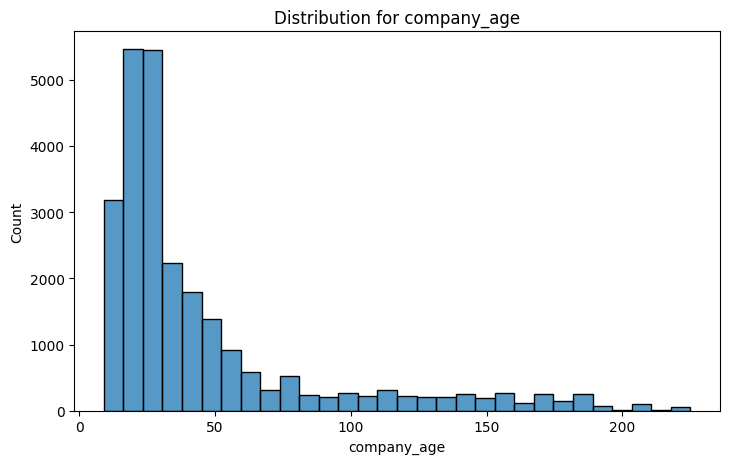

In [ ]:
create_histplot(data=df, numeric_features = ["company_age"], hue=None)

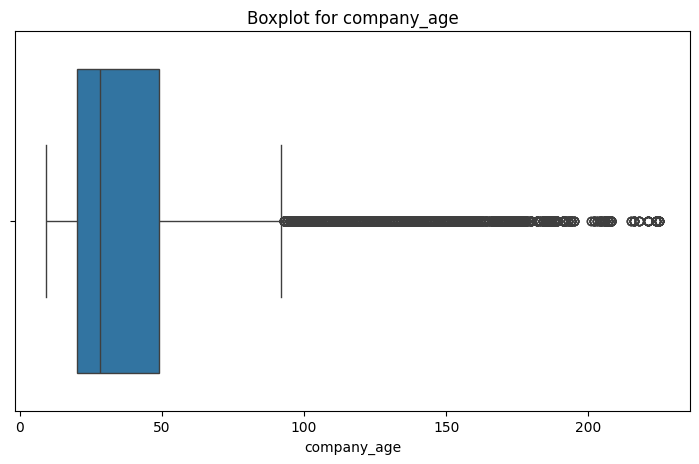

In [ ]:
create_boxplot(data=df, numeric_features = ["company_age"],y=None, hue=None)

In [ ]:
num_columns = [col for col in df.select_dtypes(np.number).columns]
print("Updated Numeric Columns:",num_columns)

Updated Numeric Columns: ['no_of_employees', 'prevailing_wage', 'company_age']


In [ ]:
def create_countplot(data, categorical_features,y=None, hue=None):
    columns = 2
    rows = int(np.ceil(len(categorical_features) / columns))

    fig, axes = plt.subplots(rows, columns, figsize=(14, 5 * rows))
    axes = axes.flatten()
    legend_labels = None

    for i, feature in enumerate(categorical_features):
        ax = axes[i]
        plot = sns.countplot(data=data, x=feature,y=None, hue=hue, ax=ax)
        ax.set_title(f"Count Plot for '{feature}'")

        # Add bar labels
        for p in plot.patches:
            height = p.get_height()
            plot.annotate(f'{int(height)}',
                          (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                          textcoords='offset points')

        # Store legend from the first subplot
        if i == 0 and hue:
            handles, labels = ax.get_legend_handles_labels()
            legend_labels = (handles, labels)

        # Remove legend from all but the first
        if hue and ax.get_legend():
            ax.get_legend().remove()

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Global legend
    if legend_labels:
        fig.legend(*legend_labels, loc='upper center', ncol=len(legend_labels[1]), fontsize='medium')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for legend at the top
    plt.show()


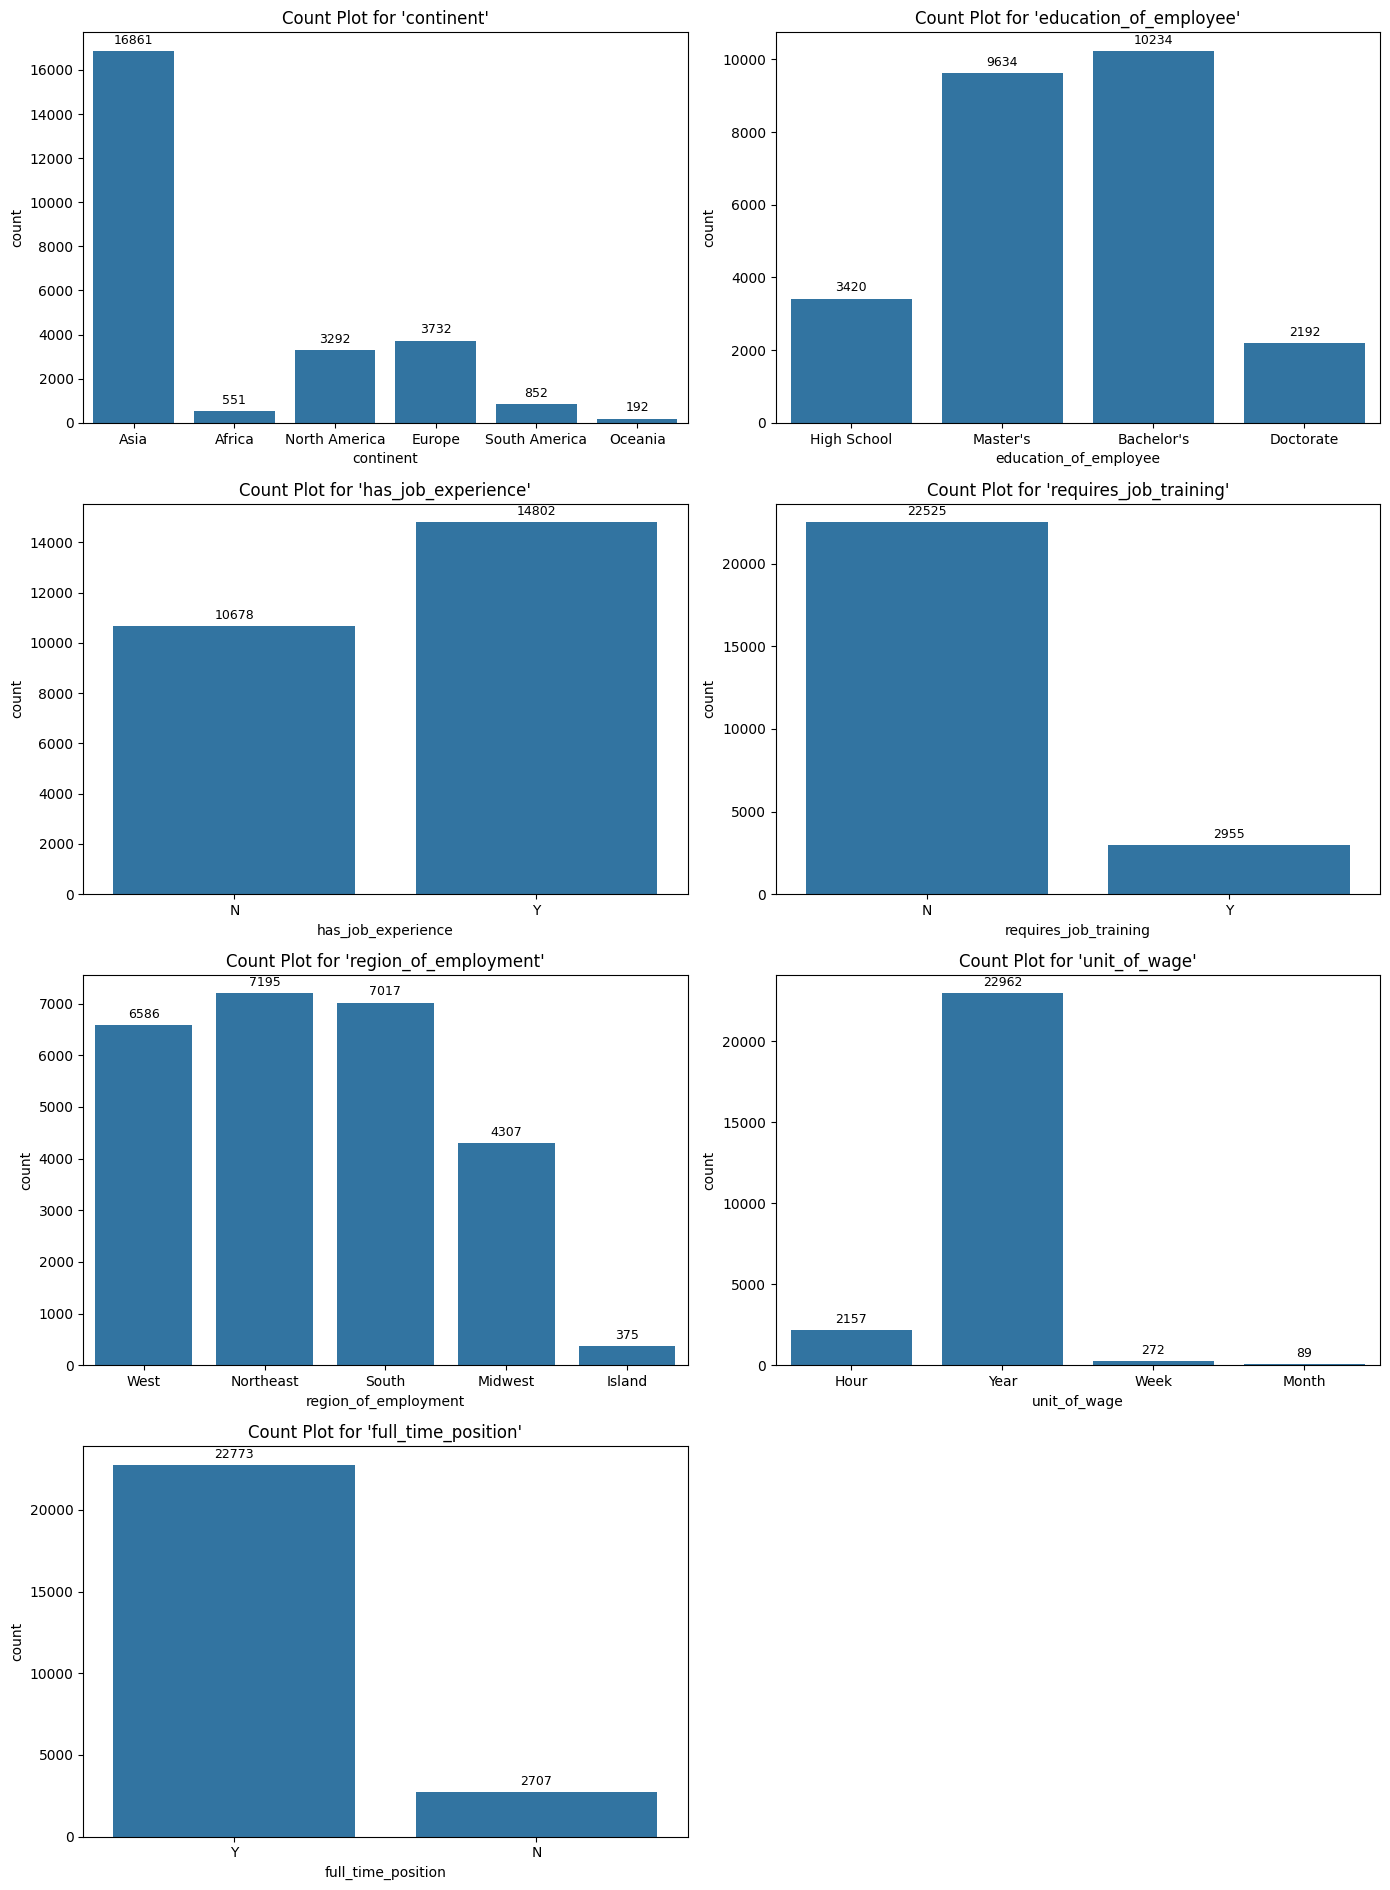

In [ ]:
create_countplot(data=df, categorical_features=['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position'],hue=None)

In [ ]:
display(df.case_status.value_counts(normalize=True)*100)
display(df.case_status.value_counts())

case_status
Certified    66.789639
Denied       33.210361
Name: proportion, dtype: float64

case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

#### Key Observations:

In terms of **numeric variables**:
- prevailing wages, company age & no. of employees are heavily positively skewed due to presence of large outliers
- Making comments about the summarty statistics of prevailing wages would be challenging due to lack of information about whether the wages mentioned are already converted to yearly or not.
- Majority candidates are joining/working with companies with ~2100 employees (median).
- Most candidates were also joining/working with companies that were 28 years old (median)

In terms of **categorical variables**:
- of the 25.5K candidates, around 17K or 66.7% had their VISA application certified whereas 8.4K or ~33.3 had it denied
- Almost 16.6K of the 25K candidates were from Asia (64%); Amongst the remaining - Europe (3.7K) and North America (3.2K) had the most candidates
- 78% of candidates had either a bachelors (39%) or masters (39%) degree.
- 58% of candidates had prior work experience
- 88% of applicants didn't require training, implying they received training through previous employement experience OR during their degree studies
- Northeast, South (28% each) & Midwest (26%) regions of U.S.A saw most applications for jobs
- Almost 90% applications coming in were for job with wages on yearly-basis contracts & full time positions

### **Bi-Variate Analysis**

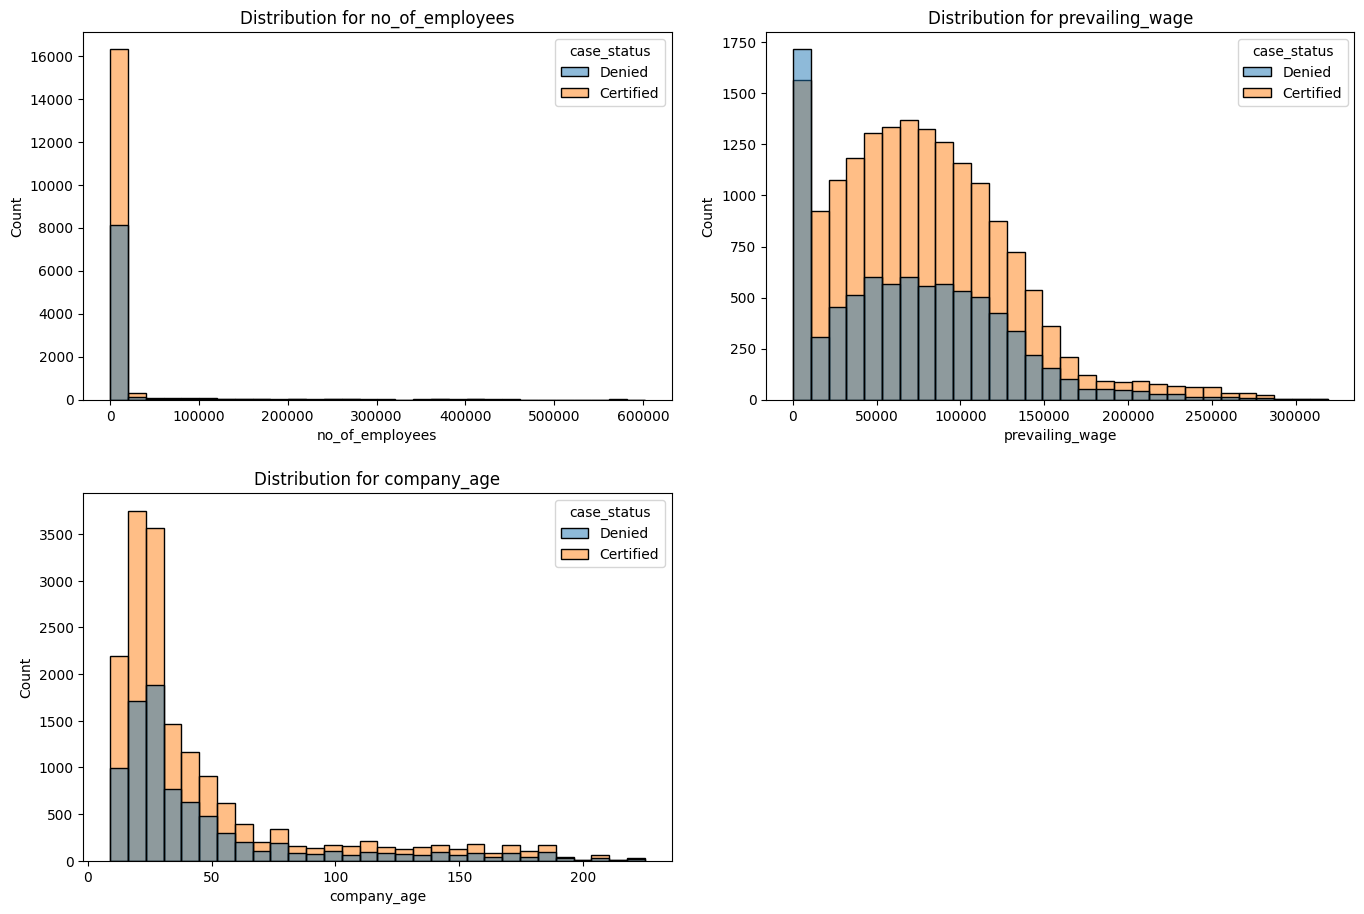

In [ ]:
columns = 2
rows = int(np.ceil(len(num_columns) / columns))

fig, axes = plt.subplots(rows, columns, figsize=(14, 5 * rows))
axes = axes.flatten()
legend_labels = None

for i, feature in enumerate(num_columns):
    ax = axes[i]
    sns.histplot(data=df, x=feature, hue="case_status", ax=ax, bins=30, kde=False)
    ax.set_title(f"Distribution for {feature}")

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95],pad=2)
plt.show()


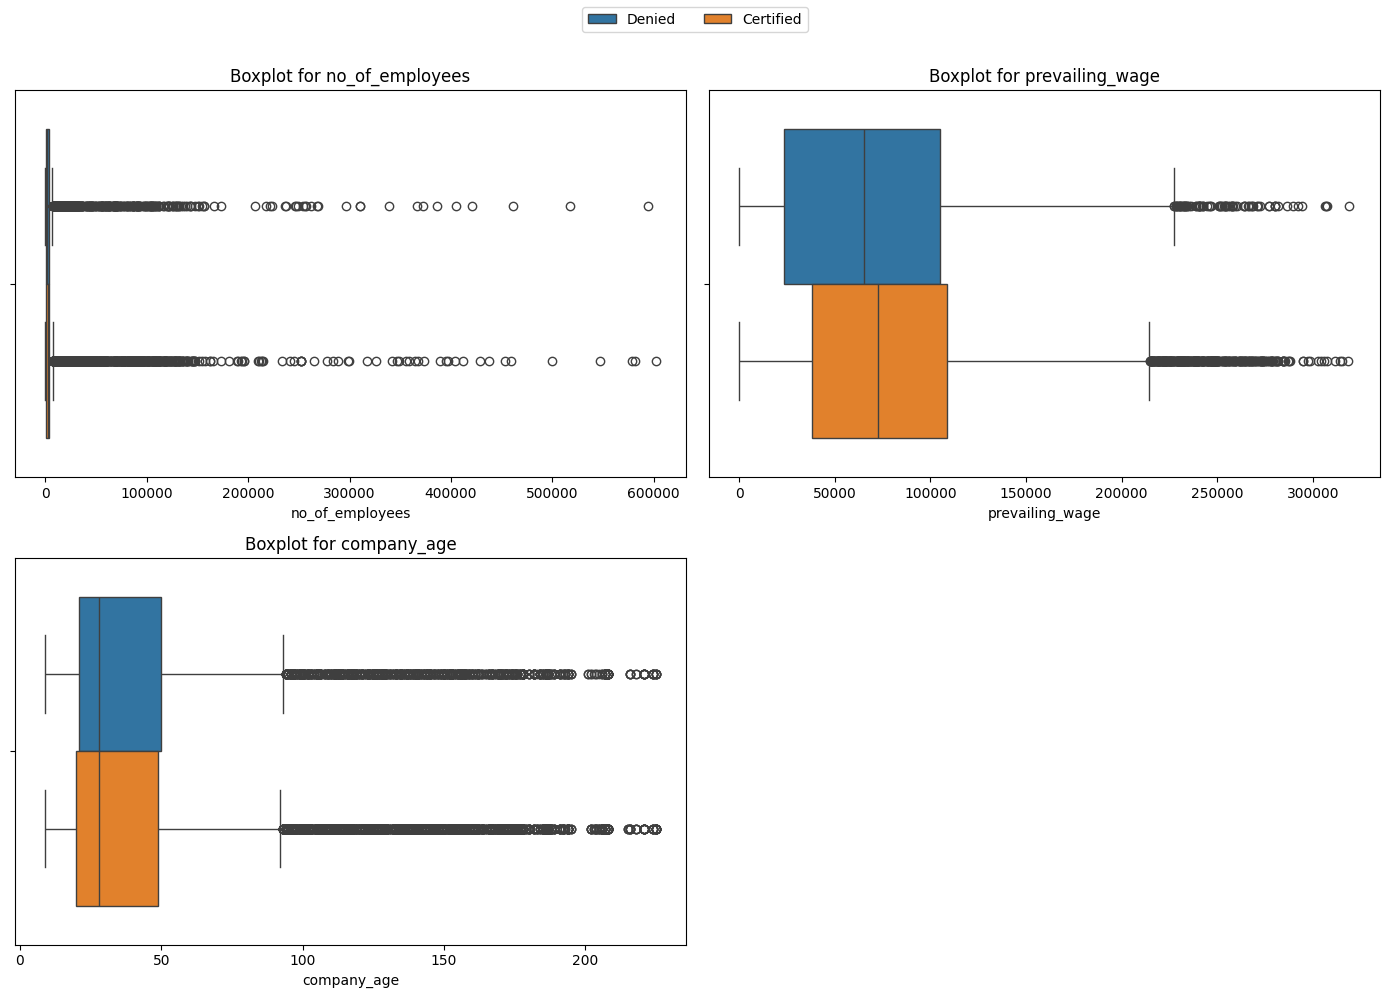

In [ ]:
create_boxplot(data=df,numeric_features = num_columns,y=None,hue="case_status")

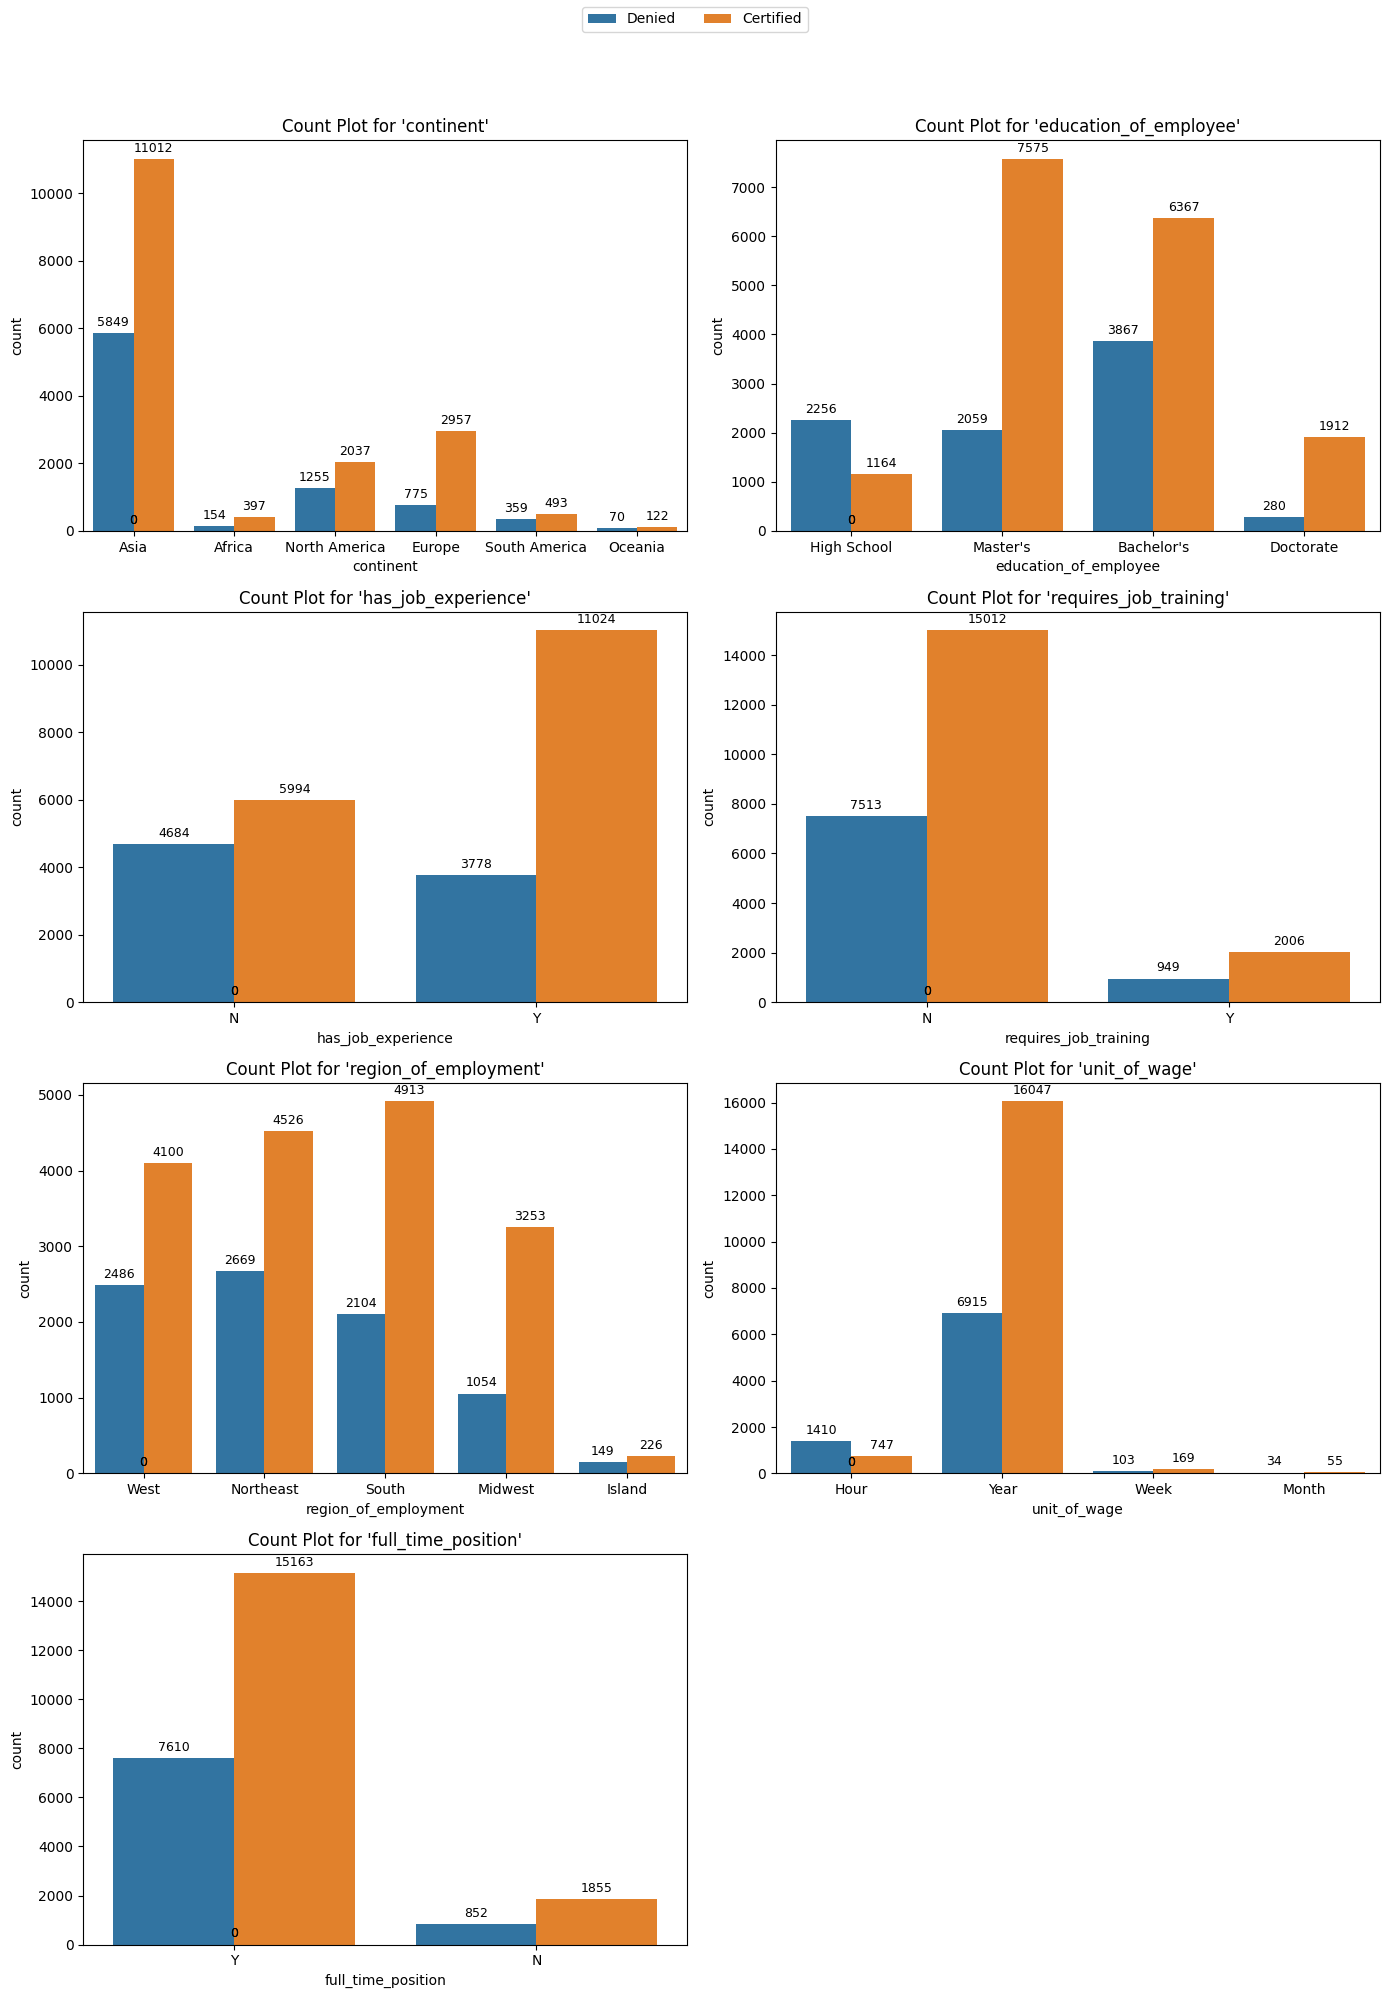

In [ ]:
create_countplot(data=df, categorical_features=['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position'],hue="case_status")

<Axes: ylabel='prevailing_wage'>

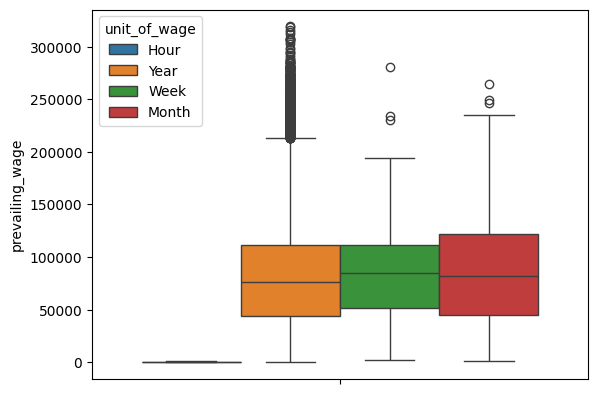

In [ ]:
sns.boxplot(data=df,y="prevailing_wage",hue="unit_of_wage")

#### Key Observations:

The objective of bi-variate analysis is to breakdown distributions of features by the target variables "case_status" to understand which features are highly correlated or contributing a specific certification denial or approval

In terms of **numeric variables**:
- It appears across cases of VISA approval or denial - all 3 numeric features i.e company age, no. of employees in company and prevailing wages have no significant difference in their mean/medians

In terms of **categorical variables**:
- **Based on employee's region, those from Asia had a 66% approval rate; European candidates had a 81% approval rate**
- Based on education, **its apparent that applicants with high school certifications have a higher denial rate.** As the eductional qualifications of the employee advanced from bachelors to master & doctorate, the rate of approval increase significantly from 63% to 86%
- Based on work experience, **it is visible that for those without prior experience, VISA approval changes are almost 50-50% whereas for those with prior work ex - VISA certification chances are about 75%**
- In terms of on-the job training requirement, it doesn't seem to have impact on VISA certification as irrespective of requirements, applicants's visa certification chances are high
- Excluding island regions, Applicants seeking opportunities in the south and midwest regions have previously seen higher than 70% approval rate (mid-west being the highest at 75%)
- Applying for full-time positions or not doesn't seem to impact the case status as 66% or more of the applicants got approval either way

### **Multivariate Analysis**

In [ ]:
pd.crosstab(df.education_of_employee,df.unit_of_wage,values=df.prevailing_wage,aggfunc="count")

unit_of_wage           Hour  Month  Week  Year
education_of_employee                         
Bachelor's              981     41   126  9086
Doctorate                96      5     8  2083
High School             395     13    32  2980
Master's                685     30   106  8813

In [ ]:
pd.crosstab(df.education_of_employee,df.unit_of_wage,values=df.prevailing_wage,aggfunc="mean")

unit_of_wage                 Hour         Month          Week          Year
education_of_employee                                                      
Bachelor's             412.734576  89444.425854  86766.191984  81028.687753
Doctorate              414.554718  60897.056000  76292.886250  67481.159102
High School            418.064771  82420.912308  85131.785312  80822.188171
Master's               415.187066  91752.876667  85075.045000  84820.047095

In [ ]:
print("Relationship b/w Prevailing Wages, Unit of Wage & Education Level\n")
for i in df.case_status.unique():
  case_status_df = df[df.case_status==i]
  print(f"\nCandidates with Visa status: {str(i).upper()}")
  display(pd.crosstab(case_status_df.education_of_employee,case_status_df.unit_of_wage,values=case_status_df.prevailing_wage,aggfunc="mean"))

Relationship b/w Prevailing Wages, Unit of Wage & Education Level


Candidates with Visa status: DENIED


unit_of_wage                 Hour          Month          Week          Year
education_of_employee                                                       
Bachelor's             414.888182   73752.540667  88819.262642  81472.816829
Doctorate              417.760966   86778.040000  52803.065000  74786.972218
High School            405.453065  112415.902857  86032.127222  80217.367472
Master's               400.175003   92520.180000  79790.473000  87590.106091


Candidates with Visa status: CERTIFIED


unit_of_wage                 Hour         Month          Week          Year
education_of_employee                                                      
Bachelor's             407.315824  98497.436538  85275.606438  80799.022074
Doctorate              412.454072  54426.810000  84122.826667  66534.255992
High School            456.285960  47426.756667  83974.202857  81940.470421
Master's               433.134180  91308.648421  87161.060263  84184.340197

In [ ]:
print("Relationship b/w Prevailing Wages, Unit of Wage & Education Level\n")
for i in df.case_status.unique():
  case_status_df = df[df.case_status==i]
  print(f"\nCandidates with Visa status: {str(i).upper()}")
  display(pd.crosstab(case_status_df.education_of_employee,case_status_df.unit_of_wage,values=case_status_df.prevailing_wage,aggfunc="count"))

Relationship b/w Prevailing Wages, Unit of Wage & Education Level


Candidates with Visa status: DENIED


unit_of_wage           Hour  Month  Week  Year
education_of_employee                         
Bachelor's              702     15    53  3097
Doctorate                38      1     2   239
High School             297      7    18  1934
Master's                373     11    30  1645


Candidates with Visa status: CERTIFIED


unit_of_wage           Hour  Month  Week  Year
education_of_employee                         
Bachelor's              279     26    73  5989
Doctorate                58      4     6  1844
High School              98      6    14  1046
Master's                312     19    76  7168

In [ ]:
print("Relationship b/w Job Experience & On-The Job Training Requirement\n")
for i in df.case_status.unique():
  case_status_df = df[df.case_status==i]
  print(f"Candidates with Visa status: {str(i).upper()}")
  display(pd.crosstab(case_status_df.has_job_experience,case_status_df.requires_job_training))
  print("\n")

Relationship b/w Job Experience & On-The Job Training Requirement

Candidates with Visa status: DENIED


requires_job_training     N    Y
has_job_experience              
N                      4056  628
Y                      3457  321



Candidates with Visa status: CERTIFIED


requires_job_training      N     Y
has_job_experience                
N                       4932  1062
Y                      10080   944

In [ ]:
def create_pairwise_scatterplots(data, numeric_features, hue=None):
    """
    Creates scatterplots for all pairwise combinations of numeric features.

    Parameters:
        data (DataFrame): The dataset
        numeric_features (list): List of numeric feature column names
        hue (str): Column name for hue (e.g., target variable)
    """
    # Create all unique pairwise combinations
    combinations = list(itertools.combinations(numeric_features, 2))
    columns = 2
    rows = int(np.ceil(len(combinations) / columns))

    fig, axes = plt.subplots(rows, columns, figsize=(14, 5 * rows))
    axes = axes.flatten()

    for i, (x_feat, y_feat) in enumerate(combinations):
        ax = axes[i]
        sns.scatterplot(data=data, x=x_feat, y=y_feat, hue=hue, ax=ax, palette='Set1', alpha=0.6)
        ax.set_title(f"{y_feat} vs. {x_feat}")
        ax.legend(loc='best')

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

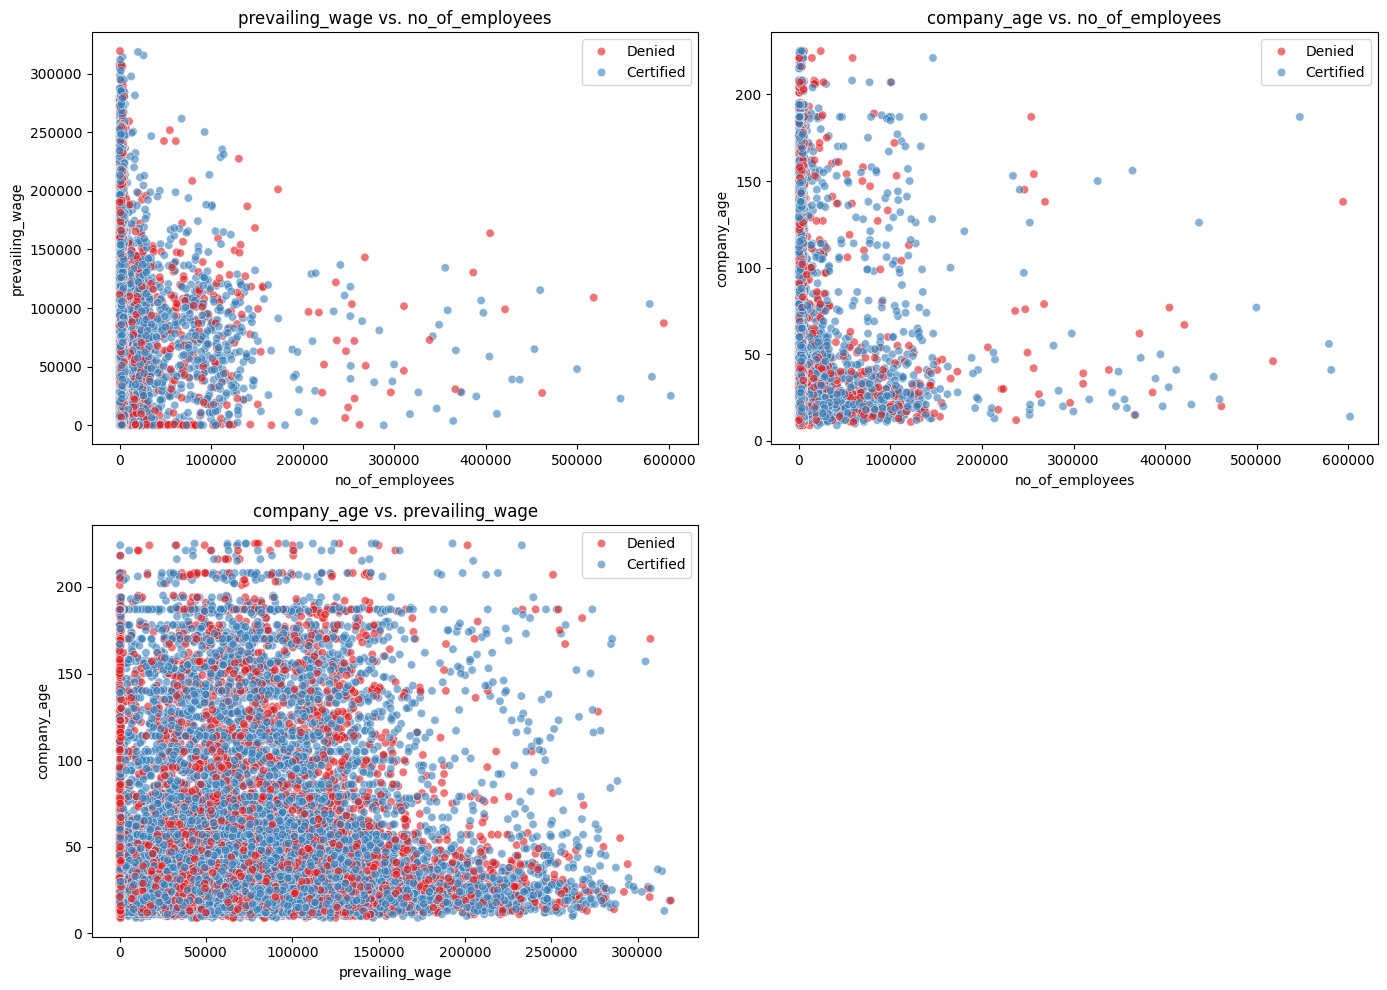

In [ ]:
create_pairwise_scatterplots(data=df, numeric_features=num_columns, hue='case_status')

In [ ]:
def create_faceted_countplots(data, categorical_features, target):
    """
    Creates countplots grouped by categorical feature pairs, with consistent hue order,
    fixed colors, bar labels, alphabetical ordering on x-axis, and spacing above bars.
    """
    warnings.filterwarnings('ignore')  # Suppress warnings

    # Define fixed target class order
    target_order = ['Certified', 'Denied']  # Adjust to match your dataset

    # Define fixed color palette
    palette_colors = sns.color_palette('Set2', len(target_order))
    fixed_palette = dict(zip(target_order, palette_colors))

    combinations = list(itertools.combinations(categorical_features, 2))

    for cat1, cat2 in combinations:
        unique_vals = data[cat2].dropna().unique()
        n = len(unique_vals)

        columns = 3
        rows = int(np.ceil(n / columns))

        fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
        axes = axes.flatten()

        fig.suptitle(f"Relationship Between '{cat1}' and Target, Separated by '{cat2}'", fontsize=16, fontweight='bold')
        fig.subplots_adjust(top=0.88)

        # Determine alphabetical order for x-axis categories (cat1)
        x_order = sorted(data[cat1].dropna().unique())

        for i, val in enumerate(unique_vals):
            subset = data[data[cat2] == val]
            ax = axes[i]

            plot = sns.countplot(
                data=subset,
                x=cat1,
                hue=target,
                order=x_order,
                hue_order=target_order,
                ax=ax,
                palette=fixed_palette
            )

            ax.set_title(f"{cat2}: {val}", fontsize=11)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

            # Add bar labels and manage spacing
            max_height = 0
            for container in ax.containers:
                ax.bar_label(container, fmt='%d', padding=3)
                heights = [patch.get_height() for patch in container]
                if heights:
                    max_height = max(max_height, max(heights))

            ax.set_ylim(top=max_height * 1.15)

            # Add border for clarity
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.2)

        # Remove unused axes
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


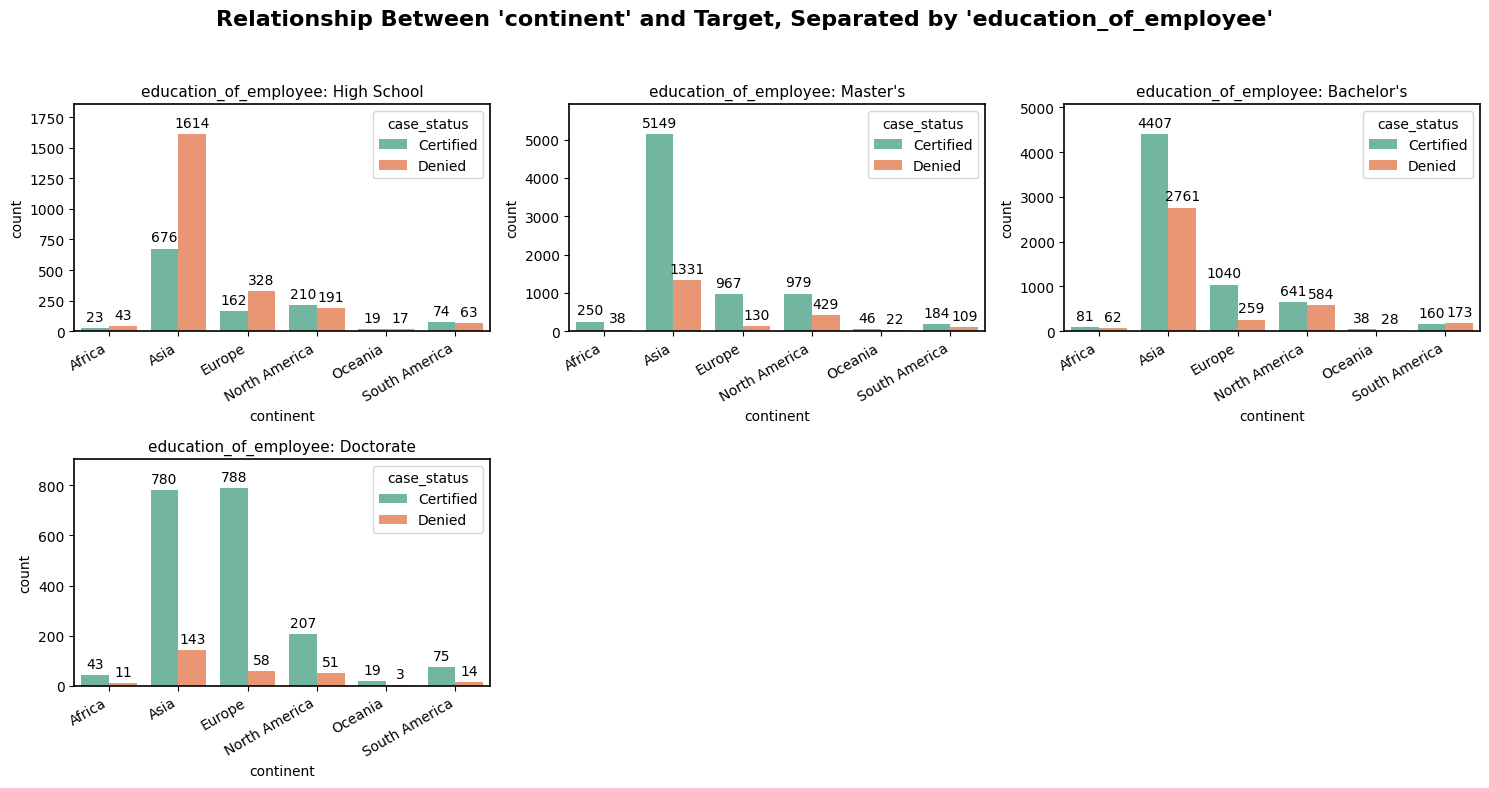

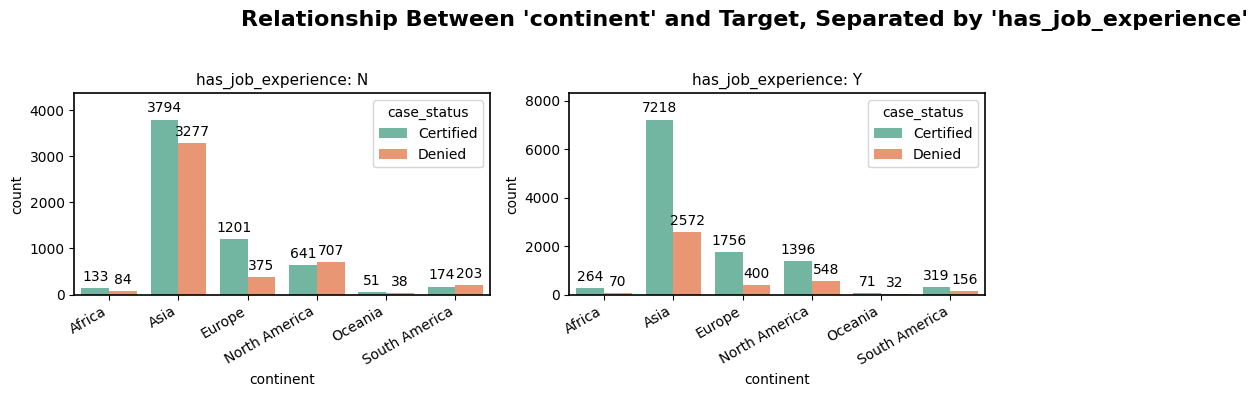

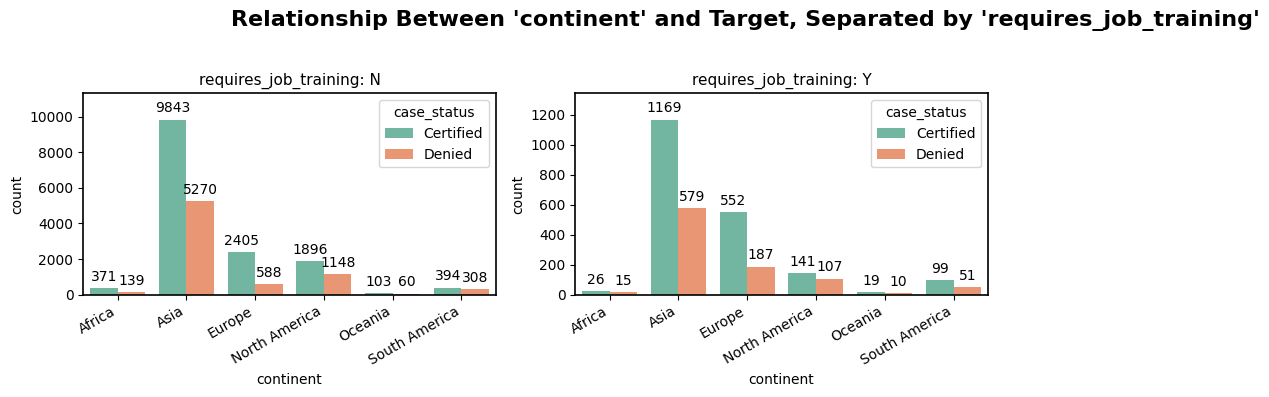

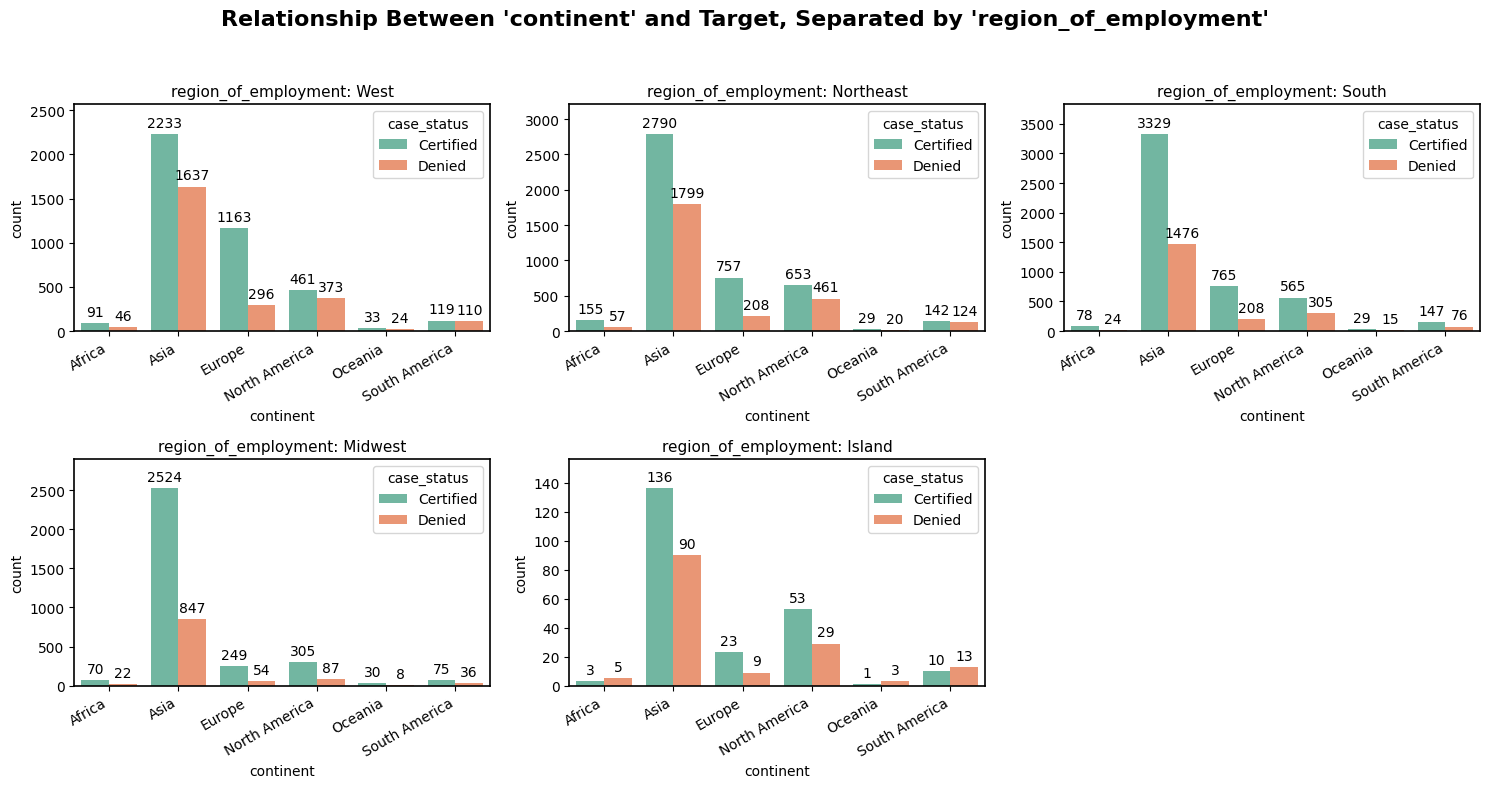

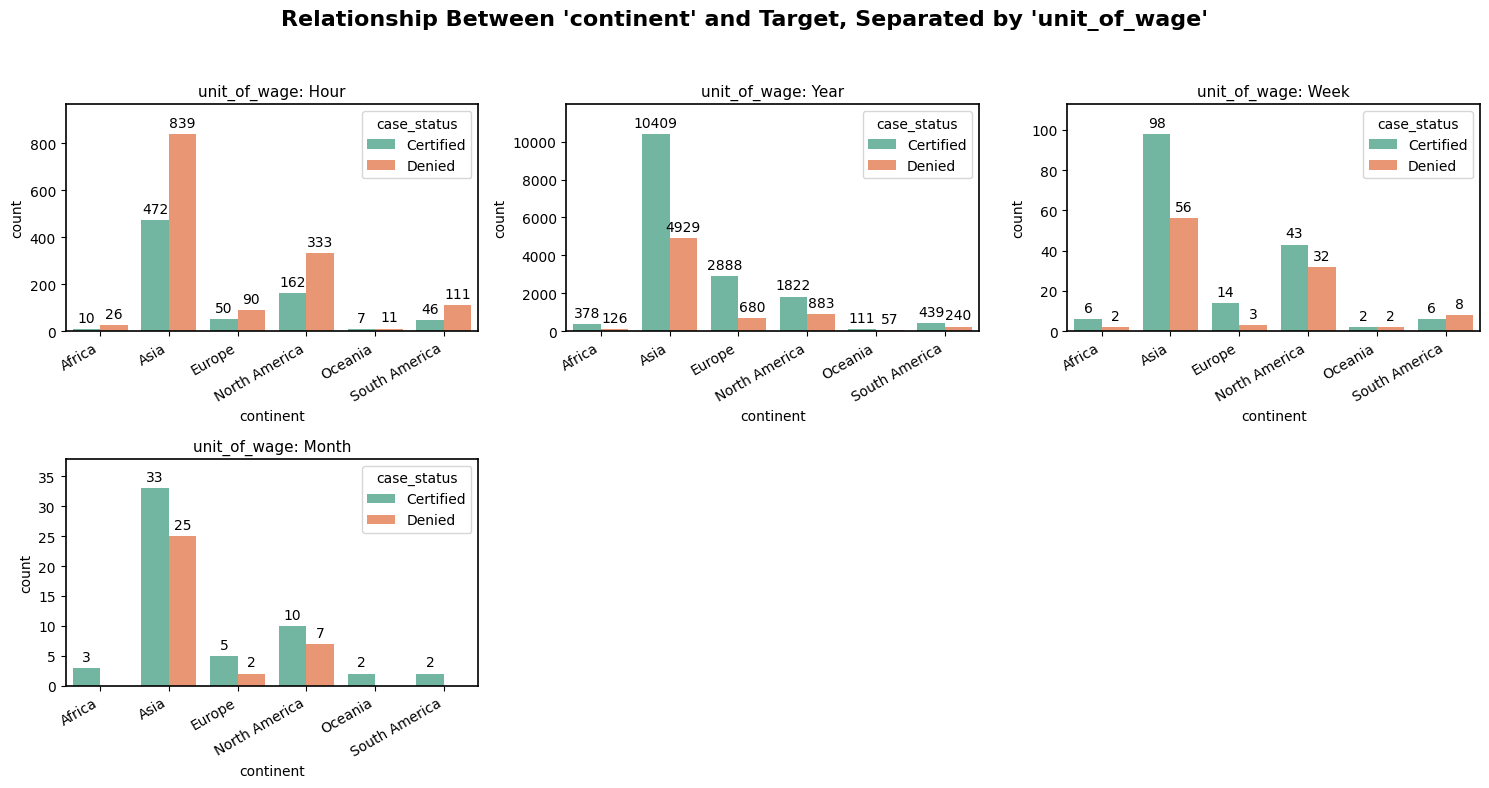

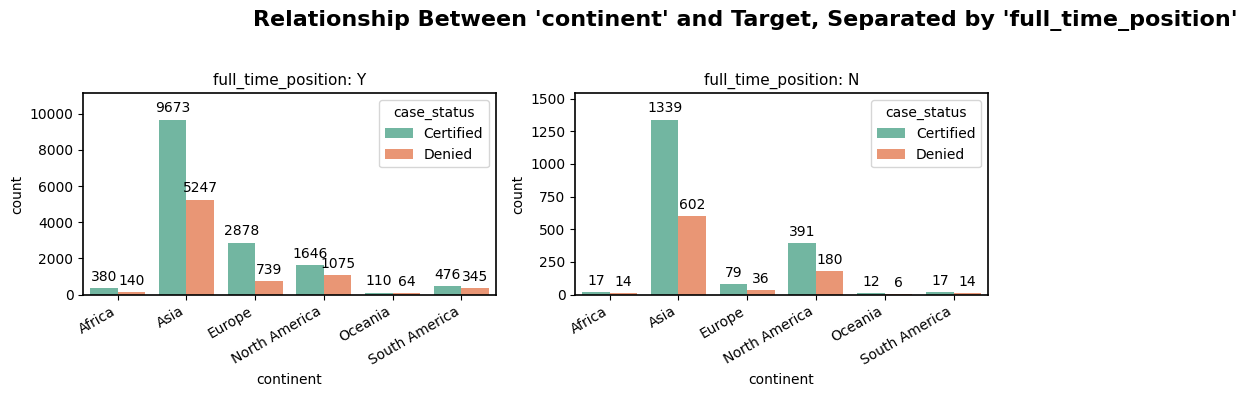

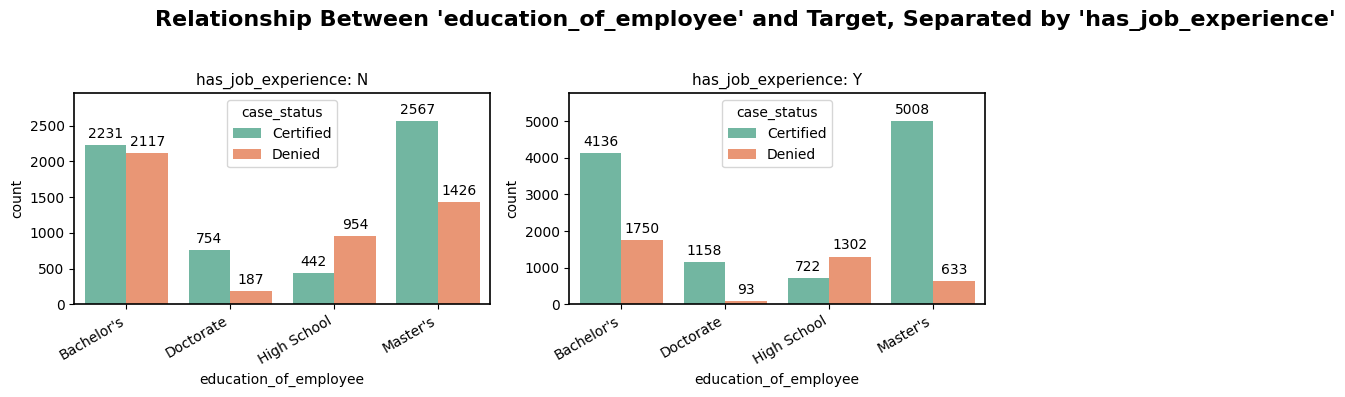

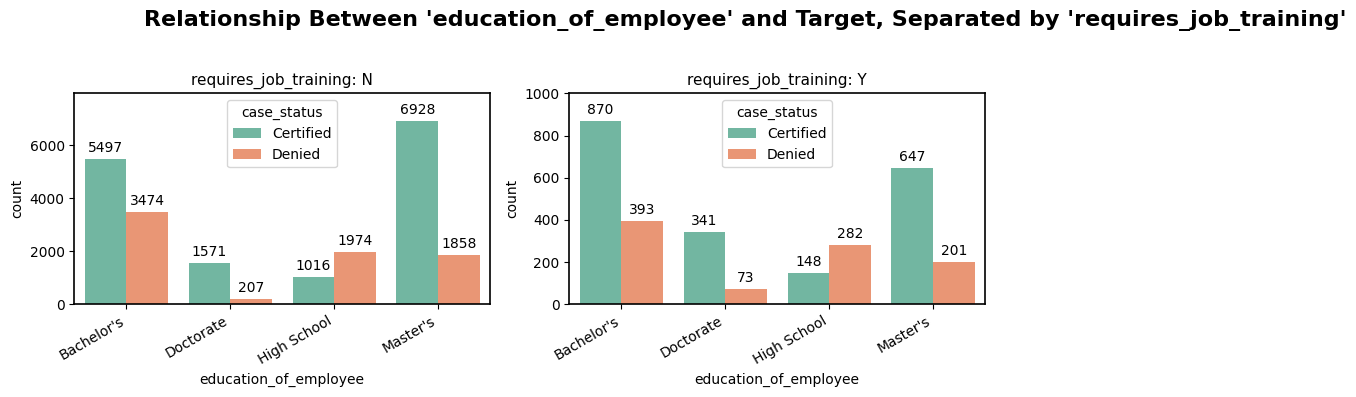

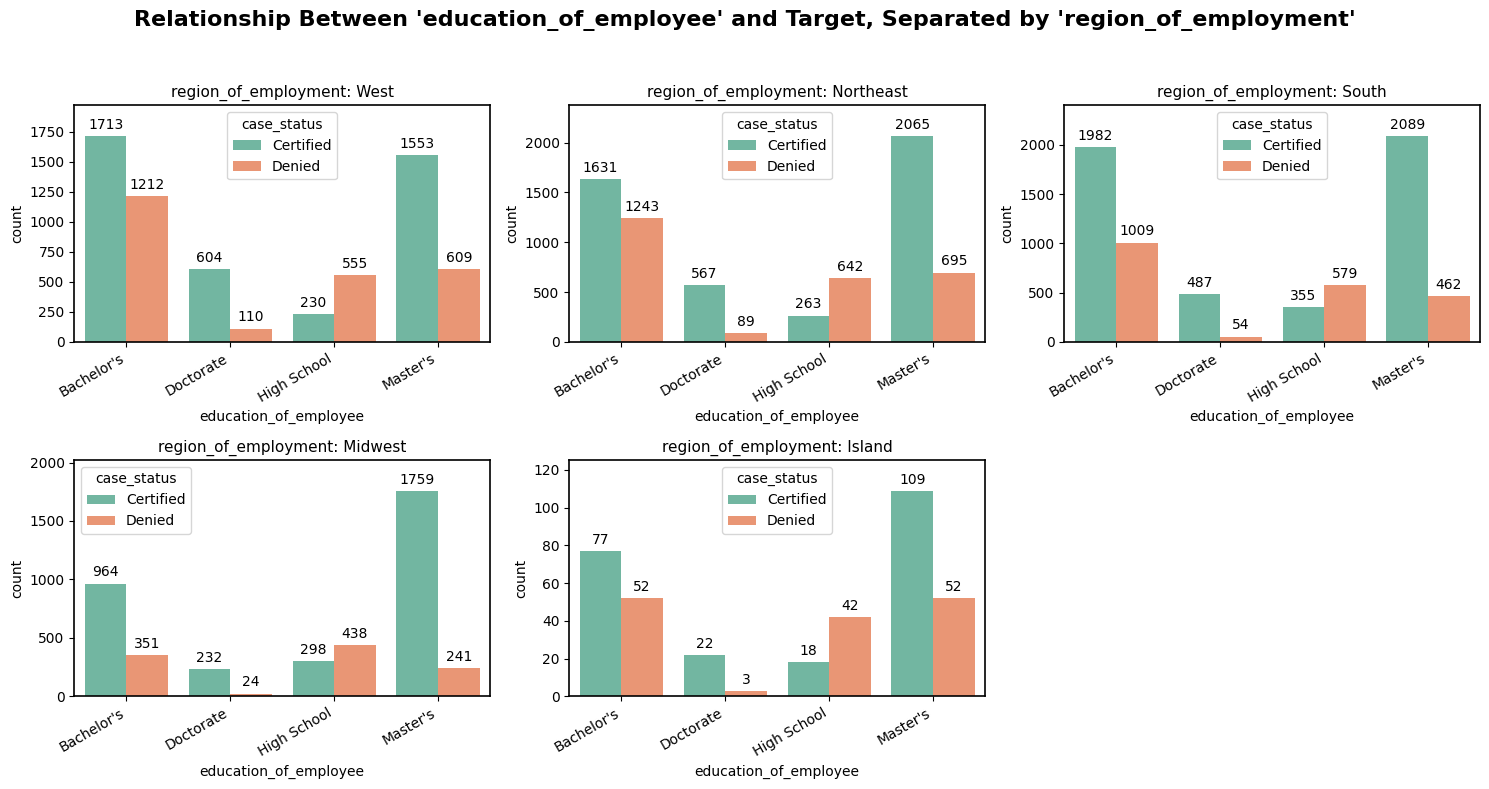

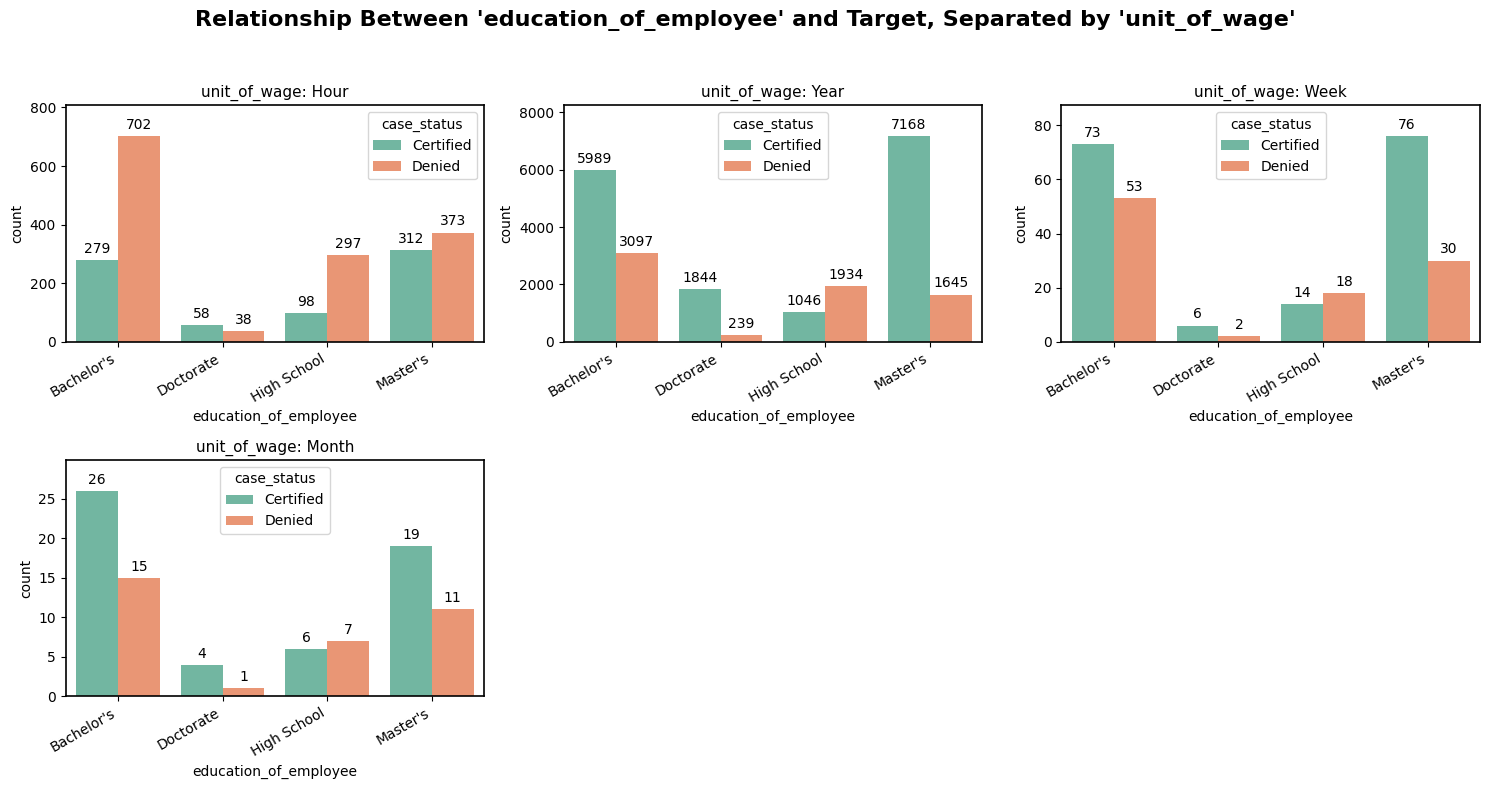

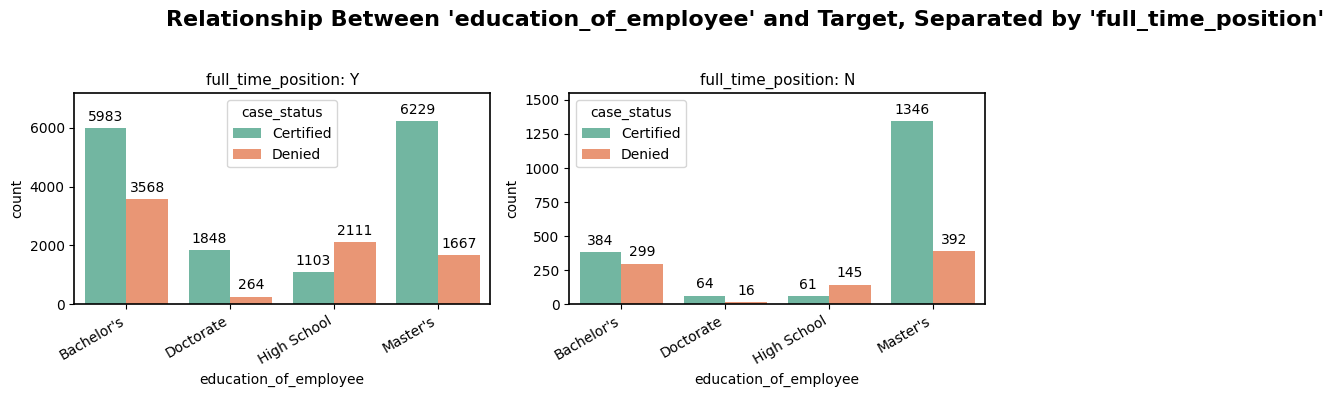

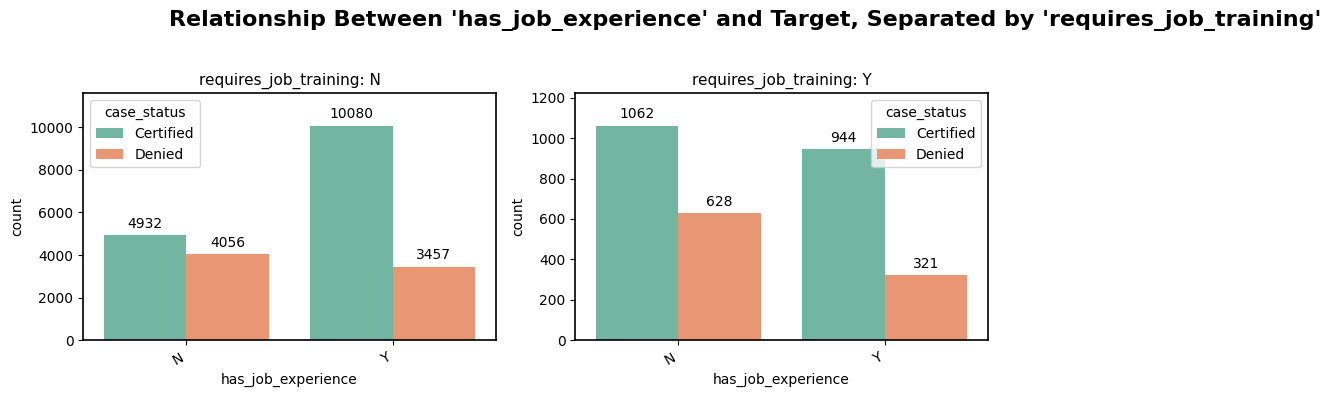

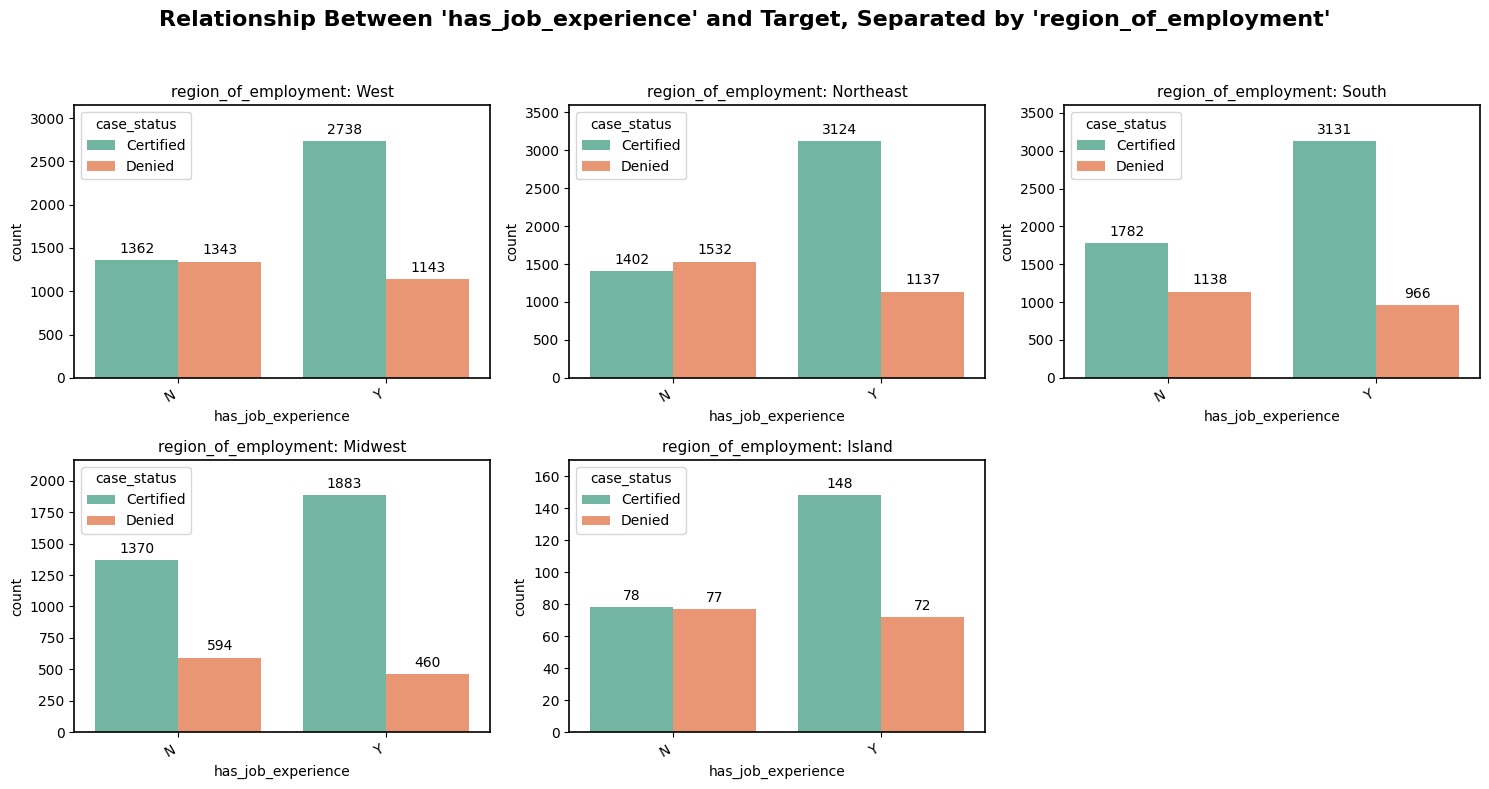

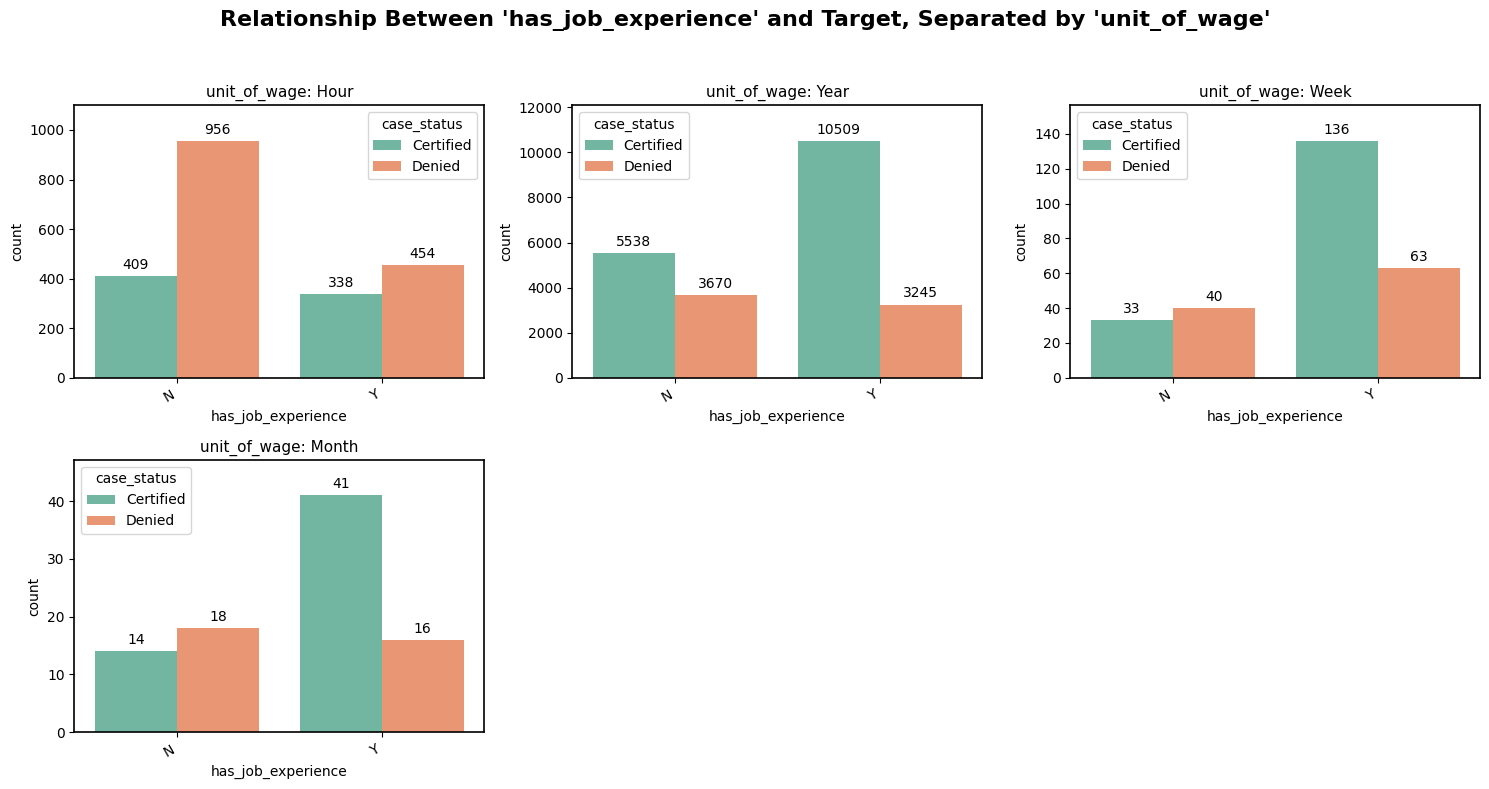

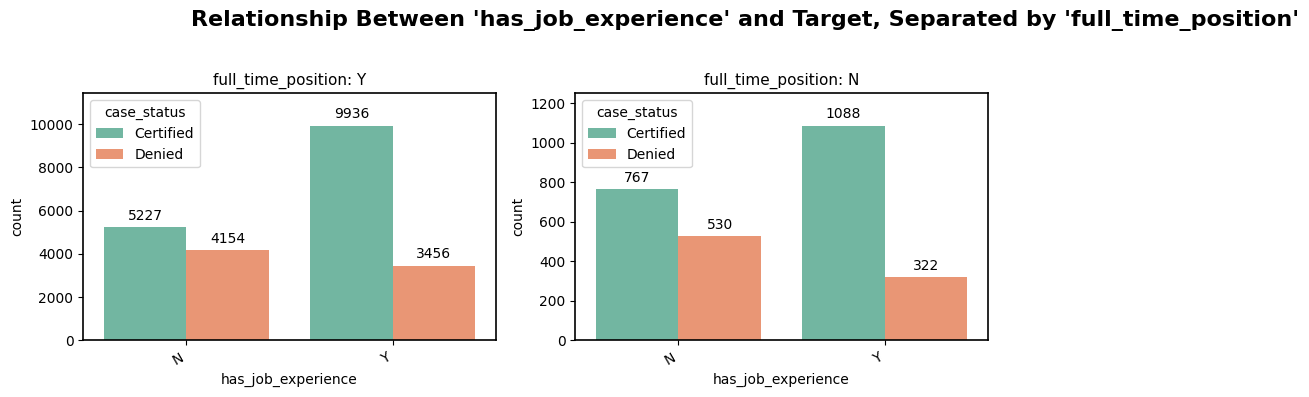

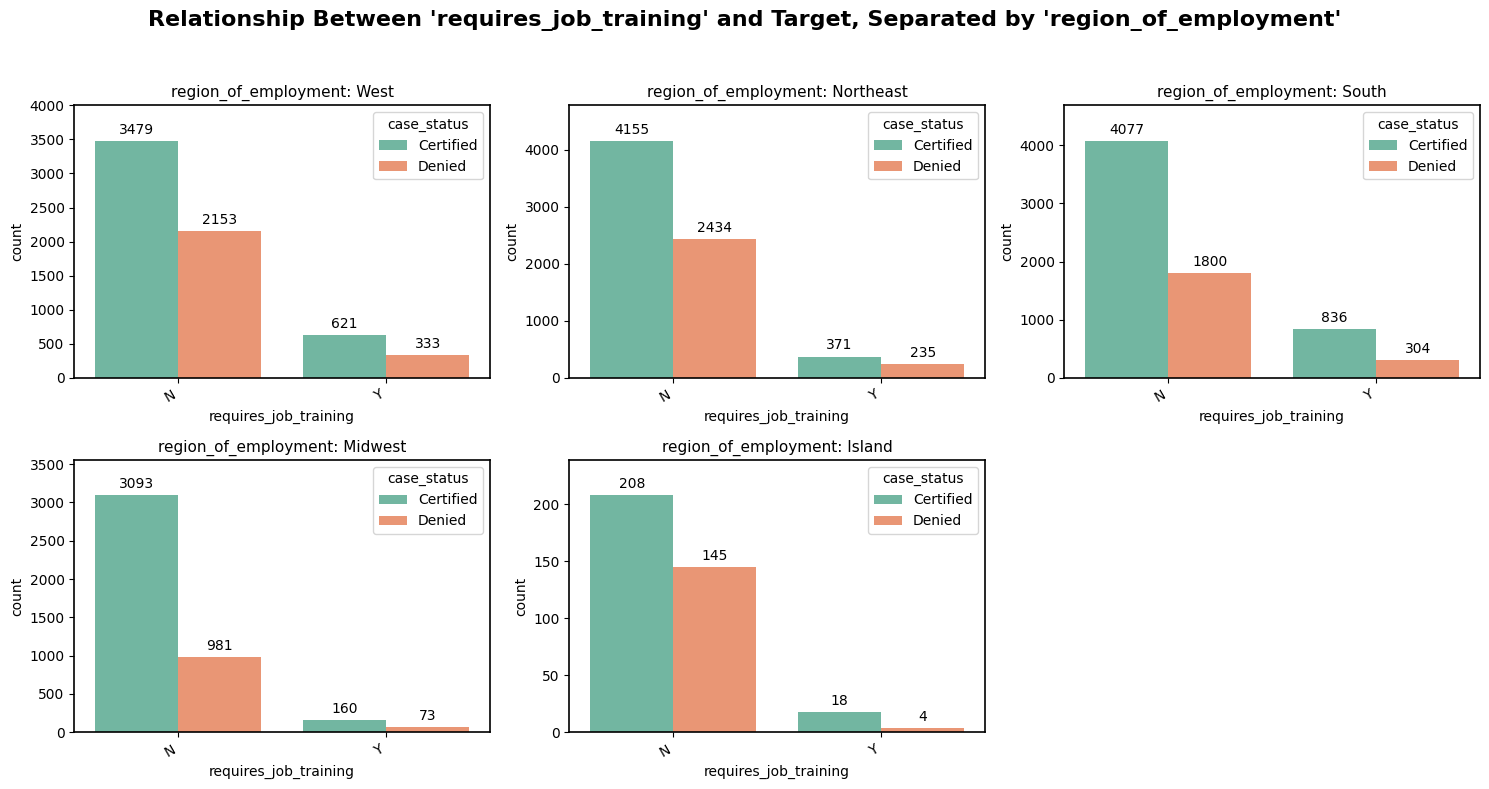

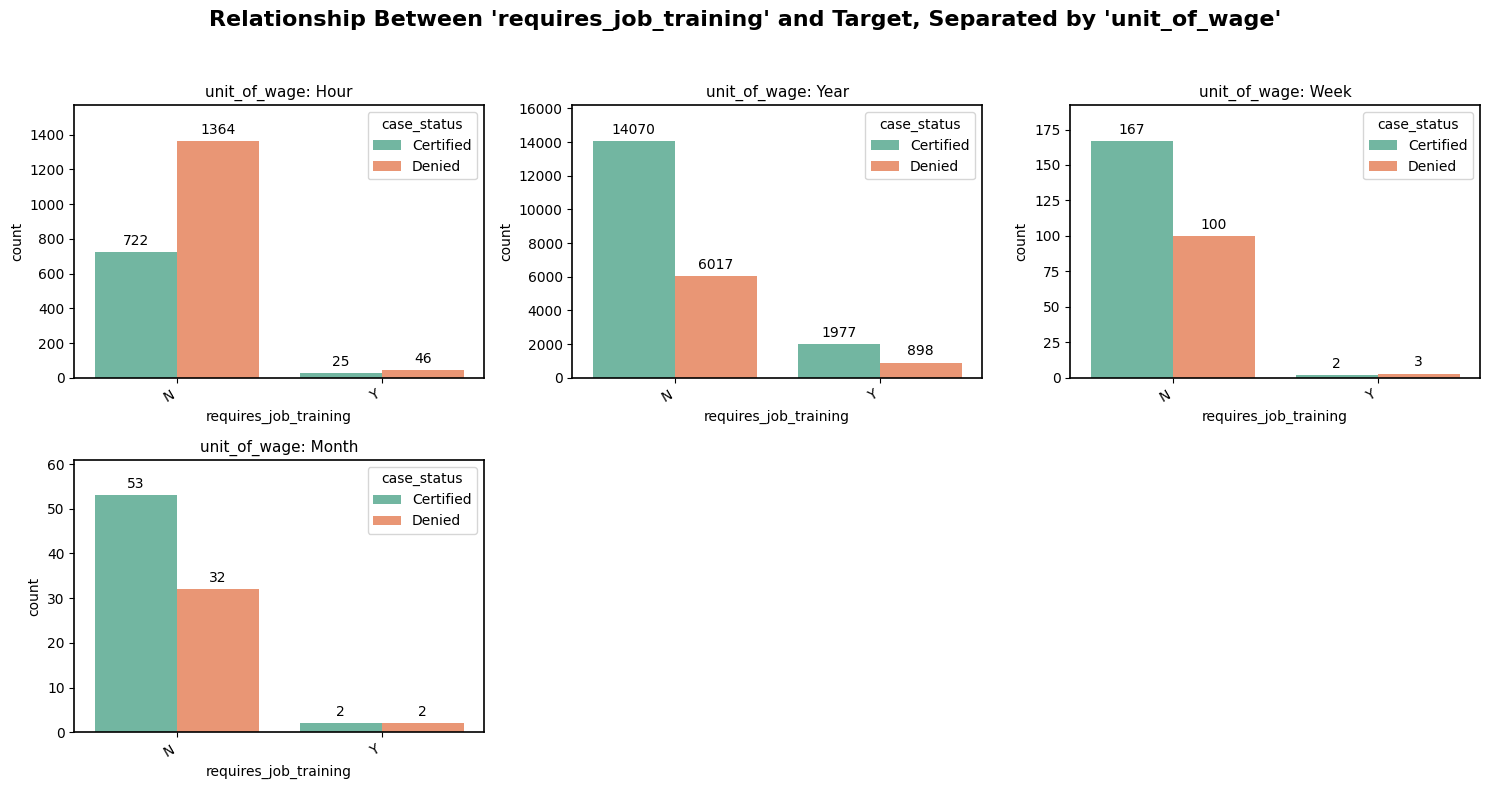

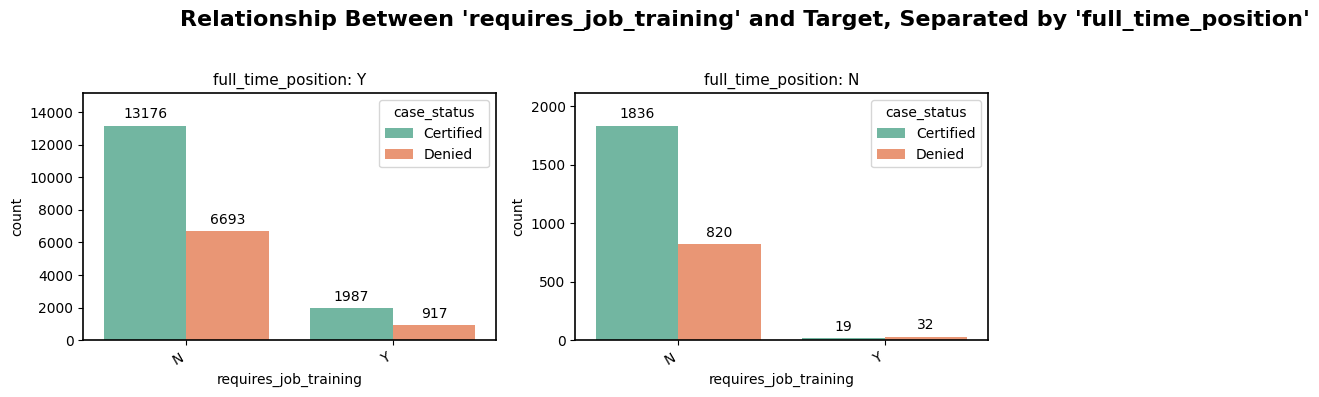

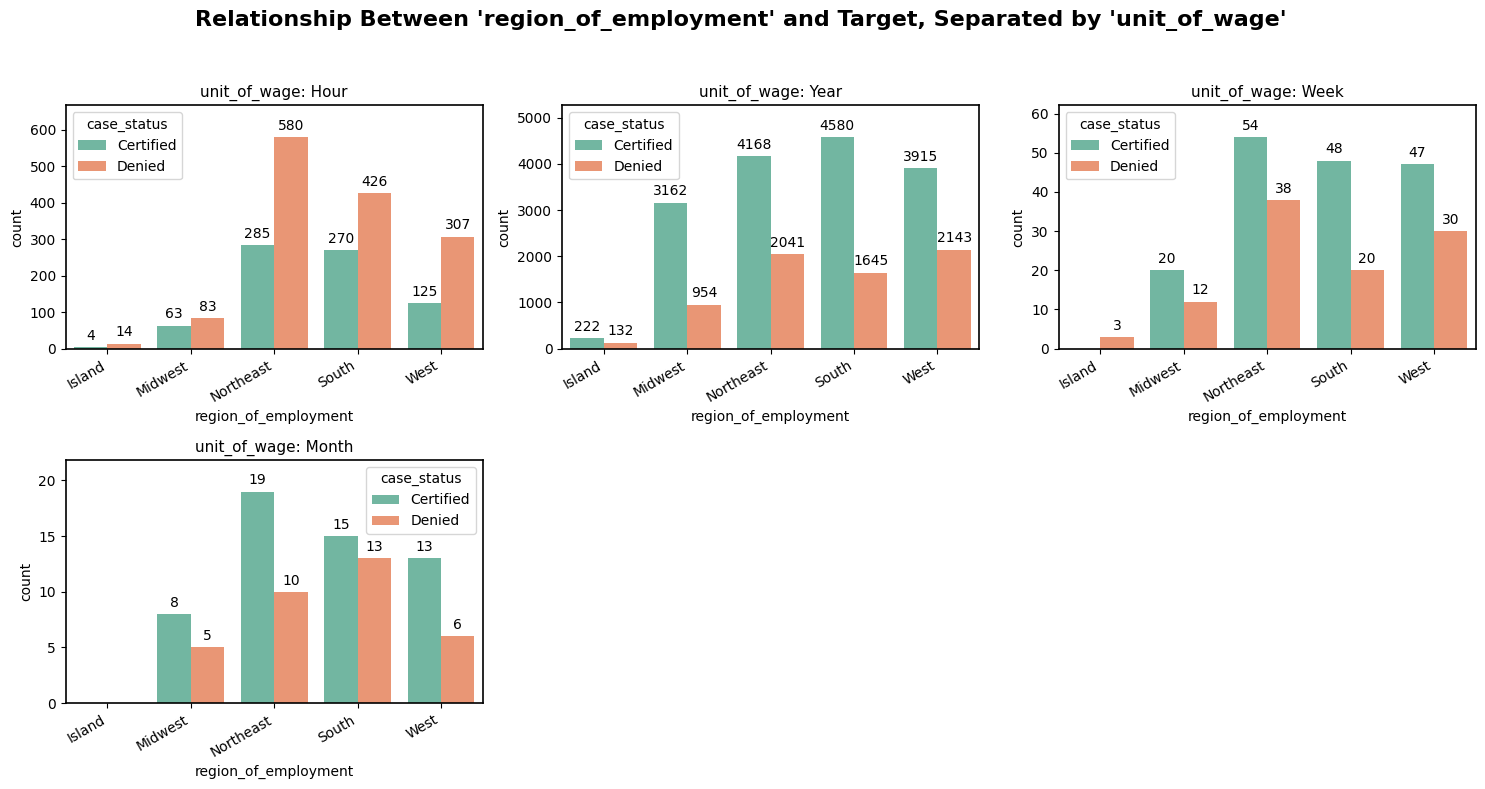

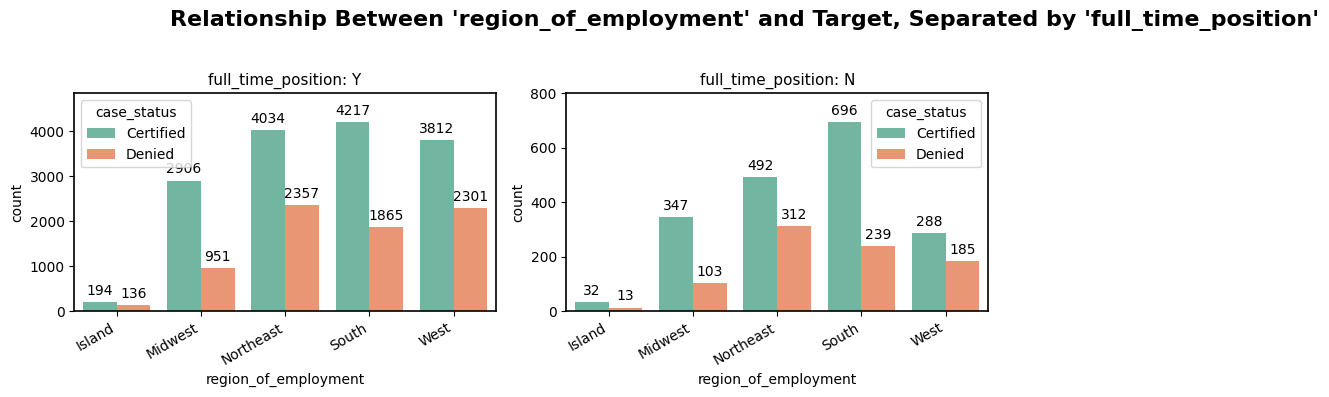

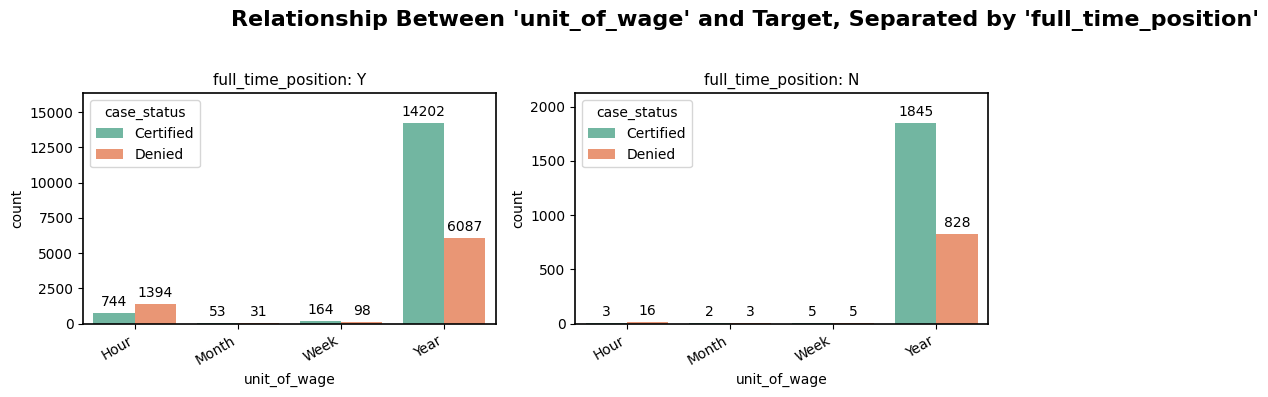

In [ ]:
cat_cols_upd = ['continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position']
create_faceted_countplots(data=df, categorical_features=cat_cols_upd, target='case_status')

In [ ]:
def create_numeric_boxplots_by_category(data, numeric_features, categorical_features, target):
    """
    For each numeric + categorical feature pair, creates boxplots of numeric distribution,
    broken down by target class, and faceted by values of the categorical feature.
    """
    warnings.filterwarnings('ignore')

    # Define consistent target class order and colors
    target_order = ['Certified', 'Denied']  # Update based on your dataset
    palette_colors = sns.color_palette('Set2', len(target_order))
    fixed_palette = dict(zip(target_order, palette_colors))

    for num_col, cat_col in itertools.product(numeric_features, categorical_features):
        unique_vals = data[cat_col].dropna().unique()
        n = len(unique_vals)
        columns = 3
        rows = int(np.ceil(n / columns))

        fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
        axes = axes.flatten()

        fig.suptitle(f"Boxplot of '{num_col}' by '{target}', Faceted by '{cat_col}'", fontsize=16, fontweight='bold')
        fig.subplots_adjust(top=0.88)

        for i, val in enumerate(unique_vals):
            subset = data[data[cat_col] == val]
            ax = axes[i]

            sns.boxplot(
                data=subset,
                x=target,
                y=num_col,
                order=target_order,
                palette=fixed_palette,
                ax=ax
            )

            ax.set_title(f"{cat_col}: {val}", fontsize=11)
            ax.set_xlabel(target)
            ax.set_ylabel(num_col)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

            # Add border around each subplot
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.2)

        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


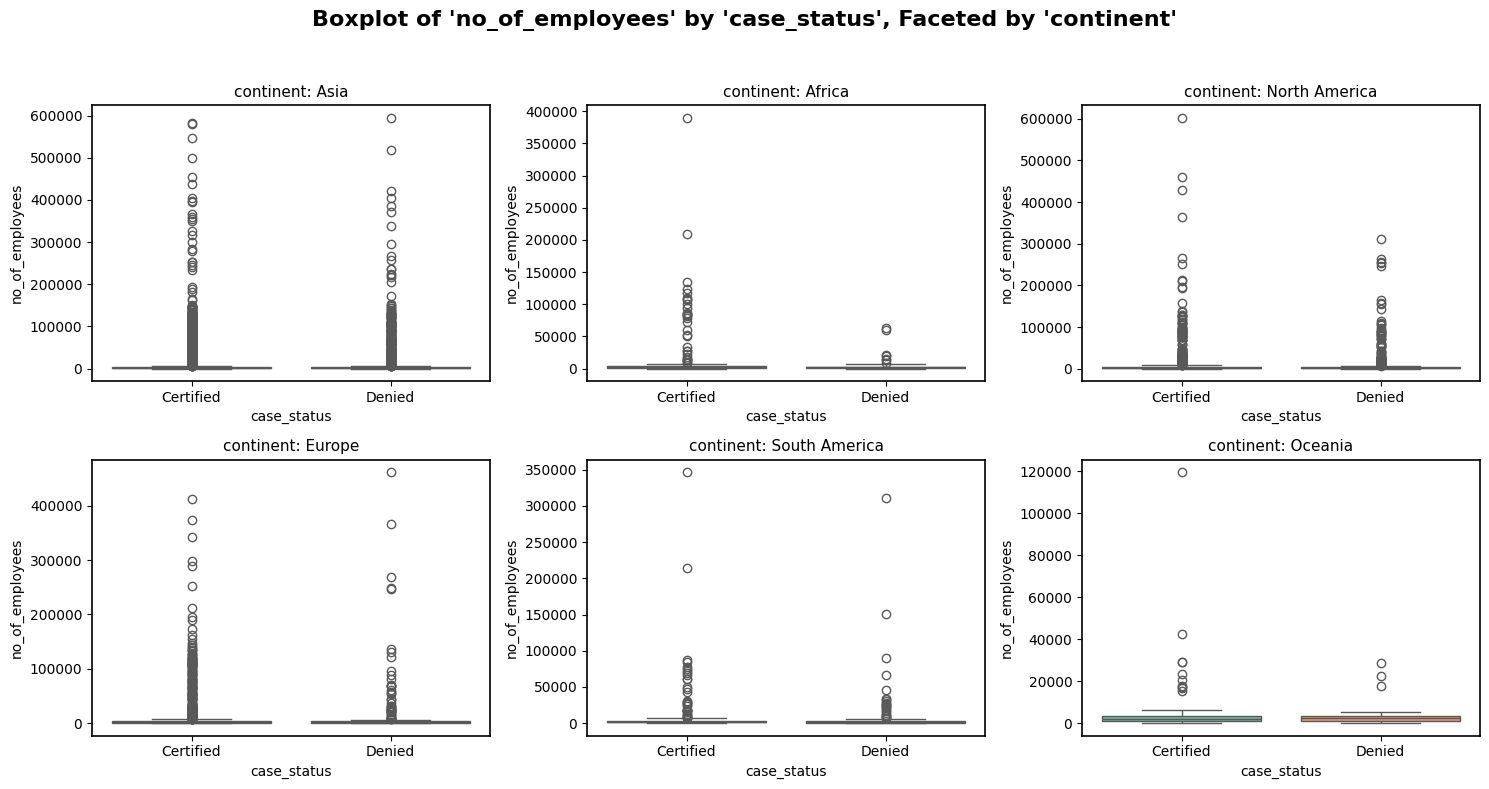

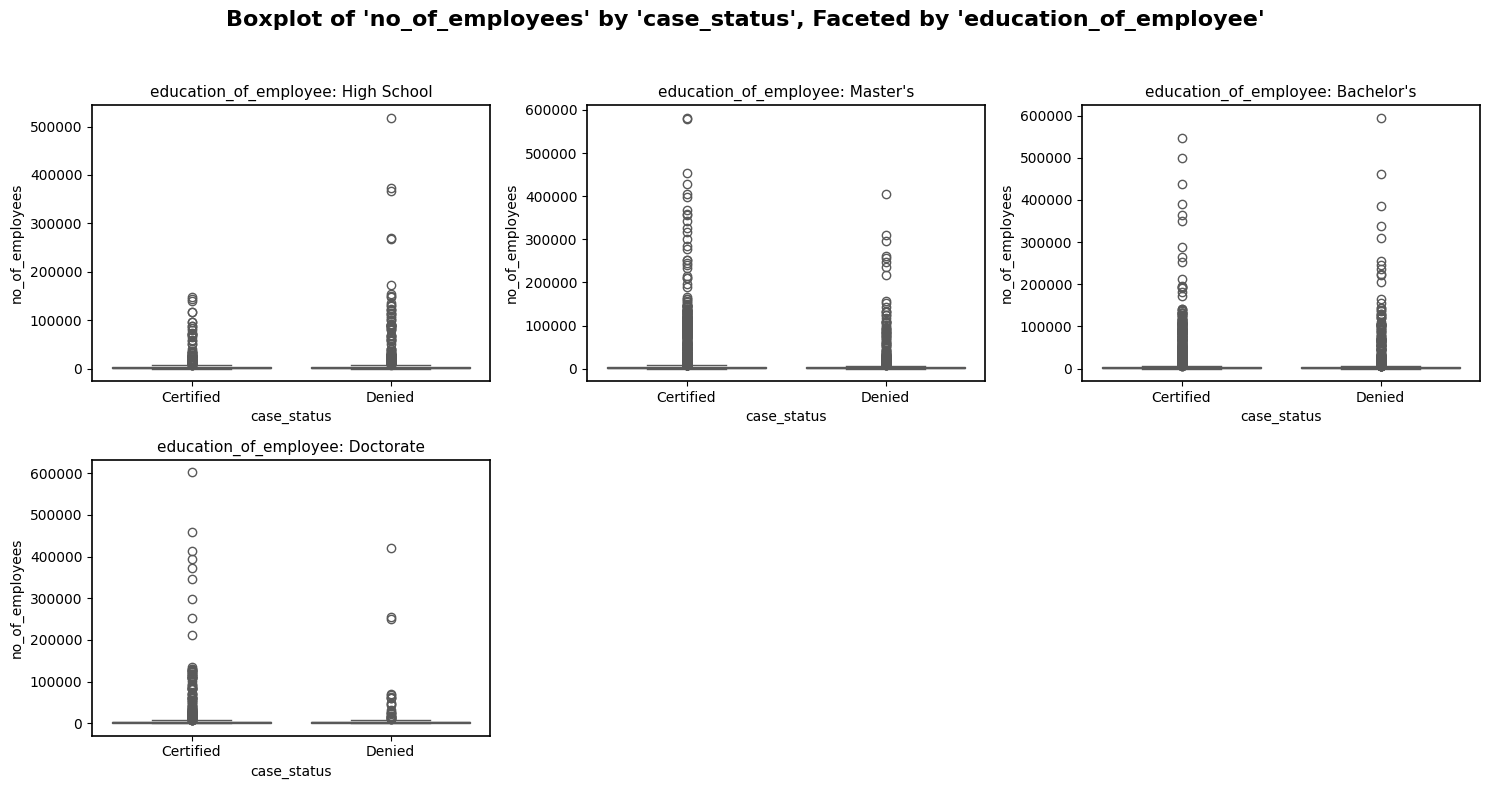

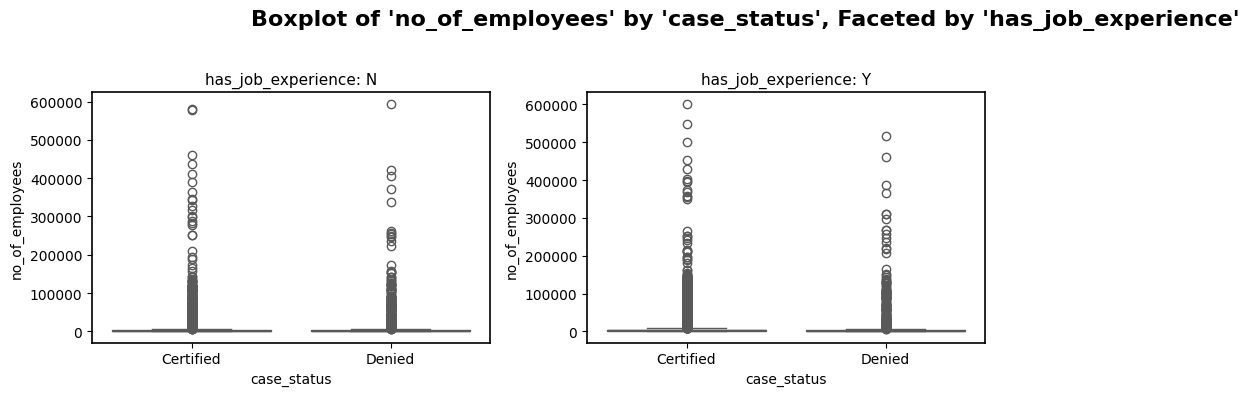

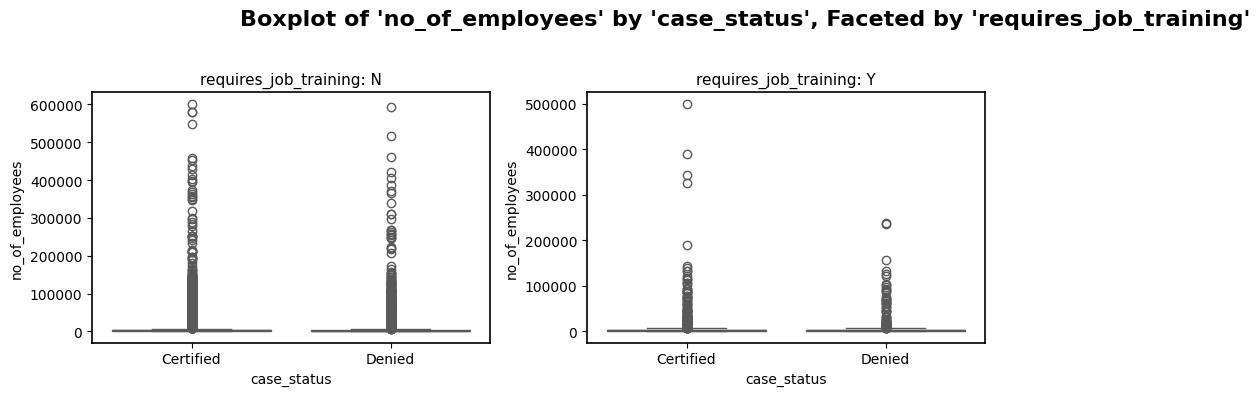

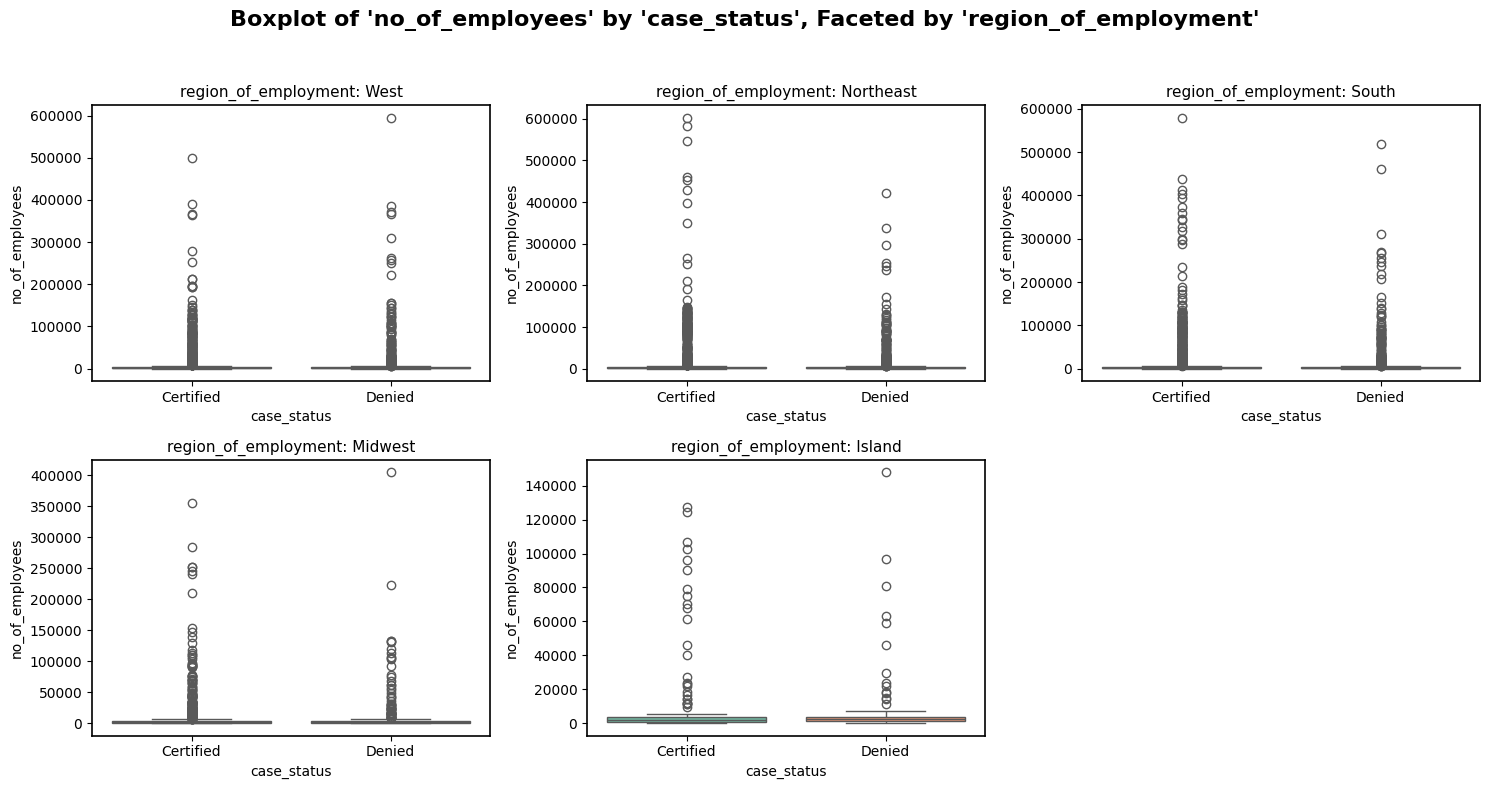

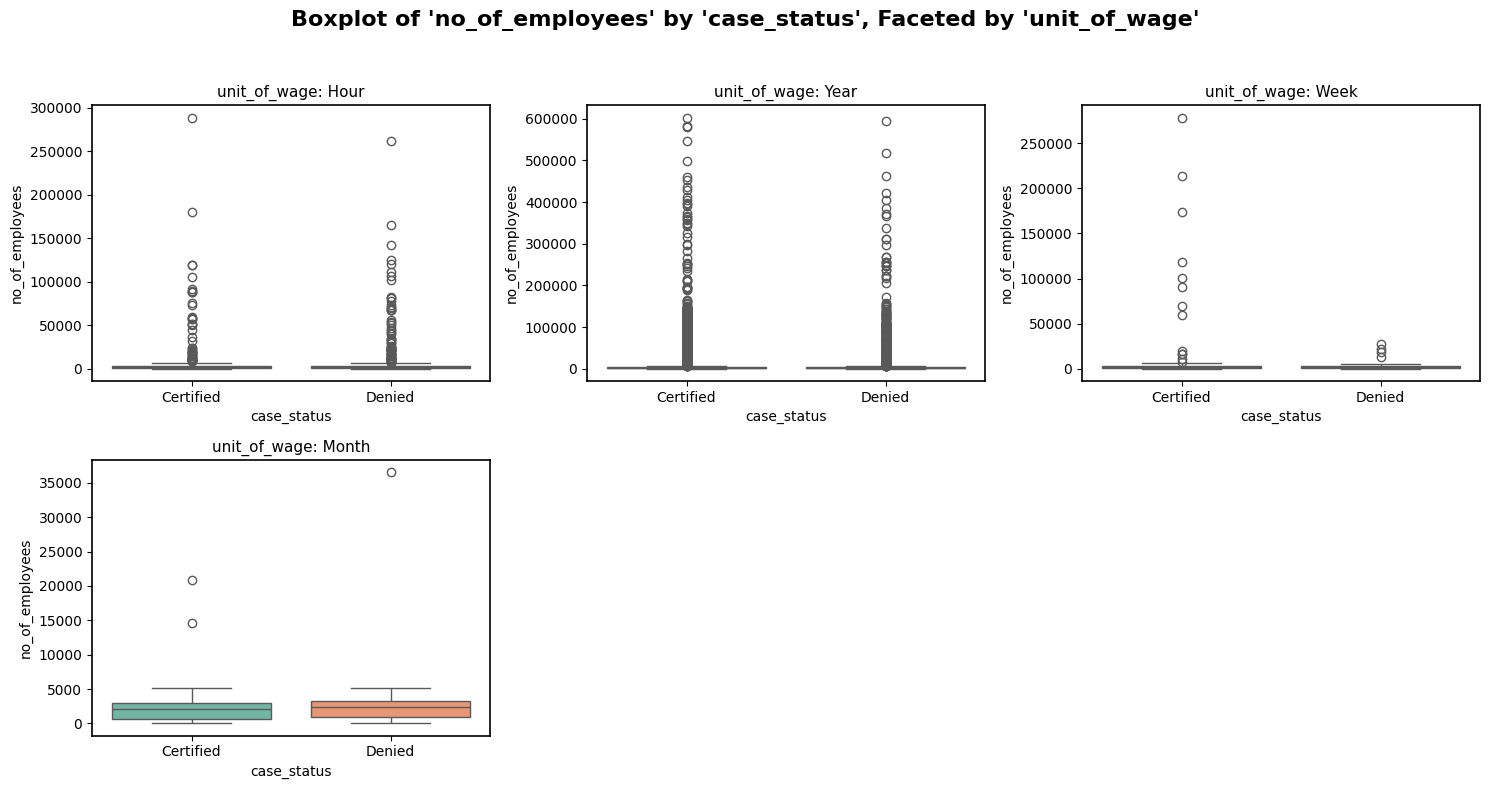

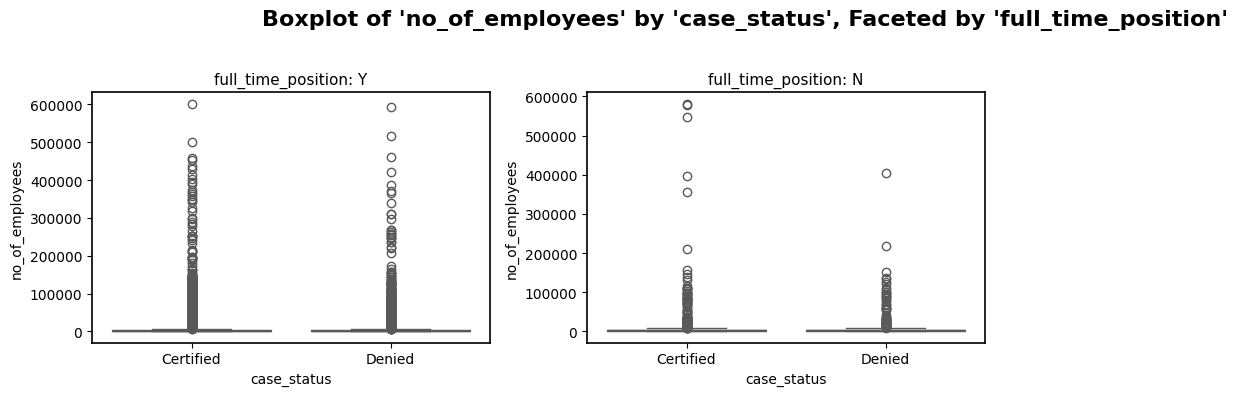

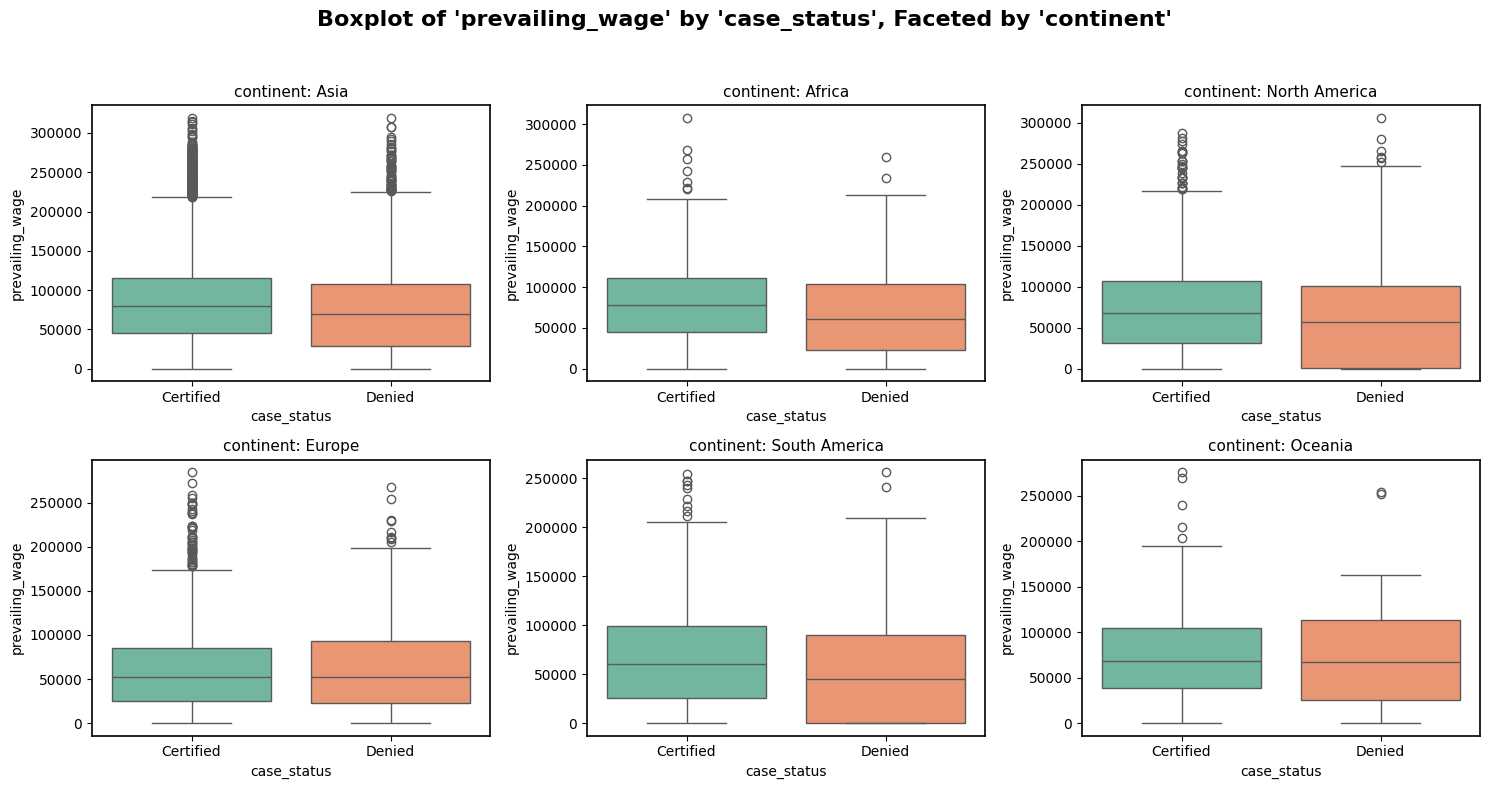

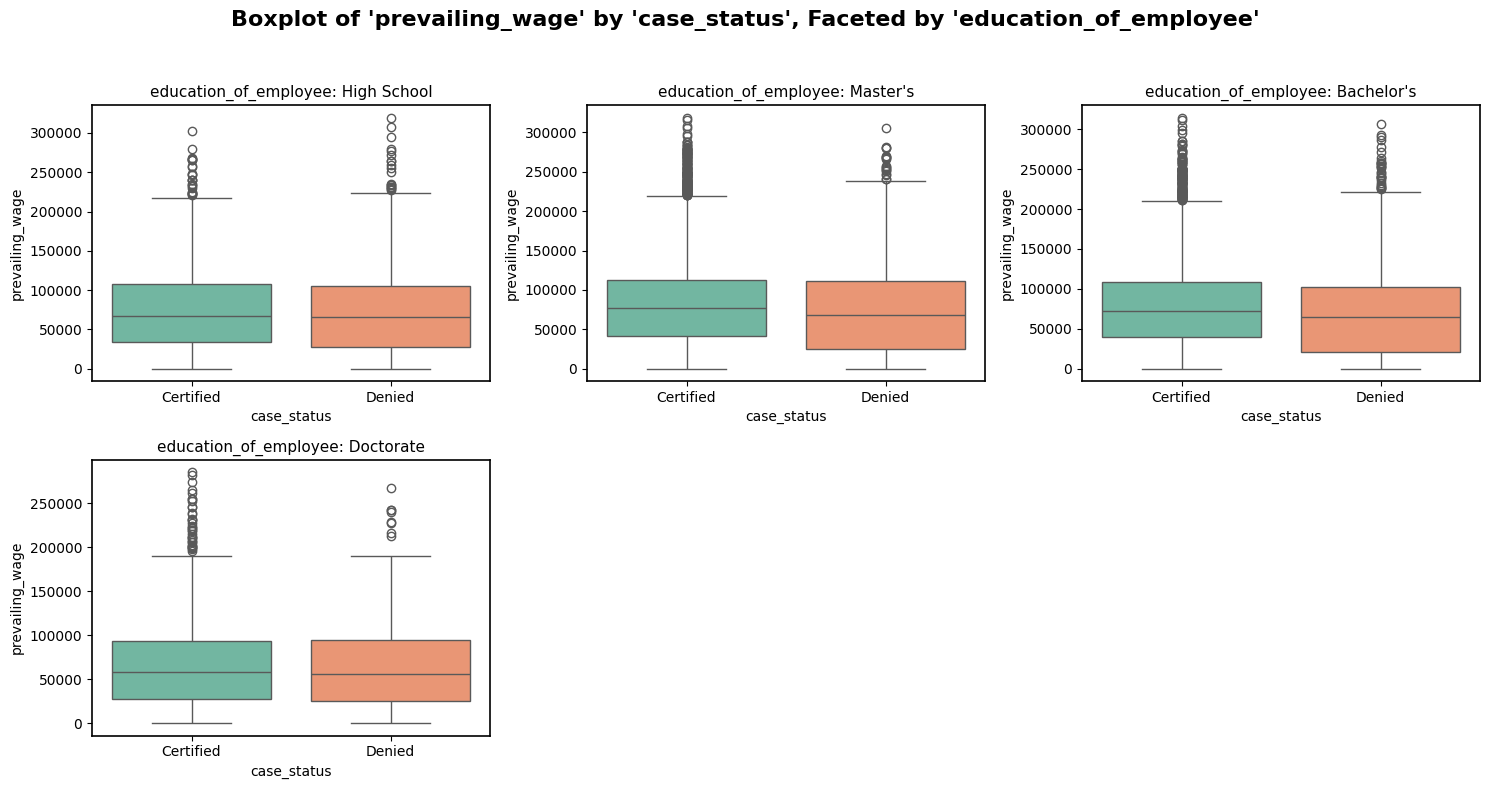

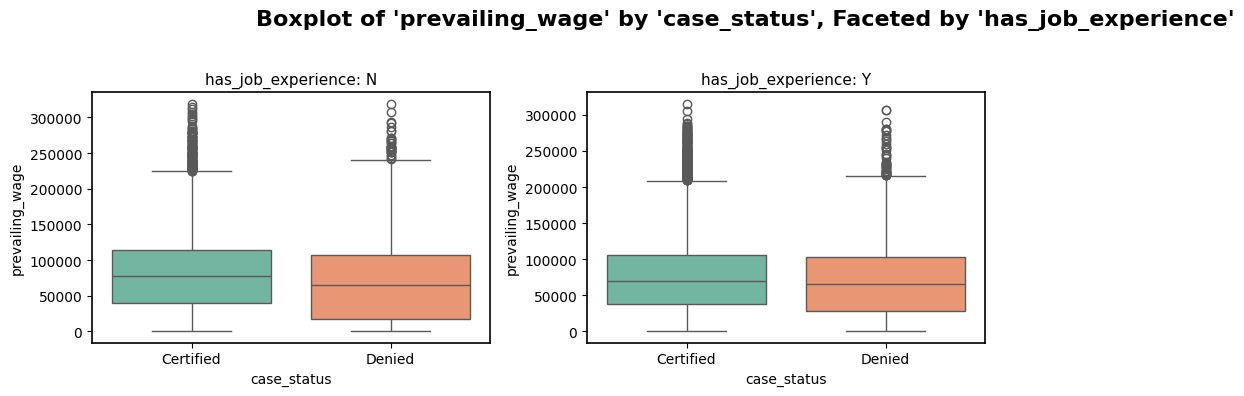

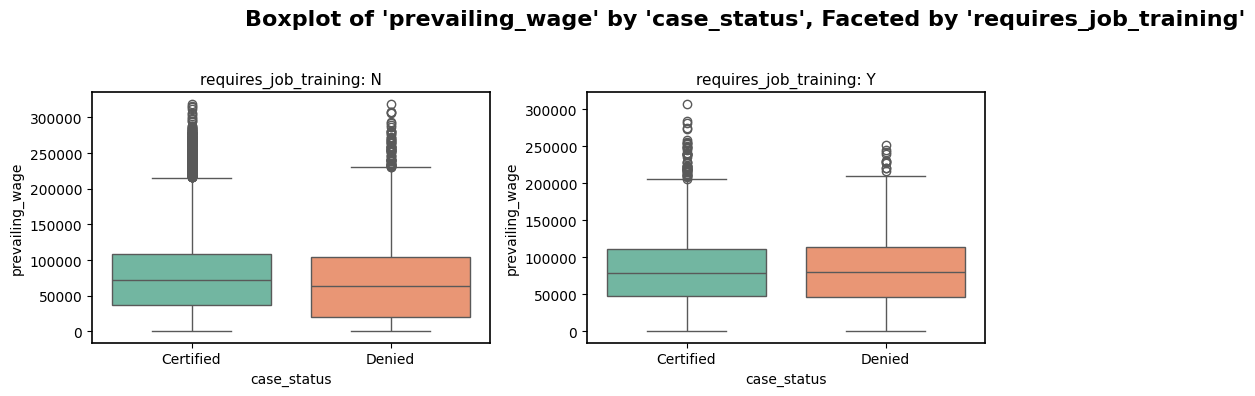

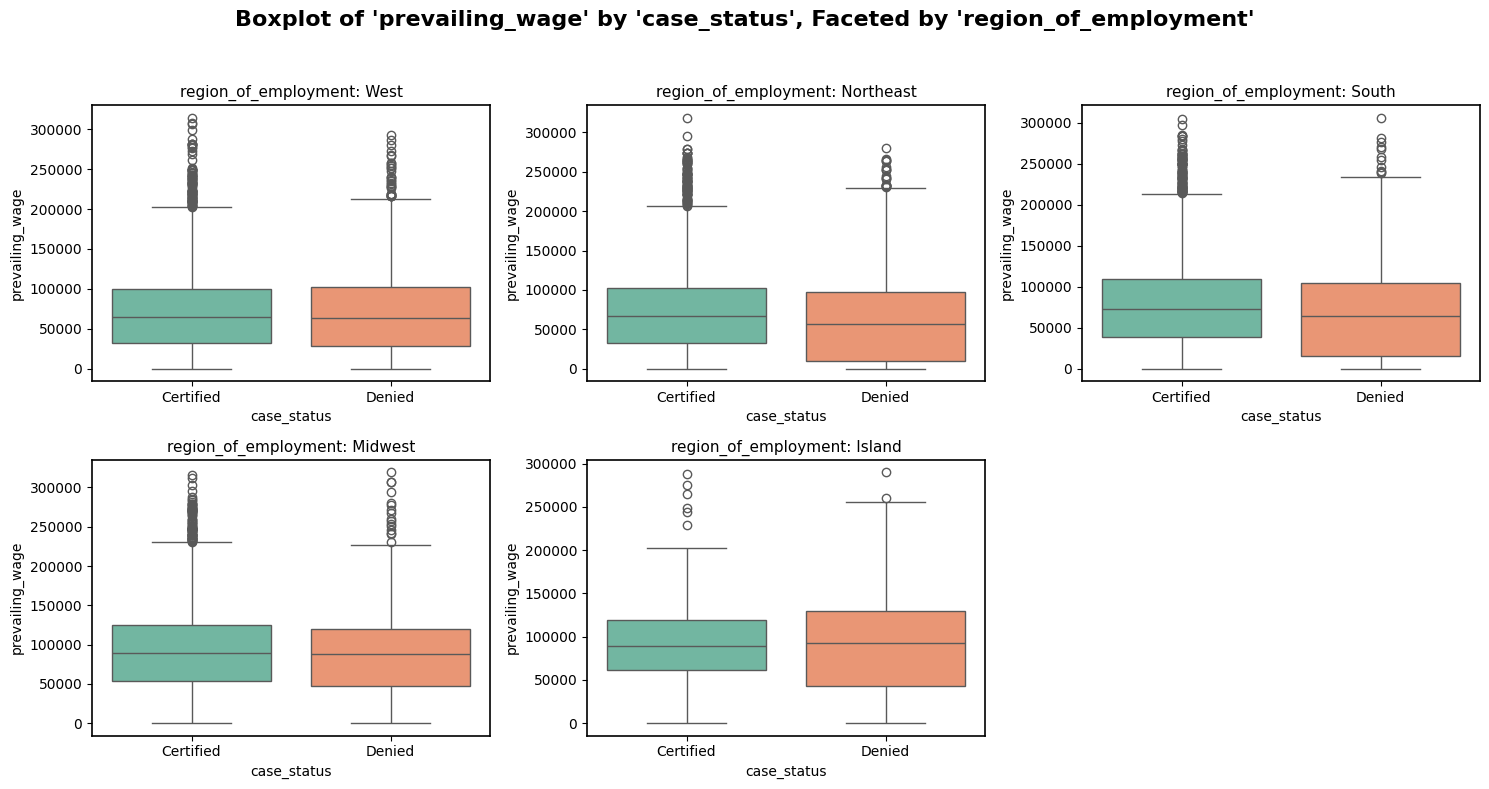

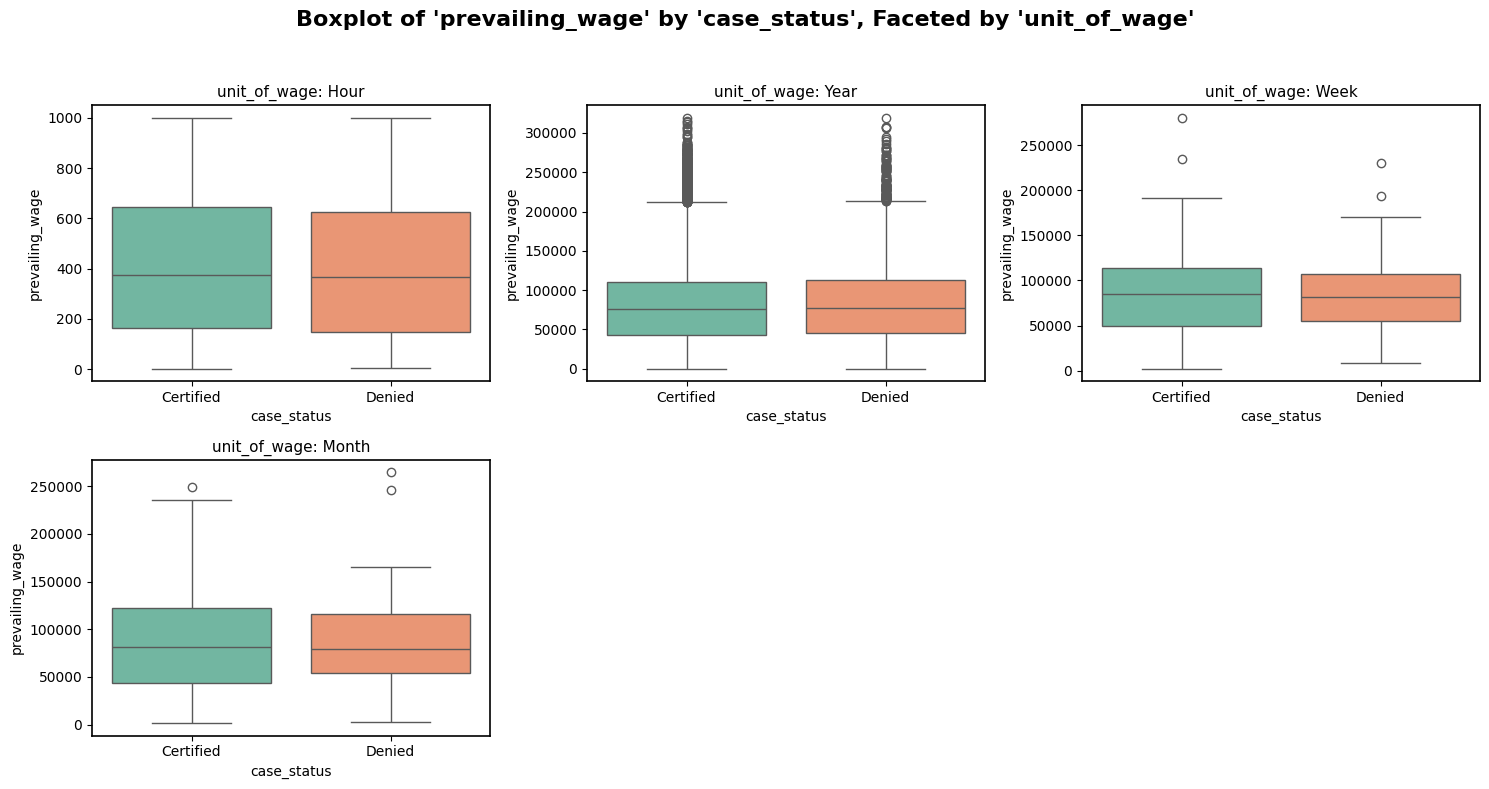

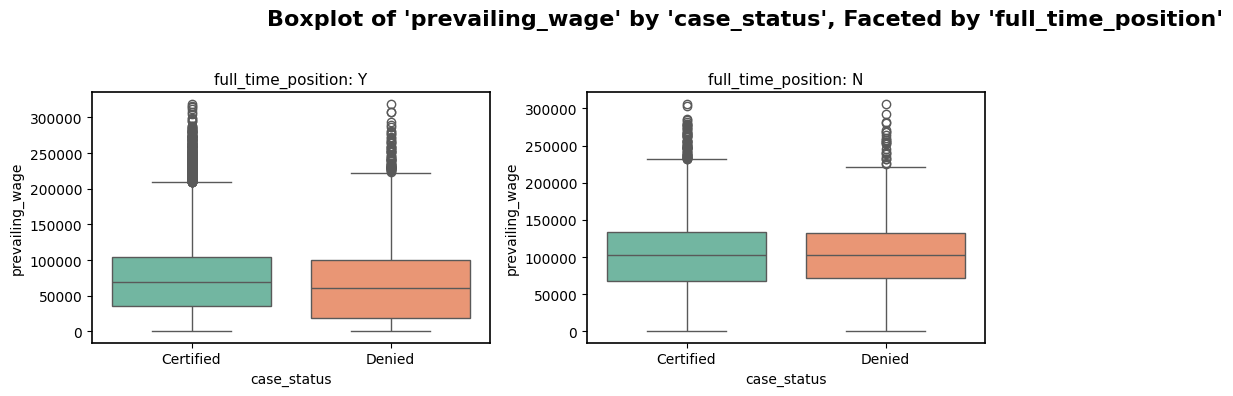

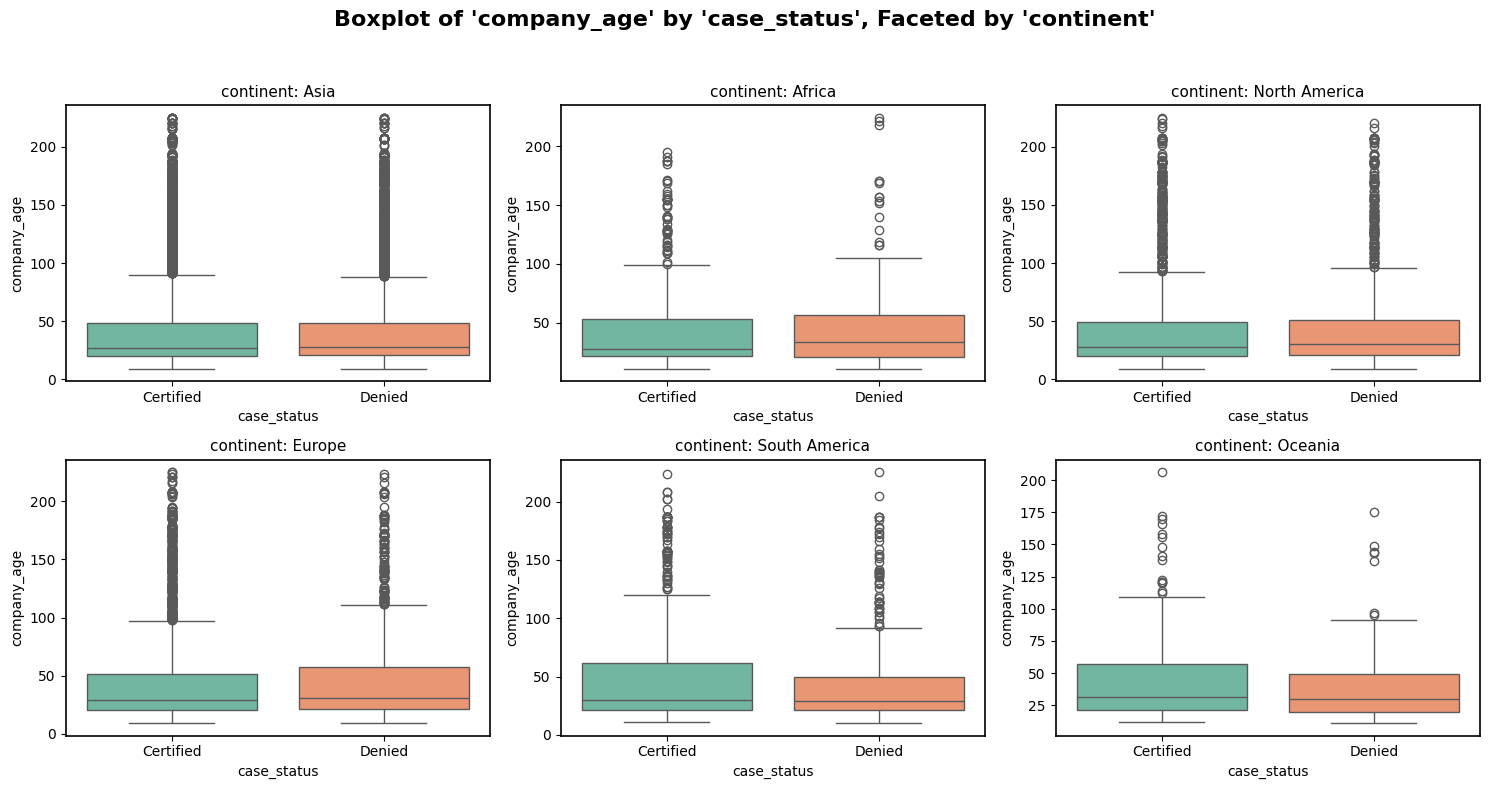

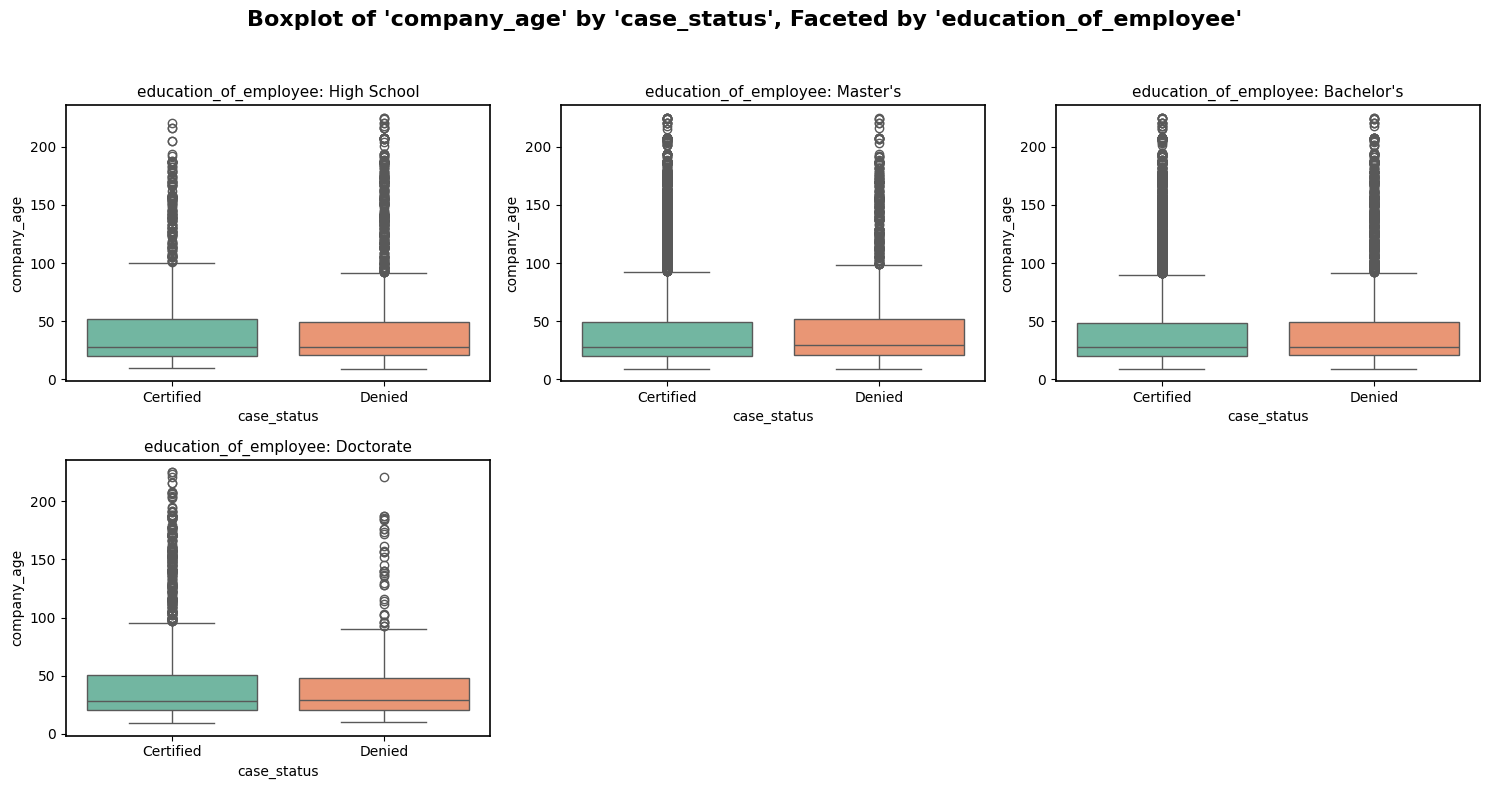

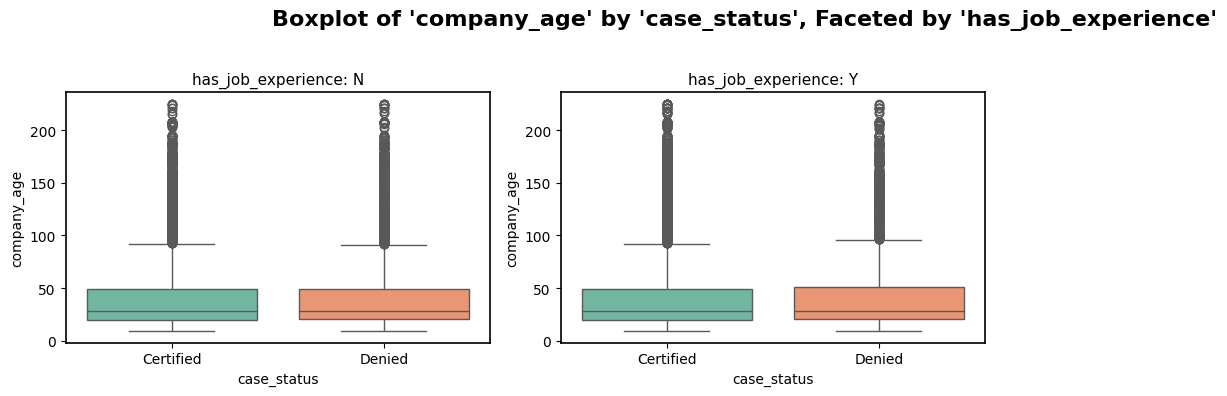

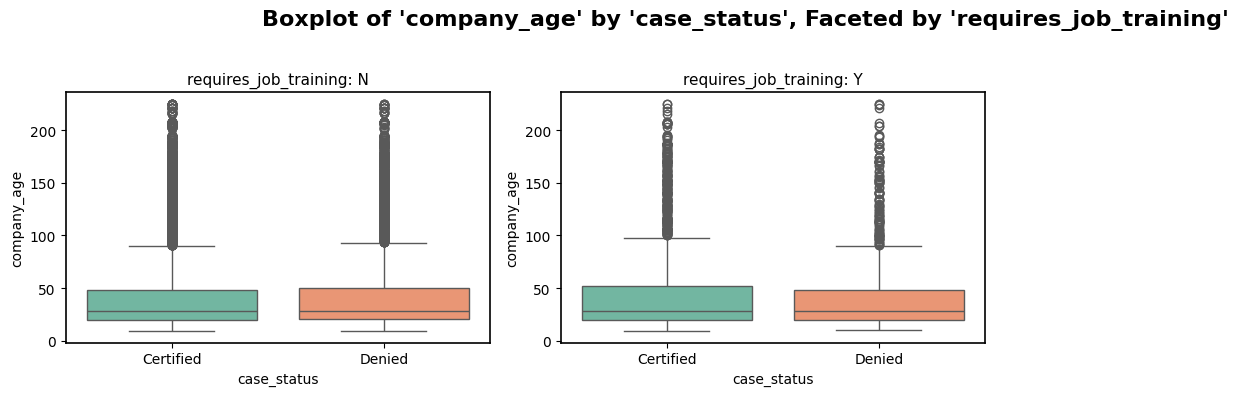

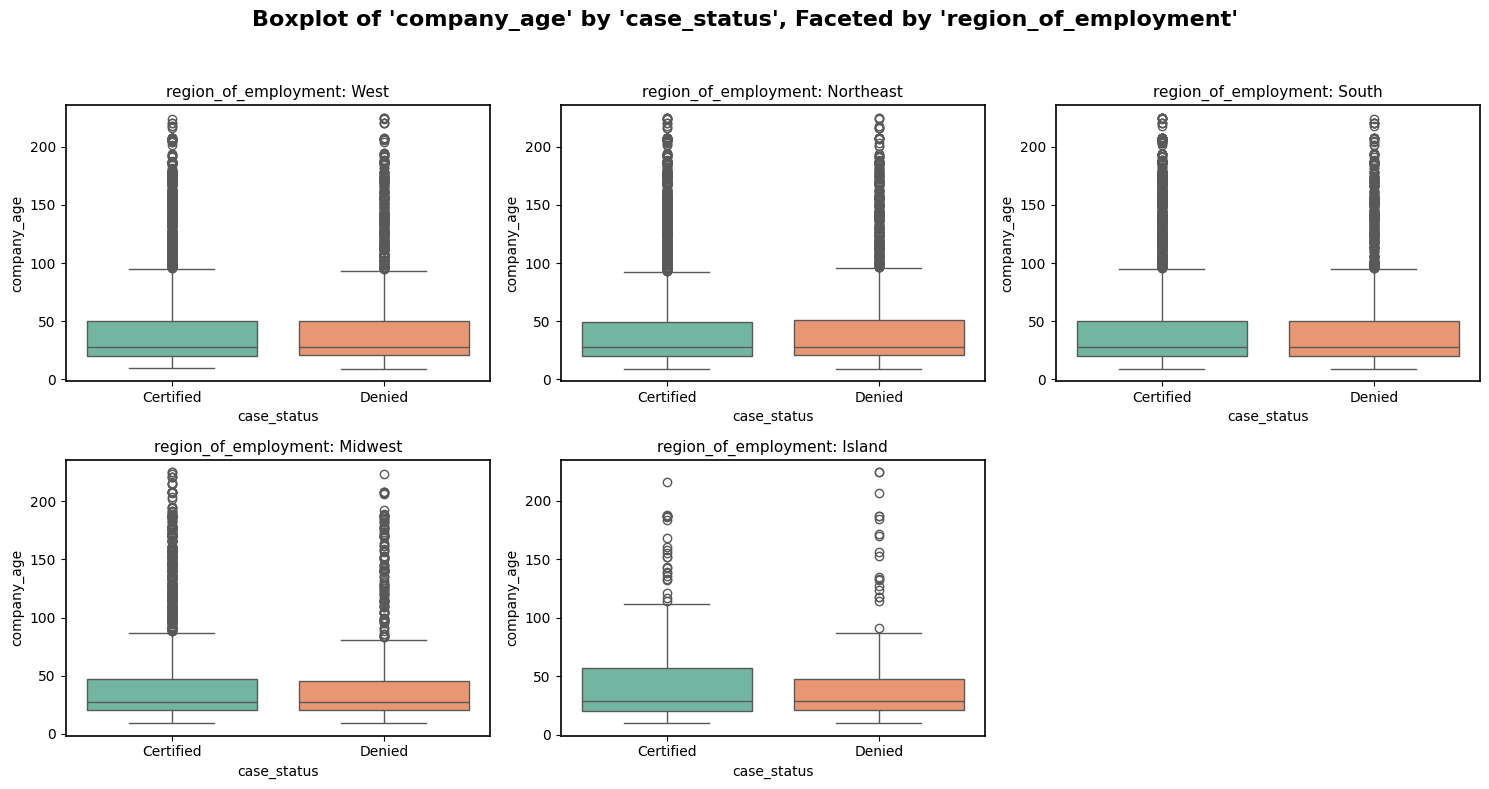

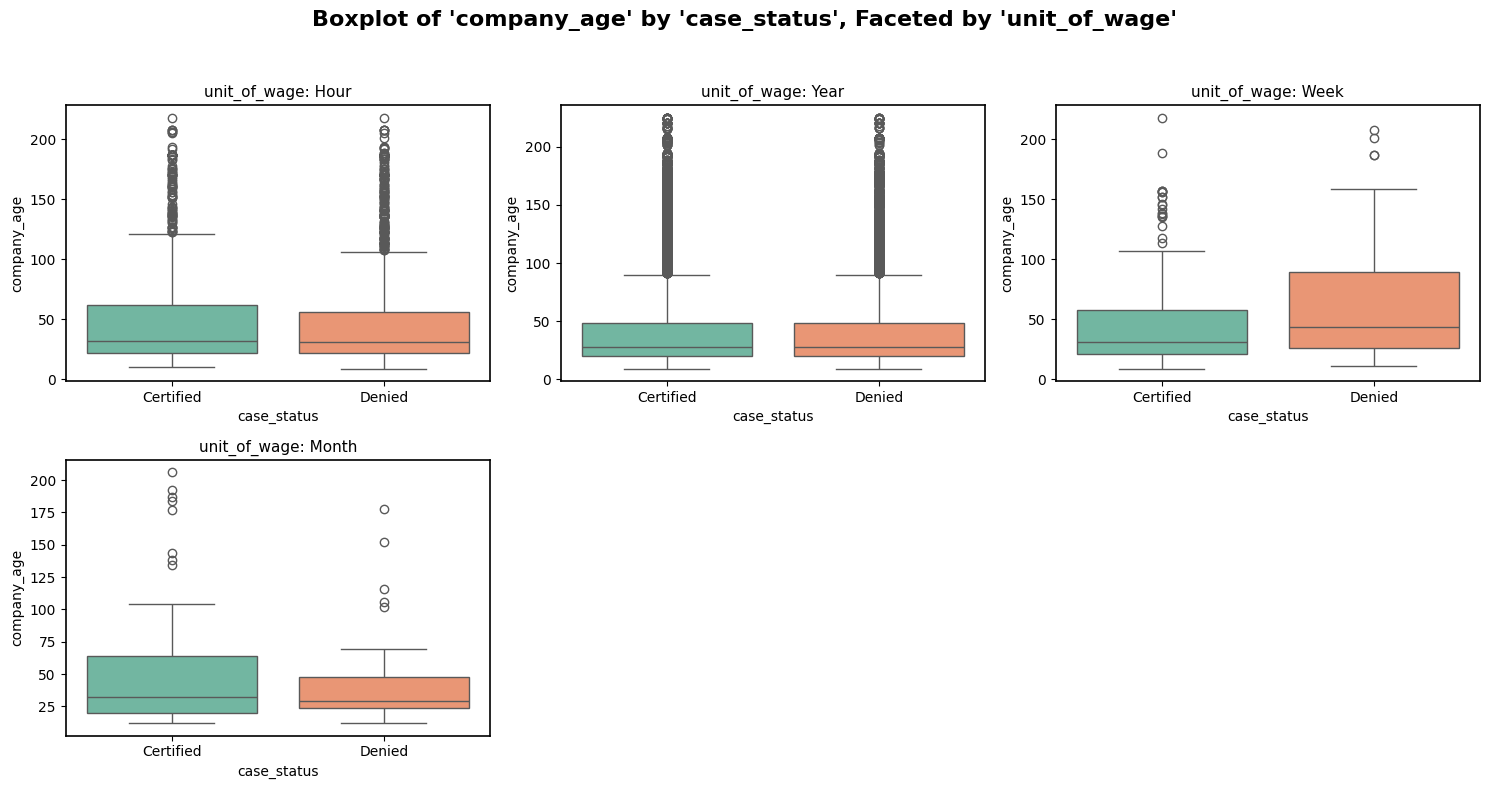

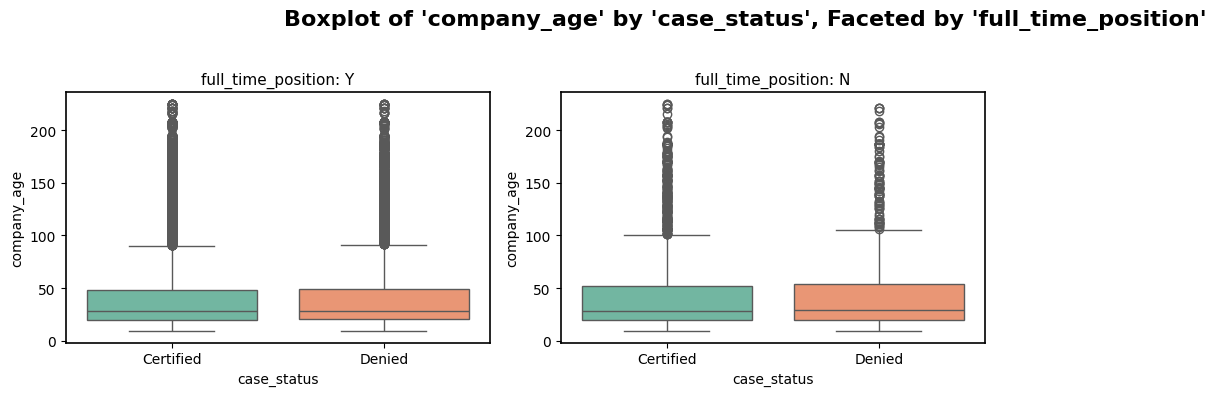

In [ ]:
create_numeric_boxplots_by_category(df, num_columns, cat_cols_upd, target='case_status')

#### Key Observations

In terms of numeric features
- Not very significant distinguishing patterns when trying to find relationship between multiple variables that can contribute to a VISA certification decision

In terms of categorical features
- When considering the applicants' continent and level of education, it can be noted that European applicants with education above high school tend to have a higher VISA certification rate, higher than Asian applicants
- Similarly, when considering the applicants' continent and prior job experience, native North Americans tend to reieve high rate of VISA certifications, even if they don't have prior work experience, which is understandable as the country would want to continue prioritize providing opportunities to U.S workers
- However, amongst outside americans, Europeans without prior work experience sitll experience a high VISA certification rate
- In terms of US regions where applicants are seeking opportunities, it appears as if west and northeast regions are more open to giving candidates without prior experience job opportunities and sponsor  their VISA (50-50% rate). South and mid-west are more inclined towards supporting and employeeing experienced applicants.


#### Based on these insights combined with those from univariate and bi-variate analysis, **it can be implied that employees' continent, education level, having prior work experience and region of employeement seem to be important predictors for their visa certification**

## Data Pre-Processing

In [ ]:
def summarize_outliers(data, numeric_features, iqr_multiplier=1.5, outlier_threshold=0.05):
    """
    Calculates outlier stats for given numeric features using the IQR method.

    Parameters:
        data (DataFrame): The dataset
        numeric_features (list): List of numeric columns to analyze
        iqr_multiplier (float): IQR threshold multiplier (default 1.5)
        outlier_threshold (float): Threshold % to flag high-outlier features (e.g., 0.05 = 5%)

    Returns:
        DataFrame summarizing outlier counts, mean, median, and decision suggestion
    """
    summary = []

    for feature in numeric_features:
        series = data[feature].dropna()
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - iqr_multiplier * iqr
        upper_bound = q3 + iqr_multiplier * iqr

        outliers = series[(series < lower_bound) | (series > upper_bound)]
        outlier_count = len(outliers)
        total = len(series)
        outlier_pct = outlier_count / total

        summary.append({
            'Feature': feature,
            'Mean': series.mean(),
            'Median': series.median(),
            'Outliers': outlier_count,
            'Total Observations': total,
            'Outlier %': round(outlier_pct * 100, 2),
            'Suggested Treatment': 'Yes' if outlier_pct > outlier_threshold else 'No'
        })

    return pd.DataFrame(summary).sort_values(by='Outlier %', ascending=False)


In [ ]:
summary_df = summarize_outliers(df, numeric_features=num_columns)
display(summary_df)


Feature          Mean    Median  Outliers  Total Observations  \
2      company_age     45.590071     28.00      3260               25480   
0  no_of_employees   5667.043210   2109.00      1556               25480   
1  prevailing_wage  74455.814592  70308.21       427               25480   

   Outlier % Suggested Treatment  
2      12.79                 Yes  
0       6.11                 Yes  
1       1.68                  No

### Key Pointers & Action Items
**Outlier Treatment**:
As observed, company age & no. of employees have >6% of observations as outliers with values within company age containing 12% outliers. As we're currently planning to use only CART based models, we'll skip the outlier treatment as these values can be helpful for the tree to create splits. However, based on model performance we'll take a call later on treating them

**Data Split**:
We'll split the data into 3 sets - Train (60% of data, Validation (20%) & Test (20%). We'll train our algorithms on the training set, validate & tune using the validation set. After choosing the best model, we'll test in production using test set

**Feature Engineering**:
- Using field "yr_of_estab", we'll derive a new metric called "company age" which will be used for model prediction as using year of establishment would cause splitting issue

- We'll also using "education_of_employee" to create a new feature called "employee_education_ranking" where we'll assign ranks 1 (lowest) to 4 (highest) based on level of education (high school gets 1 & docterate gets 4) as this we'll help the model give more weightage to higher education & make it easier for CART models to split.

**One-Hot Encoding**:
We're going to perform one-hot encoding and make dummy variables with 0/1 for all other categorical columns for the model to process

**Pipeline**:
We'll perform the above feature engineering techniques and encoding as part of tranformation pipeline which will be fit on training and later used to transform the validation set for testing/tuning.


### **Train Test Split**

In [ ]:
df.drop("company_age",axis=1,inplace=True)

In [ ]:
X = df.drop("case_status",axis=1)
y = df.case_status

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
# Result: 60% train, 20% val, 20% test


In [ ]:
print("Data Shape In Train-Validation & Test Splits:\n")
print("\nTrain Data Shape:")
display(X_train.shape)
print("\nValidation Data Shape:")
display(X_val.shape)
print("\nTest Data Split:")
display(X_test.shape)

Data Shape In Train-Validation & Test Splits:


Train Data Shape:


(15288, 10)


Validation Data Shape:


(5096, 10)


Test Data Split:


(5096, 10)

In [ ]:
print("Target Class Proportion In Train-Validation & Test Splits:\n")
print("\nTrain Split:")
display(y_train.value_counts(normalize=True))
print("\nValidation Split:")
display(y_val.value_counts(normalize=True))
print("\nTest Split:")
display(y_test.value_counts(normalize=True))

Target Class Proportion In Train-Validation & Test Splits:


Train Split:


case_status
Certified    0.667844
Denied       0.332156
Name: proportion, dtype: float64


Validation Split:


case_status
Certified    0.667975
Denied       0.332025
Name: proportion, dtype: float64


Test Split:


case_status
Certified    0.667975
Denied       0.332025
Name: proportion, dtype: float64

### **Building Data Transformation Pipeline**

In [ ]:
# Function to calculate 'company_age' and drop 'yr_of_estab'
def company_age_calculator(df):
    df = df.copy()
    df['company_age'] = dt.datetime.now().year - df['yr_of_estab'].astype(float)
    df = df.drop(columns=['yr_of_estab'])
    df['company_age'] = df['company_age'].astype(int)
    return df

company_year_established_transformer = FunctionTransformer(company_age_calculator)

In [ ]:
X_train.head()

continent education_of_employee has_job_experience  \
case_id                                                             
EZYV24316           Asia            Bachelor's                  Y   
EZYV8496            Asia            Bachelor's                  N   
EZYV7115   North America            Bachelor's                  Y   
EZYV24798           Asia              Master's                  Y   
EZYV21644         Europe            Bachelor's                  N   

          requires_job_training  no_of_employees yr_of_estab  \
case_id                                                        
EZYV24316                     N              579        1977   
EZYV8496                      N              408        1999   
EZYV7115                      N             1684        2013   
EZYV24798                     N             4259        2003   
EZYV21644                     Y             3126        1800   

          region_of_employment  prevailing_wage unit_of_wage  \
case_id                                                        
EZYV24316                South         41470.34         Year   
EZYV8496                 South         88593.58         Year   
EZYV7115                  West          2216.32         Year   
EZYV24798            Northeast          8107.37         Year   
EZYV21644                South        192806.06         Year   

          full_time_position  
case_id                       
EZYV24316                  Y  
EZYV8496                   Y  
EZYV7115                   Y  
EZYV24798                  Y  
EZYV21644                  Y

In [ ]:
X_train.education_of_employee.unique()

array(["Bachelor's", "Master's", 'High School', 'Doctorate'], dtype=object)

In [ ]:
# Creating an ordinal ranking for education as we've seen positive relation between visa status & education level of employee
def employee_education_ranking(df):
    df = df.copy()
    education_ranking = {'High School':0, "Bachelor's":1, "Master's":2,'Doctorate':3}
    df["education_level_ranking"] = df.education_of_employee.replace(education_ranking)
    df = df.drop(columns=['education_of_employee'])
    return df

employee_education_transformer = FunctionTransformer(employee_education_ranking)

In [ ]:
# Creating dummy encoding for categorical columns remaining in the dataset & preserving the order for future dataset transformations
def dummy_encode_preserve_order(df, drop_first=True):
    """
    One-hot encodes all categorical columns while preserving original column order.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        drop_first (bool): Drop first dummy to avoid multicollinearity (True by default)

    Returns:
        pd.DataFrame: Transformed DataFrame with dummy variables, in original column order
    """
    df = df.copy()
    new_cols = []

    for col in df.columns:
        if df[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df[col]):
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=drop_first,dtype=float)
            new_cols.extend(dummies.columns)
            df = df.drop(columns=[col])
            df = pd.concat([df, dummies], axis=1)
        else:
            new_cols.append(col)

    # Reorder columns to preserve appearance of original DataFrame
    ordered_cols = [col for col in df.columns if col in new_cols]
    return df[ordered_cols]

# Wrap the custom function using FunctionTransformer
dummy_encoder = FunctionTransformer(func=dummy_encode_preserve_order, kw_args={'drop_first': True}, validate=False)


In [ ]:
# Add this step at the beginning of your pipeline
data_transformation_pipeline = Pipeline(steps=[
    ('company_age_calculator', company_year_established_transformer ),
    ('employee_education_transformer', employee_education_transformer),
    ('categorical_column_transformer', dummy_encoder)
])

In [ ]:
data_transformation_pipeline.fit(X_train)

Pipeline(steps=[('company_age_calculator',
                 FunctionTransformer(func=<function company_age_calculator at 0x7ac6b5735bc0>)),
                ('employee_education_transformer',
                 FunctionTransformer(func=<function employee_education_ranking at 0x7ac6b57367a0>)),
                ('categorical_column_transformer',
                 FunctionTransformer(func=<function dummy_encode_preserve_order at 0x7ac6b5736ac0>,
                                     kw_args={'drop_first': True}))])

In [ ]:
X_train = data_transformation_pipeline.transform(X_train)

In [ ]:
X_train.head()

no_of_employees  prevailing_wage  company_age  \
case_id                                                    
EZYV24316              579         41470.34           48   
EZYV8496               408         88593.58           26   
EZYV7115              1684          2216.32           12   
EZYV24798             4259          8107.37           22   
EZYV21644             3126        192806.06          225   

           education_level_ranking  continent_Asia  continent_Europe  \
case_id                                                                
EZYV24316                        1             1.0               0.0   
EZYV8496                         1             1.0               0.0   
EZYV7115                         1             0.0               0.0   
EZYV24798                        2             1.0               0.0   
EZYV21644                        1             0.0               1.0   

           continent_North America  continent_Oceania  \
case_id                                                 
EZYV24316                      0.0                0.0   
EZYV8496                       0.0                0.0   
EZYV7115                       1.0                0.0   
EZYV24798                      0.0                0.0   
EZYV21644                      0.0                0.0   

           continent_South America  has_job_experience_Y  \
case_id                                                    
EZYV24316                      0.0                   1.0   
EZYV8496                       0.0                   0.0   
EZYV7115                       0.0                   1.0   
EZYV24798                      0.0                   1.0   
EZYV21644                      0.0                   0.0   

           requires_job_training_Y  region_of_employment_Midwest  \
case_id                                                            
EZYV24316                      0.0                           0.0   
EZYV8496                       0.0                           0.0   
EZYV7115                       0.0                           0.0   
EZYV24798                      0.0                           0.0   
EZYV21644                      1.0                           0.0   

           region_of_employment_Northeast  region_of_employment_South  \
case_id                                                                 
EZYV24316                             0.0                         1.0   
EZYV8496                              0.0                         1.0   
EZYV7115                              0.0                         0.0   
EZYV24798                             1.0                         0.0   
EZYV21644                             0.0                         1.0   

           region_of_employment_West  unit_of_wage_Month  unit_of_wage_Week  \
case_id                                                                       
EZYV24316                        0.0                 0.0                0.0   
EZYV8496                         0.0                 0.0                0.0   
EZYV7115                         1.0                 0.0                0.0   
EZYV24798                        0.0                 0.0                0.0   
EZYV21644                        0.0                 0.0                0.0   

           unit_of_wage_Year  full_time_position_Y  
case_id                                             
EZYV24316                1.0                   1.0  
EZYV8496                 1.0                   1.0  
EZYV7115                 1.0                   1.0  
EZYV24798                1.0                   1.0  
EZYV21644                1.0                   1.0

In [ ]:
X_train.columns

Index(['no_of_employees', 'prevailing_wage', 'company_age',
       'education_level_ranking', 'continent_Asia', 'continent_Europe',
       'continent_North America', 'continent_Oceania',
       'continent_South America', 'has_job_experience_Y',
       'requires_job_training_Y', 'region_of_employment_Midwest',
       'region_of_employment_Northeast', 'region_of_employment_South',
       'region_of_employment_West', 'unit_of_wage_Month', 'unit_of_wage_Week',
       'unit_of_wage_Year', 'full_time_position_Y'],
      dtype='object')

In [ ]:
X_val = data_transformation_pipeline.transform(X_val)

## Model Building - Using Original Data


### Chosen Evaluation Metric:

For the EasyVisa classification task — where the goal is to predict whether a visa application will be **Certified** or **Denied** — we need to decide which metric i.e recall, precision or f1 score is important to focus on.


### Real Time Implication of False Predictions

Visa application processing is a high-stakes task. The consequences of incorrect predictions are not symmetric and can lead to significant operational or reputational risks for the organization.

#### False Negatives (FN):

> A qualified applicant is predicted as **Denied**

* **Impact**: We miss out on highly qualified foreign candidates who meet all requirements but are rejected due to model error.
* **Consequences**: Loss of global talent for U.S. companies trying to fill critical roles. It also causes potential delays in projects or product rollouts due to unfilled roles.


#### False Positives (FP):

> An unqualified applicant is predicted as **Certified**

* **Impact**: We incorrectly approve applications that should be rejected.
* **Consequence**: **Regulatory non-compliance**, as the system certifies applicants who do not meet required standards. Also, this impacts & hurts the chances of native U.S citizens getting job opportunities and causing stir within local workers


### Metric of Choice

Because both types of errors — false positives and false negatives — can be **equally damaging** from different angles, we need a metric that balances both false positive & negative i.e **F1 Score**

It ensures that neither type of error dominates the evaluation and helps us build a model that is both **accurate** and **responsible** in real-world deployment.


In [ ]:
# Global DataFrame to store scores
model_train_scores_df = pd.DataFrame()
model_val_scores_df = pd.DataFrame()


def evaluate_model(model, X_val, y_val, model_name, scores_df, data_split ,label_encoder=None):
    """
    Evaluates the given model on the validation set and stores results focused on F1-score.

    Parameters:
        model: Trained classification model
        X_val: Validation features
        y_val: Validation target (can be encoded or original)
        model_name: Name of the model (string)
        scores_df: DataFrame to store metrics
        label_encoder: Optional LabelEncoder to decode predictions (useful for XGBoost)

    Returns:
        Updated scores_df with F1 focus, confusion matrix, and classification report
    """
    y_pred = model.predict(X_val)

    # Decode if using LabelEncoder
    if label_encoder:
        y_val = label_encoder.inverse_transform(y_val)
        y_pred = label_encoder.inverse_transform(y_pred)

    # Get metrics
    report = classification_report(y_val, y_pred, output_dict=True)
    labeled_report = classification_report(y_val, y_pred)

    accuracy = report['accuracy']
    recall_macro_avg = report['macro avg']['recall']
    precision_macro_avg = report['macro avg']['precision']
    f1_macro_avg = report['macro avg']['f1-score']

    # Append F1-focused row to scores_df using concat
    new_row = pd.DataFrame([{
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision_macro_avg, 4),
        'Recall': round(recall_macro_avg, 4),
        'F1 Score': round(f1_macro_avg, 4)
    }])
    scores_df = pd.concat([scores_df, new_row], ignore_index=True)

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred, labels=['Certified', 'Denied'])
    cm_sum = np.sum(cm)
    cm_percent = cm / cm_sum * 100

    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            pct = cm_percent[i, j]
            annot[i, j] = f'{count}\n({pct:.1f}%)'

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=['Certified', 'Denied'], yticklabels=['Certified', 'Denied'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}: {data_split} Split')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"Classification Report for {model_name}: {data_split} Scores\n")
    print(labeled_report)

    return scores_df

In [ ]:
# 1. Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

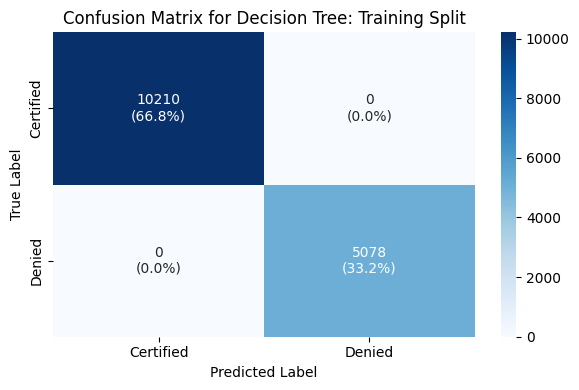

Classification Report for Decision Tree: Training Scores

              precision    recall  f1-score   support

   Certified       1.00      1.00      1.00     10210
      Denied       1.00      1.00      1.00      5078

    accuracy                           1.00     15288
   macro avg       1.00      1.00      1.00     15288
weighted avg       1.00      1.00      1.00     15288



In [ ]:
model_train_scores_df = evaluate_model(dt_model, X_train, y_train, model_name='Decision Tree', scores_df=model_train_scores_df,data_split="Training")

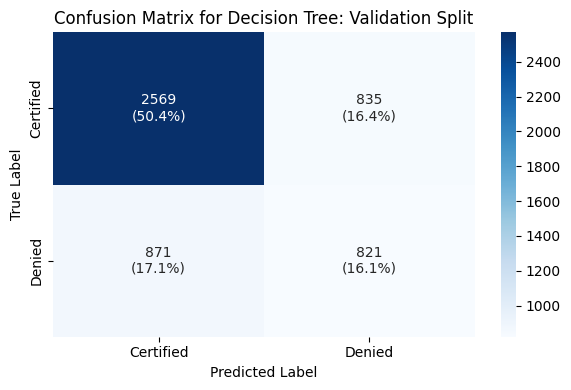

Classification Report for Decision Tree: Validation Scores

              precision    recall  f1-score   support

   Certified       0.75      0.75      0.75      3404
      Denied       0.50      0.49      0.49      1692

    accuracy                           0.67      5096
   macro avg       0.62      0.62      0.62      5096
weighted avg       0.66      0.67      0.66      5096



In [ ]:
model_val_scores_df = evaluate_model(dt_model, X_val, y_val, model_name='Decision Tree', scores_df=model_val_scores_df,data_split="Validation")

In [ ]:
# 2. Random Forest
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

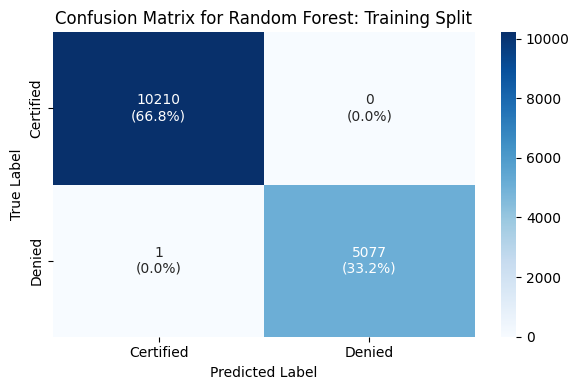

Classification Report for Random Forest: Training Scores

              precision    recall  f1-score   support

   Certified       1.00      1.00      1.00     10210
      Denied       1.00      1.00      1.00      5078

    accuracy                           1.00     15288
   macro avg       1.00      1.00      1.00     15288
weighted avg       1.00      1.00      1.00     15288



In [ ]:
model_train_scores_df = evaluate_model(rf_model, X_train, y_train, model_name='Random Forest', scores_df=model_train_scores_df,data_split="Training")

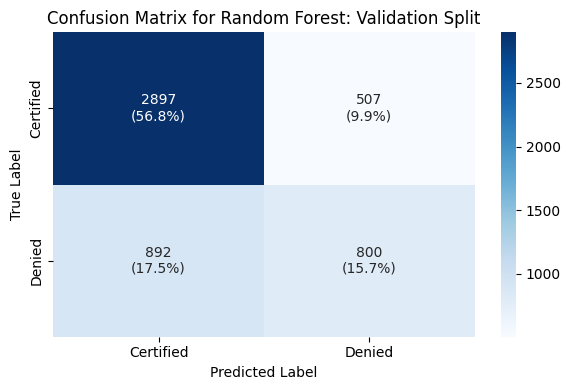

Classification Report for Random Forest: Validation Scores

              precision    recall  f1-score   support

   Certified       0.76      0.85      0.81      3404
      Denied       0.61      0.47      0.53      1692

    accuracy                           0.73      5096
   macro avg       0.69      0.66      0.67      5096
weighted avg       0.71      0.73      0.72      5096



In [ ]:
model_val_scores_df = evaluate_model(rf_model, X_val, y_val, model_name='Random Forest', scores_df=model_val_scores_df,data_split="Validation")

In [ ]:
# 3. Bagging Classifier (with Decision Trees)
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)

bag_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50,
                  random_state=42)

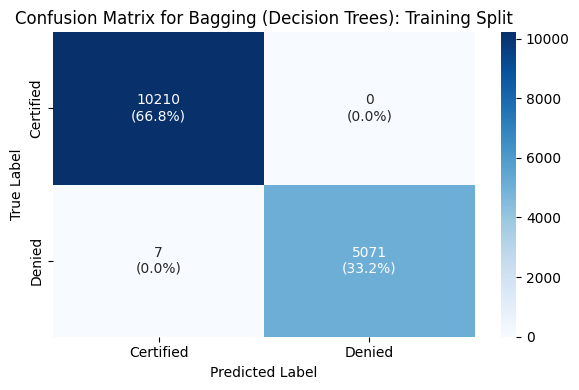

Classification Report for Bagging (Decision Trees): Training Scores

              precision    recall  f1-score   support

   Certified       1.00      1.00      1.00     10210
      Denied       1.00      1.00      1.00      5078

    accuracy                           1.00     15288
   macro avg       1.00      1.00      1.00     15288
weighted avg       1.00      1.00      1.00     15288



In [ ]:
model_train_scores_df = evaluate_model(bag_model, X_train, y_train, model_name='Bagging (Decision Trees)', scores_df=model_train_scores_df,data_split="Training")

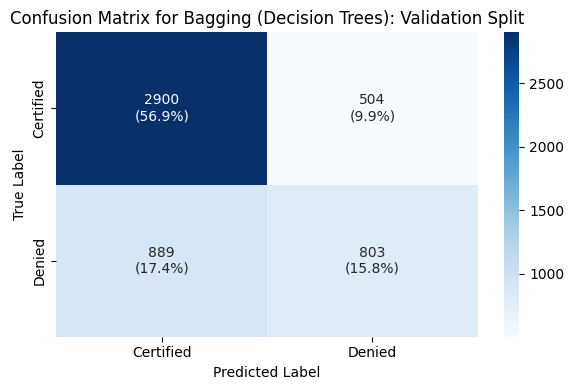

Classification Report for Bagging (Decision Trees): Validation Scores

              precision    recall  f1-score   support

   Certified       0.77      0.85      0.81      3404
      Denied       0.61      0.47      0.54      1692

    accuracy                           0.73      5096
   macro avg       0.69      0.66      0.67      5096
weighted avg       0.72      0.73      0.72      5096



In [ ]:
model_val_scores_df = evaluate_model(bag_model, X_val, y_val, model_name='Bagging (Decision Trees)', scores_df=model_val_scores_df, data_split="Validation")

In [ ]:
# 4. AdaBoost Classifier
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)

ada_model.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

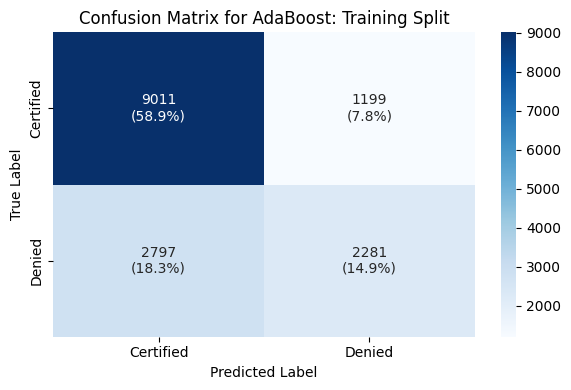

Classification Report for AdaBoost: Training Scores

              precision    recall  f1-score   support

   Certified       0.76      0.88      0.82     10210
      Denied       0.66      0.45      0.53      5078

    accuracy                           0.74     15288
   macro avg       0.71      0.67      0.68     15288
weighted avg       0.73      0.74      0.72     15288



In [ ]:
model_train_scores_df = evaluate_model(ada_model, X_train, y_train, model_name='AdaBoost', scores_df=model_train_scores_df,data_split="Training")

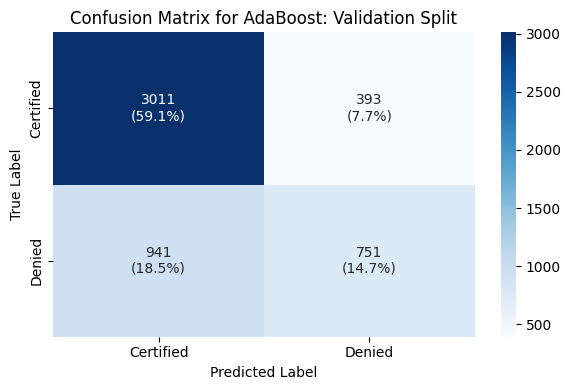

Classification Report for AdaBoost: Validation Scores

              precision    recall  f1-score   support

   Certified       0.76      0.88      0.82      3404
      Denied       0.66      0.44      0.53      1692

    accuracy                           0.74      5096
   macro avg       0.71      0.66      0.67      5096
weighted avg       0.73      0.74      0.72      5096



In [ ]:
model_val_scores_df = evaluate_model(ada_model, X_val, y_val, model_name='AdaBoost', scores_df=model_val_scores_df,data_split="Validation")

In [ ]:
# 5. Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

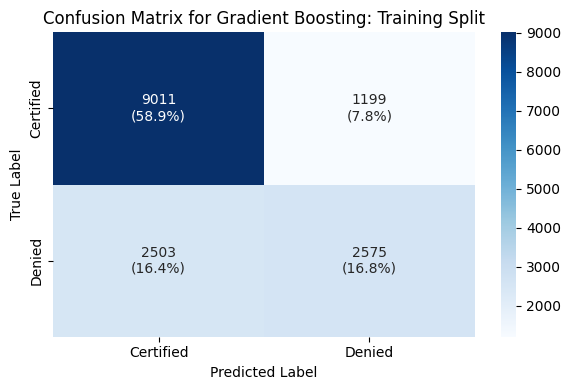

Classification Report for Gradient Boosting: Training Scores

              precision    recall  f1-score   support

   Certified       0.78      0.88      0.83     10210
      Denied       0.68      0.51      0.58      5078

    accuracy                           0.76     15288
   macro avg       0.73      0.69      0.71     15288
weighted avg       0.75      0.76      0.75     15288



In [ ]:
model_train_scores_df = evaluate_model(gb_model, X_train, y_train, model_name='Gradient Boosting', scores_df=model_train_scores_df,data_split="Training")

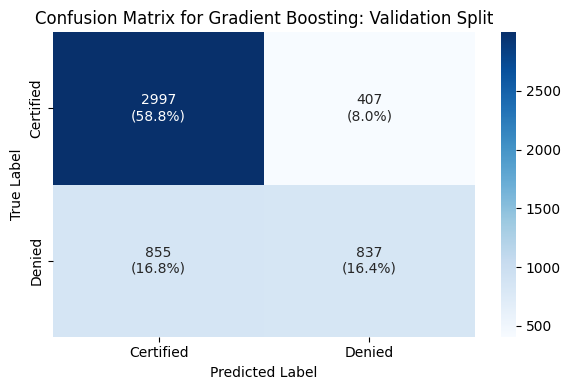

Classification Report for Gradient Boosting: Validation Scores

              precision    recall  f1-score   support

   Certified       0.78      0.88      0.83      3404
      Denied       0.67      0.49      0.57      1692

    accuracy                           0.75      5096
   macro avg       0.73      0.69      0.70      5096
weighted avg       0.74      0.75      0.74      5096



In [ ]:
model_val_scores_df = evaluate_model(gb_model, X_val, y_val, model_name='Gradient Boosting', scores_df=model_val_scores_df,data_split="Validation")

In [ ]:
# 6. XGBoost Classifier

#Fitting on training labels only
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_model.fit(X_train, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

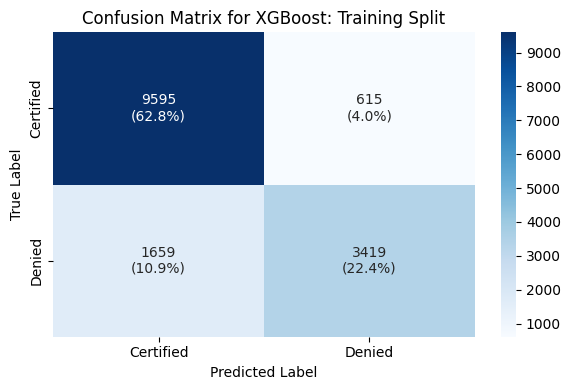

Classification Report for XGBoost: Training Scores

              precision    recall  f1-score   support

   Certified       0.85      0.94      0.89     10210
      Denied       0.85      0.67      0.75      5078

    accuracy                           0.85     15288
   macro avg       0.85      0.81      0.82     15288
weighted avg       0.85      0.85      0.85     15288



In [ ]:
model_train_scores_df = evaluate_model(xgb_model, X_train, y_train_encoded, model_name='XGBoost', scores_df=model_train_scores_df, data_split="Training", label_encoder=le)


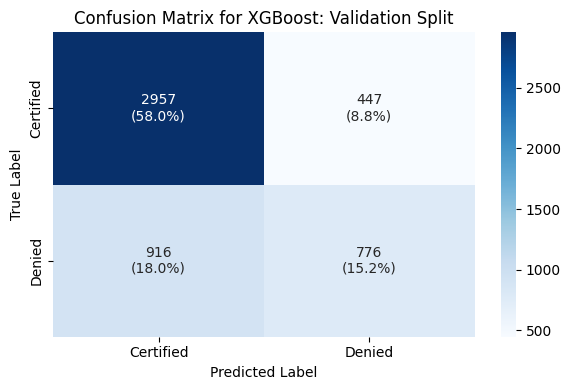

Classification Report for XGBoost: Validation Scores

              precision    recall  f1-score   support

   Certified       0.76      0.87      0.81      3404
      Denied       0.63      0.46      0.53      1692

    accuracy                           0.73      5096
   macro avg       0.70      0.66      0.67      5096
weighted avg       0.72      0.73      0.72      5096



In [ ]:
model_val_scores_df = evaluate_model(xgb_model, X_val, y_val_encoded, model_name='XGBoost', scores_df=model_val_scores_df, data_split="Validation", label_encoder=le)

In [ ]:
# Show final comparison table
print("\nModel Comparison Summary: Training Scores")
display(model_train_scores_df.sort_values(by='F1 Score', ascending=False))


Model Comparison Summary: Training Scores


Model  Accuracy  Precision  Recall  F1 Score
0             Decision Tree    1.0000     1.0000  1.0000    1.0000
1             Random Forest    0.9999     1.0000  0.9999    0.9999
2  Bagging (Decision Trees)    0.9995     0.9997  0.9993    0.9995
5                   XGBoost    0.8513     0.8501  0.8065    0.8222
4         Gradient Boosting    0.7578     0.7325  0.6948    0.7057
3                  AdaBoost    0.7386     0.7093  0.6659    0.6758

In [ ]:
# Show final comparison table
print("\nModel Comparison Summary: Validation Scores")
display(model_val_scores_df.sort_values(by='F1 Score', ascending=False))


Model Comparison Summary: Validation Scores


Model  Accuracy  Precision  Recall  F1 Score
4         Gradient Boosting    0.7524     0.7254  0.6876    0.6981
3                  AdaBoost    0.7382     0.7092  0.6642    0.6741
5                   XGBoost    0.7325     0.6990  0.6637    0.6726
2  Bagging (Decision Trees)    0.7266     0.6899  0.6633    0.6709
1             Random Forest    0.7255     0.6883  0.6619    0.6695
0             Decision Tree    0.6652     0.6213  0.6200    0.6206

## Model Building - Using Oversampled Data

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)

le_smote = LabelEncoder()
y_train_enc = le_smote.fit_transform(y_train)
y_val_enc = le_smote.transform(y_val)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_enc)

print("SMOTE applied. Class distribution after oversampling:")
print(pd.Series(y_train_smote).value_counts())


SMOTE applied. Class distribution after oversampling:
0    10210
1    10210
Name: count, dtype: int64


In [ ]:
# 7. Decision Tree (SMOTE)
dt_model_smote = DecisionTreeClassifier(random_state=42)
dt_model_smote.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier(random_state=42)

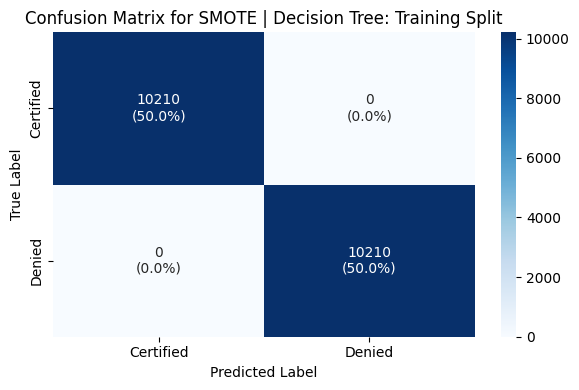

Classification Report for SMOTE | Decision Tree: Training Scores

              precision    recall  f1-score   support

   Certified       1.00      1.00      1.00     10210
      Denied       1.00      1.00      1.00     10210

    accuracy                           1.00     20420
   macro avg       1.00      1.00      1.00     20420
weighted avg       1.00      1.00      1.00     20420



In [ ]:
model_train_scores_df = evaluate_model(
    dt_model_smote, X_train_smote, y_train_smote, model_name='SMOTE | Decision Tree', scores_df=model_train_scores_df, label_encoder=le_smote, data_split="Training")


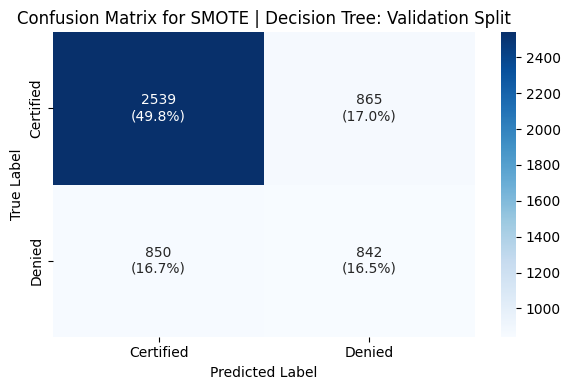

Classification Report for SMOTE | Decision Tree: Validation Scores

              precision    recall  f1-score   support

   Certified       0.75      0.75      0.75      3404
      Denied       0.49      0.50      0.50      1692

    accuracy                           0.66      5096
   macro avg       0.62      0.62      0.62      5096
weighted avg       0.66      0.66      0.66      5096



In [ ]:
model_val_scores_df = evaluate_model(
    dt_model_smote, X_val, y_val_enc, model_name='SMOTE | Decision Tree', scores_df=model_val_scores_df, label_encoder=le_smote, data_split="Validation")


In [ ]:
# 8. Random Forest (SMOTE)
rf_model_smote = RandomForestClassifier(random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

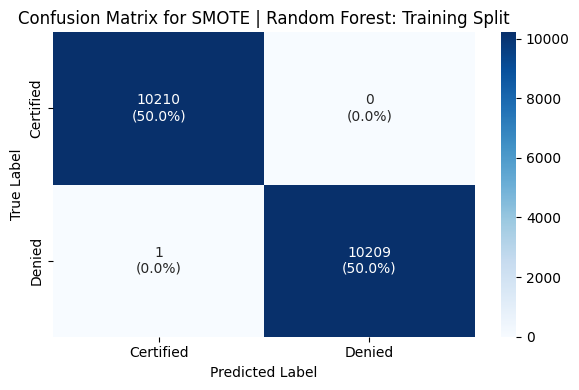

Classification Report for SMOTE | Random Forest: Training Scores

              precision    recall  f1-score   support

   Certified       1.00      1.00      1.00     10210
      Denied       1.00      1.00      1.00     10210

    accuracy                           1.00     20420
   macro avg       1.00      1.00      1.00     20420
weighted avg       1.00      1.00      1.00     20420



In [ ]:
model_train_scores_df = evaluate_model(
    rf_model_smote, X_train_smote, y_train_smote, model_name='SMOTE | Random Forest', scores_df=model_train_scores_df, label_encoder=le_smote,data_split="Training")

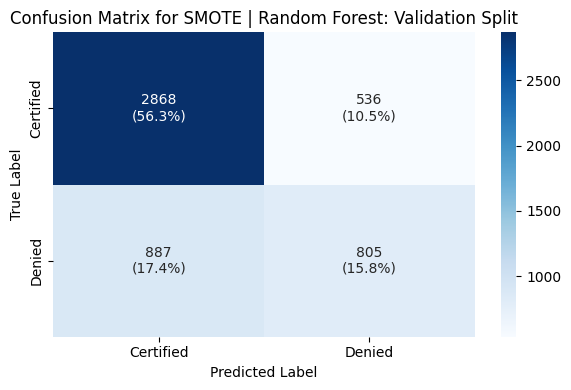

Classification Report for SMOTE | Random Forest: Validation Scores

              precision    recall  f1-score   support

   Certified       0.76      0.84      0.80      3404
      Denied       0.60      0.48      0.53      1692

    accuracy                           0.72      5096
   macro avg       0.68      0.66      0.67      5096
weighted avg       0.71      0.72      0.71      5096



In [ ]:
model_val_scores_df = evaluate_model(
    rf_model_smote, X_val, y_val_enc, model_name='SMOTE | Random Forest', scores_df=model_val_scores_df, label_encoder=le_smote,data_split="Validation")


In [ ]:
# 9. Bagging Classifier (SMOTE)
bag_model_smote = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bag_model_smote.fit(X_train_smote, y_train_smote)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50,
                  random_state=42)

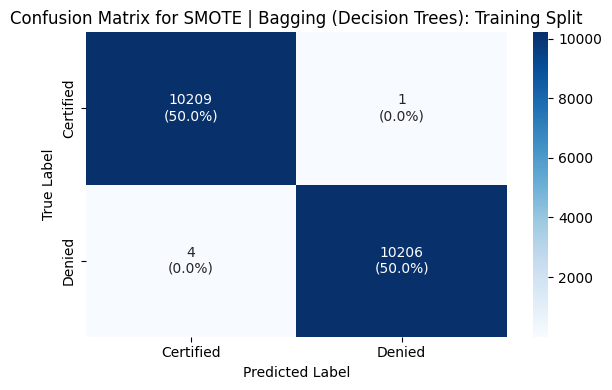

Classification Report for SMOTE | Bagging (Decision Trees): Training Scores

              precision    recall  f1-score   support

   Certified       1.00      1.00      1.00     10210
      Denied       1.00      1.00      1.00     10210

    accuracy                           1.00     20420
   macro avg       1.00      1.00      1.00     20420
weighted avg       1.00      1.00      1.00     20420



In [ ]:
model_train_scores_df = evaluate_model(
  bag_model_smote, X_train_smote, y_train_smote, model_name='SMOTE | Bagging (Decision Trees)', scores_df=model_train_scores_df, label_encoder=le_smote,data_split="Training")


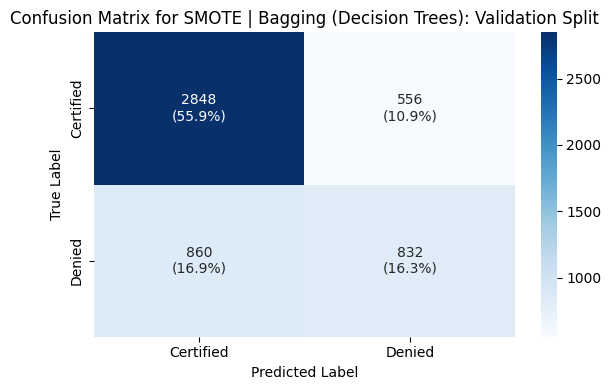

Classification Report for SMOTE | Bagging (Decision Trees): Validation Scores

              precision    recall  f1-score   support

   Certified       0.77      0.84      0.80      3404
      Denied       0.60      0.49      0.54      1692

    accuracy                           0.72      5096
   macro avg       0.68      0.66      0.67      5096
weighted avg       0.71      0.72      0.71      5096



In [ ]:
model_val_scores_df = evaluate_model(
  bag_model_smote, X_val, y_val_enc, model_name='SMOTE | Bagging (Decision Trees)', scores_df=model_val_scores_df, label_encoder=le_smote,data_split="Validation")

In [ ]:
# 10. AdaBoost (SMOTE)
ada_model_smote = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model_smote.fit(X_train_smote, y_train_smote)

AdaBoostClassifier(random_state=42)

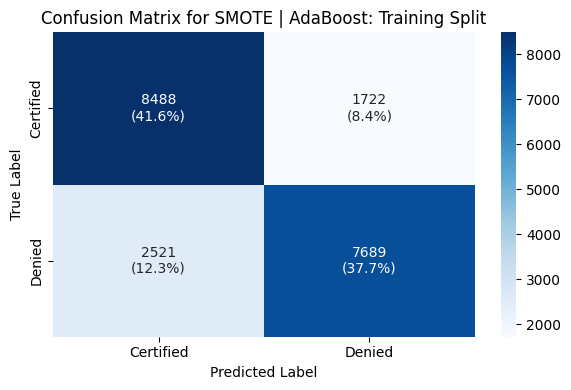

Classification Report for SMOTE | AdaBoost: Training Scores

              precision    recall  f1-score   support

   Certified       0.77      0.83      0.80     10210
      Denied       0.82      0.75      0.78     10210

    accuracy                           0.79     20420
   macro avg       0.79      0.79      0.79     20420
weighted avg       0.79      0.79      0.79     20420



In [ ]:
model_train_scores_df = evaluate_model(
    ada_model_smote, X_train_smote, y_train_smote, model_name='SMOTE | AdaBoost', scores_df=model_train_scores_df, label_encoder=le_smote,data_split="Training")


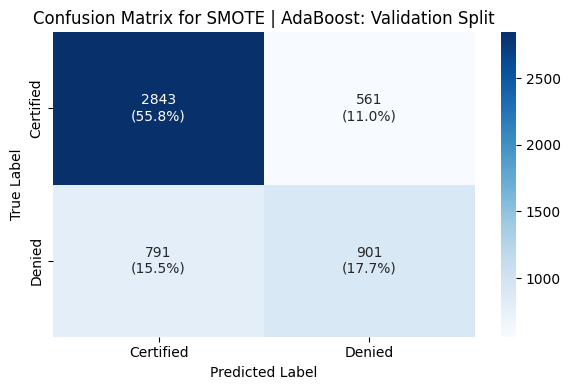

Classification Report for SMOTE | AdaBoost: Validation Scores

              precision    recall  f1-score   support

   Certified       0.78      0.84      0.81      3404
      Denied       0.62      0.53      0.57      1692

    accuracy                           0.73      5096
   macro avg       0.70      0.68      0.69      5096
weighted avg       0.73      0.73      0.73      5096



In [ ]:
model_val_scores_df = evaluate_model(
    ada_model_smote, X_val, y_val_enc, model_name='SMOTE | AdaBoost', scores_df=model_val_scores_df, label_encoder=le_smote,data_split="Validation")

In [ ]:
# 11. Gradient Boosting (SMOTE)
gb_model_smote = GradientBoostingClassifier(random_state=42)

gb_model_smote.fit(X_train_smote, y_train_smote)

GradientBoostingClassifier(random_state=42)

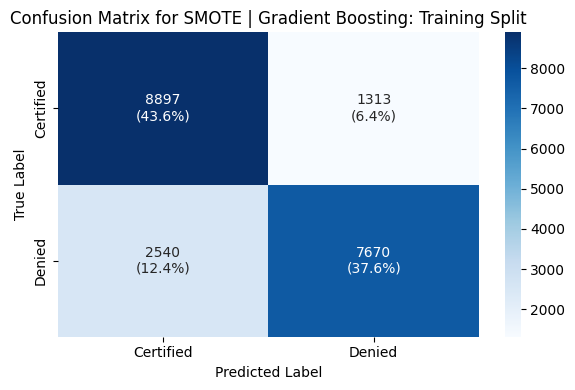

Classification Report for SMOTE | Gradient Boosting: Training Scores

              precision    recall  f1-score   support

   Certified       0.78      0.87      0.82     10210
      Denied       0.85      0.75      0.80     10210

    accuracy                           0.81     20420
   macro avg       0.82      0.81      0.81     20420
weighted avg       0.82      0.81      0.81     20420



In [ ]:
model_train_scores_df = evaluate_model(gb_model_smote, X_train_smote, y_train_smote,
                        model_name='SMOTE | Gradient Boosting', scores_df=model_train_scores_df,label_encoder=le_smote,data_split="Training")

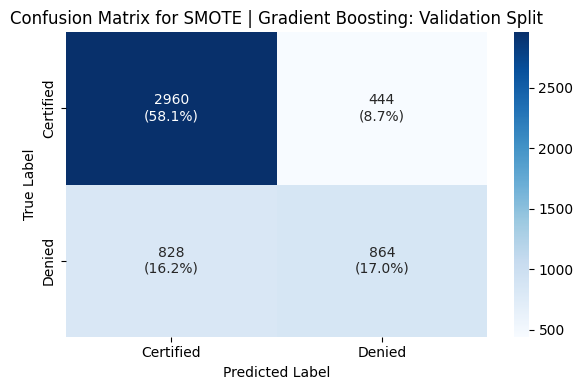

Classification Report for SMOTE | Gradient Boosting: Validation Scores

              precision    recall  f1-score   support

   Certified       0.78      0.87      0.82      3404
      Denied       0.66      0.51      0.58      1692

    accuracy                           0.75      5096
   macro avg       0.72      0.69      0.70      5096
weighted avg       0.74      0.75      0.74      5096



In [ ]:
model_val_scores_df = evaluate_model(gb_model_smote, X_val, y_val_enc, model_name='SMOTE | Gradient Boosting',
                                     scores_df=model_val_scores_df,label_encoder = le_smote,data_split="Validation")

In [ ]:
# 12. XGBoost (SMOTE)
xgb_model_smote = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_smote.fit(X_train_smote, y_train_smote)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

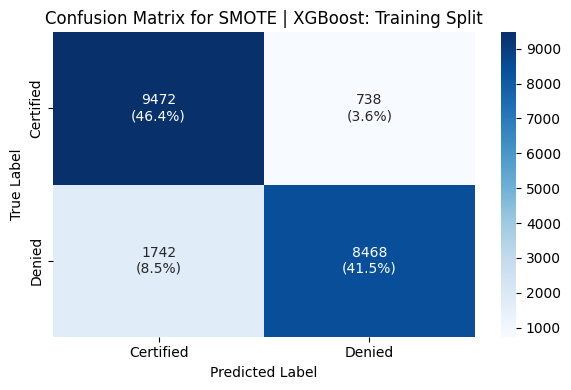

Classification Report for SMOTE | XGBoost: Training Scores

              precision    recall  f1-score   support

   Certified       0.84      0.93      0.88     10210
      Denied       0.92      0.83      0.87     10210

    accuracy                           0.88     20420
   macro avg       0.88      0.88      0.88     20420
weighted avg       0.88      0.88      0.88     20420



In [ ]:
model_train_scores_df = evaluate_model(
    xgb_model_smote, X_train_smote, y_train_smote, model_name='SMOTE | XGBoost', scores_df=model_train_scores_df, label_encoder=le_smote,data_split="Training")

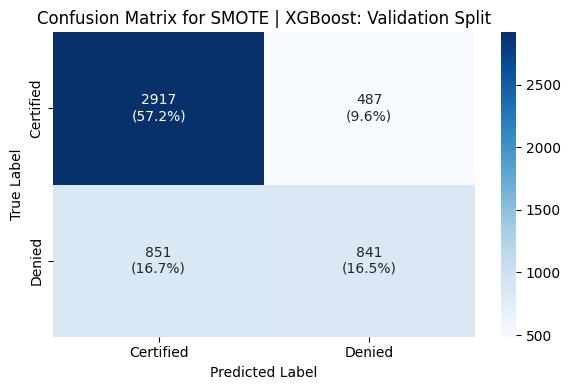

Classification Report for SMOTE | XGBoost: Validation Scores

              precision    recall  f1-score   support

   Certified       0.77      0.86      0.81      3404
      Denied       0.63      0.50      0.56      1692

    accuracy                           0.74      5096
   macro avg       0.70      0.68      0.69      5096
weighted avg       0.73      0.74      0.73      5096



In [ ]:
model_val_scores_df = evaluate_model(
    xgb_model_smote, X_val, y_val_enc, model_name='SMOTE | XGBoost', scores_df=model_val_scores_df, label_encoder=le_smote,data_split="Validation")

In [ ]:
# Show final comparison table (with SMOTE results)
print("\n Model Comparison Summary: Training Scores")
display(model_train_scores_df.sort_values(by='F1 Score', ascending=False))


 Model Comparison Summary: Training Scores


Model  Accuracy  Precision  Recall  F1 Score
0                      Decision Tree    1.0000     1.0000  1.0000    1.0000
7              SMOTE | Random Forest    1.0000     1.0000  1.0000    1.0000
6              SMOTE | Decision Tree    1.0000     1.0000  1.0000    1.0000
1                      Random Forest    0.9999     1.0000  0.9999    0.9999
8   SMOTE | Bagging (Decision Trees)    0.9998     0.9998  0.9998    0.9998
2           Bagging (Decision Trees)    0.9995     0.9997  0.9993    0.9995
11                   SMOTE | XGBoost    0.8786     0.8822  0.8786    0.8783
5                            XGBoost    0.8513     0.8501  0.8065    0.8222
10         SMOTE | Gradient Boosting    0.8113     0.8159  0.8113    0.8106
9                   SMOTE | AdaBoost    0.7922     0.7940  0.7922    0.7919
4                  Gradient Boosting    0.7578     0.7325  0.6948    0.7057
3                           AdaBoost    0.7386     0.7093  0.6659    0.6758

In [ ]:
# Show final comparison table (with SMOTE results)
print("\n Model Comparison Summary: Validation Scores")
display(model_val_scores_df.sort_values(by='F1 Score', ascending=False))


 Model Comparison Summary: Validation Scores


Model  Accuracy  Precision  Recall  F1 Score
10         SMOTE | Gradient Boosting    0.7504     0.7210  0.6901    0.6996
4                  Gradient Boosting    0.7524     0.7254  0.6876    0.6981
9                   SMOTE | AdaBoost    0.7347     0.6993  0.6838    0.6896
11                   SMOTE | XGBoost    0.7374     0.7037  0.6770    0.6852
3                           AdaBoost    0.7382     0.7092  0.6642    0.6741
5                            XGBoost    0.7325     0.6990  0.6637    0.6726
2           Bagging (Decision Trees)    0.7266     0.6899  0.6633    0.6709
8   SMOTE | Bagging (Decision Trees)    0.7221     0.6837  0.6642    0.6706
1                      Random Forest    0.7255     0.6883  0.6619    0.6695
7              SMOTE | Random Forest    0.7208     0.6820  0.6592    0.6660
6              SMOTE | Decision Tree    0.6635     0.6212  0.6218    0.6215
0                      Decision Tree    0.6652     0.6213  0.6200    0.6206

## Model Building - Using Undersampled Data

In [ ]:
# Encode the target
le_under = LabelEncoder()
y_train_enc_under = le_under.fit_transform(y_train)
y_val_enc_under = le_under.transform(y_val)

# Apply random undersampling
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train_enc_under)

print("Undersampling applied. Class distribution after balancing:")
print(pd.Series(y_train_under).value_counts())

Undersampling applied. Class distribution after balancing:
0    5078
1    5078
Name: count, dtype: int64


In [ ]:
#13. Decision Tree (Undersampling)
dt_model_under = DecisionTreeClassifier(random_state=42)
dt_model_under.fit(X_train_under, y_train_under)

DecisionTreeClassifier(random_state=42)

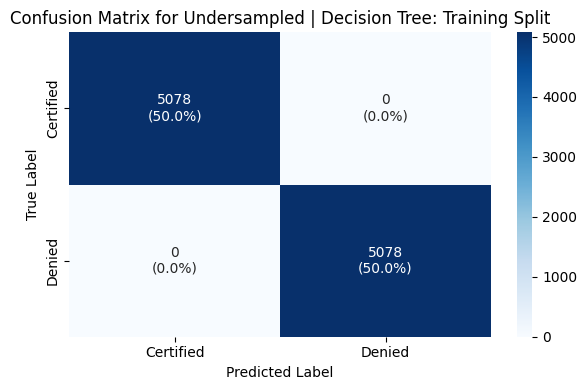

Classification Report for Undersampled | Decision Tree: Training Scores

              precision    recall  f1-score   support

   Certified       1.00      1.00      1.00      5078
      Denied       1.00      1.00      1.00      5078

    accuracy                           1.00     10156
   macro avg       1.00      1.00      1.00     10156
weighted avg       1.00      1.00      1.00     10156



In [ ]:
model_train_scores_df = evaluate_model(dt_model_under, X_train_under, y_train_under,
    model_name='Undersampled | Decision Tree',scores_df=model_train_scores_df,label_encoder=le_under,data_split="Training")

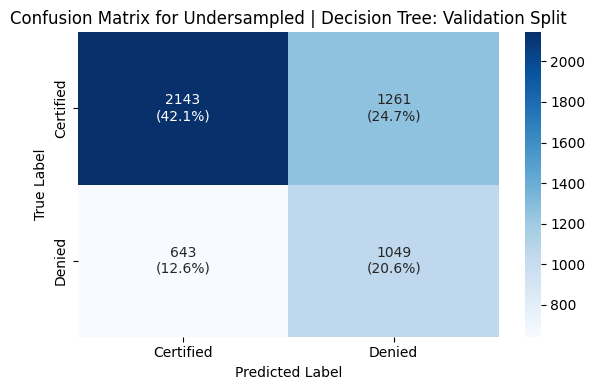

Classification Report for Undersampled | Decision Tree: Validation Scores

              precision    recall  f1-score   support

   Certified       0.77      0.63      0.69      3404
      Denied       0.45      0.62      0.52      1692

    accuracy                           0.63      5096
   macro avg       0.61      0.62      0.61      5096
weighted avg       0.66      0.63      0.64      5096



In [ ]:
model_val_scores_df = evaluate_model(dt_model_under, X_val, y_val_enc_under,
    model_name='Undersampled | Decision Tree',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Validation")

In [ ]:
#14. Random Forest (Undersampling)
rf_model_under = RandomForestClassifier(random_state=42)
rf_model_under.fit(X_train_under, y_train_under)

RandomForestClassifier(random_state=42)

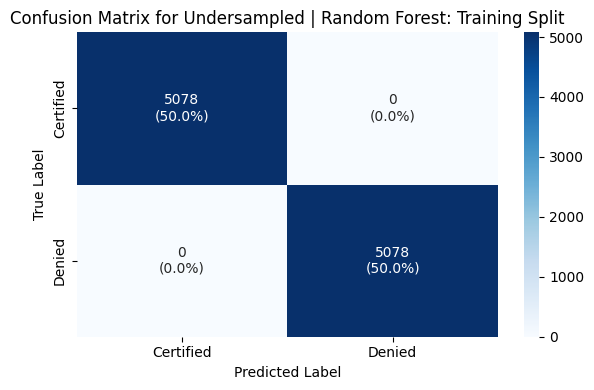

Classification Report for Undersampled | Random Forest: Training Scores

              precision    recall  f1-score   support

   Certified       1.00      1.00      1.00      5078
      Denied       1.00      1.00      1.00      5078

    accuracy                           1.00     10156
   macro avg       1.00      1.00      1.00     10156
weighted avg       1.00      1.00      1.00     10156



In [ ]:
model_train_scores_df = evaluate_model(rf_model_under, X_train_under, y_train_under,
    model_name='Undersampled | Random Forest',scores_df=model_train_scores_df,label_encoder=le_under,data_split="Training")

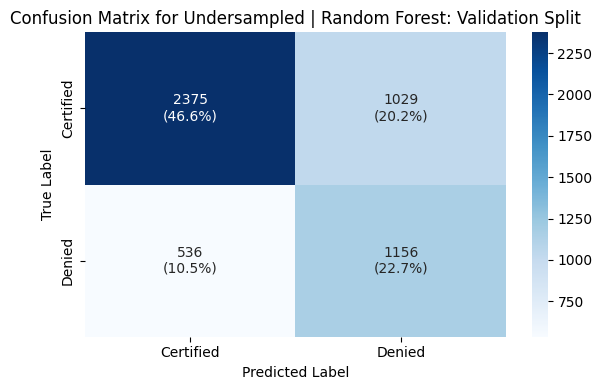

Classification Report for Undersampled | Random Forest: Validation Scores

              precision    recall  f1-score   support

   Certified       0.82      0.70      0.75      3404
      Denied       0.53      0.68      0.60      1692

    accuracy                           0.69      5096
   macro avg       0.67      0.69      0.67      5096
weighted avg       0.72      0.69      0.70      5096



In [ ]:
model_val_scores_df = evaluate_model(rf_model_under, X_val, y_val_enc_under,
    model_name='Undersampled | Random Forest',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Validation")

In [ ]:
#15. Bagging Classifier (Undersampling)
bag_model_under = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bag_model_under.fit(X_train_under, y_train_under)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50,
                  random_state=42)

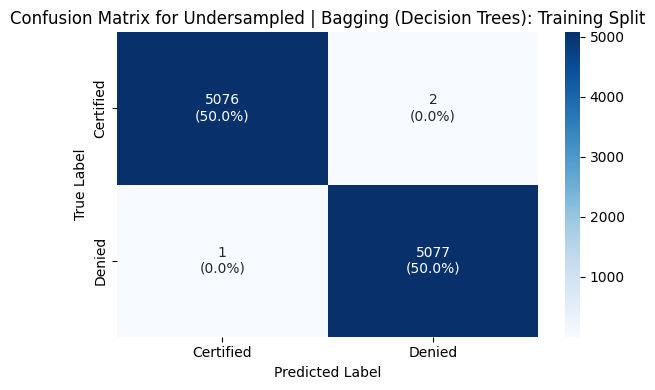

Classification Report for Undersampled | Bagging (Decision Trees): Training Scores

              precision    recall  f1-score   support

   Certified       1.00      1.00      1.00      5078
      Denied       1.00      1.00      1.00      5078

    accuracy                           1.00     10156
   macro avg       1.00      1.00      1.00     10156
weighted avg       1.00      1.00      1.00     10156



In [ ]:
# Track training and validation scores separately
model_train_scores_df = evaluate_model(bag_model_under, X_train_under, y_train_under,
    model_name='Undersampled | Bagging (Decision Trees)',scores_df=model_train_scores_df,label_encoder=le_under,data_split="Training")

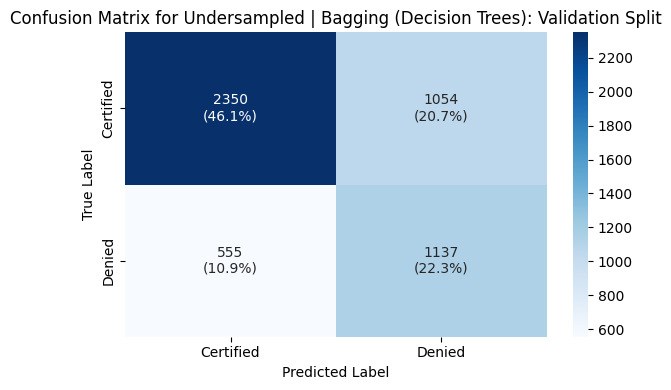

Classification Report for Undersampled | Bagging (Decision Trees): Validation Scores

              precision    recall  f1-score   support

   Certified       0.81      0.69      0.74      3404
      Denied       0.52      0.67      0.59      1692

    accuracy                           0.68      5096
   macro avg       0.66      0.68      0.67      5096
weighted avg       0.71      0.68      0.69      5096



In [ ]:
model_val_scores_df = evaluate_model(bag_model_under, X_val, y_val_enc_under,
    model_name='Undersampled | Bagging (Decision Trees)',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Validation")

In [ ]:
#16. AdaBoost (Undersampling)
ada_model_under = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model_under.fit(X_train_under, y_train_under)

AdaBoostClassifier(random_state=42)

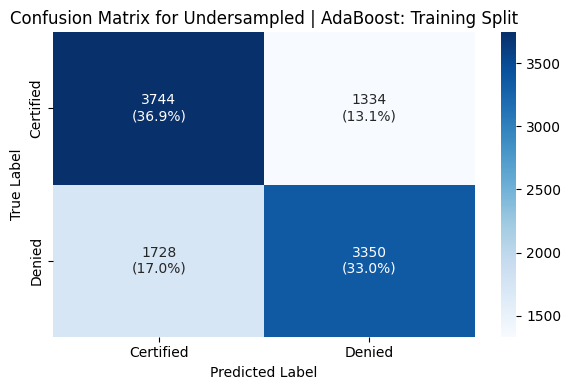

Classification Report for Undersampled | AdaBoost: Training Scores

              precision    recall  f1-score   support

   Certified       0.68      0.74      0.71      5078
      Denied       0.72      0.66      0.69      5078

    accuracy                           0.70     10156
   macro avg       0.70      0.70      0.70     10156
weighted avg       0.70      0.70      0.70     10156



In [ ]:
model_train_scores_df = evaluate_model(
    ada_model_under, X_train_under, y_train_under,model_name='Undersampled | AdaBoost',scores_df=model_train_scores_df,label_encoder=le_under,data_split="Training")

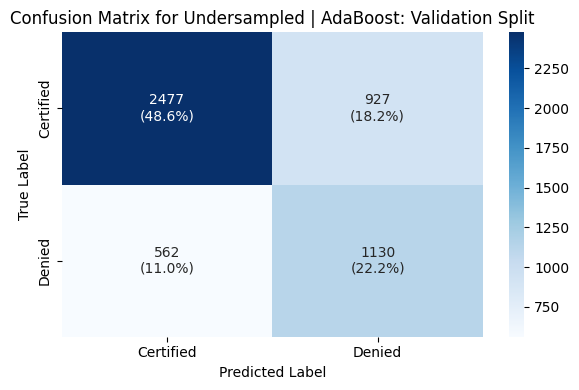

Classification Report for Undersampled | AdaBoost: Validation Scores

              precision    recall  f1-score   support

   Certified       0.82      0.73      0.77      3404
      Denied       0.55      0.67      0.60      1692

    accuracy                           0.71      5096
   macro avg       0.68      0.70      0.69      5096
weighted avg       0.73      0.71      0.71      5096



In [ ]:
model_val_scores_df = evaluate_model(ada_model_under, X_val, y_val_enc_under,
    model_name='Undersampled | AdaBoost',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Validation")

In [ ]:
# 17. Gradient Boosting (SMOTE)
gb_model_under = GradientBoostingClassifier(random_state=42)

gb_model_under.fit(X_train_under, y_train_under)

GradientBoostingClassifier(random_state=42)

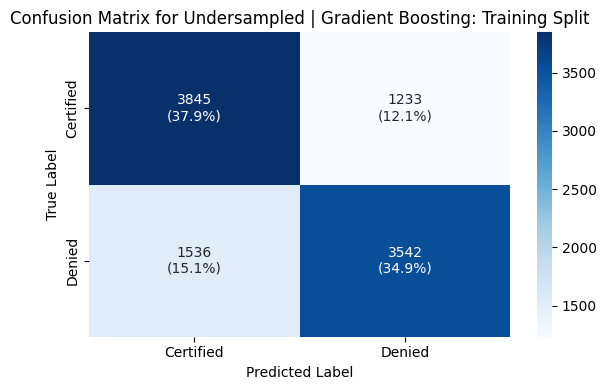

Classification Report for Undersampled | Gradient Boosting: Training Scores

              precision    recall  f1-score   support

   Certified       0.71      0.76      0.74      5078
      Denied       0.74      0.70      0.72      5078

    accuracy                           0.73     10156
   macro avg       0.73      0.73      0.73     10156
weighted avg       0.73      0.73      0.73     10156



In [ ]:
model_train_scores_df = evaluate_model(
    gb_model_under, X_train_under, y_train_under,model_name='Undersampled | Gradient Boosting',scores_df=model_train_scores_df,label_encoder=le_under,data_split="Training")

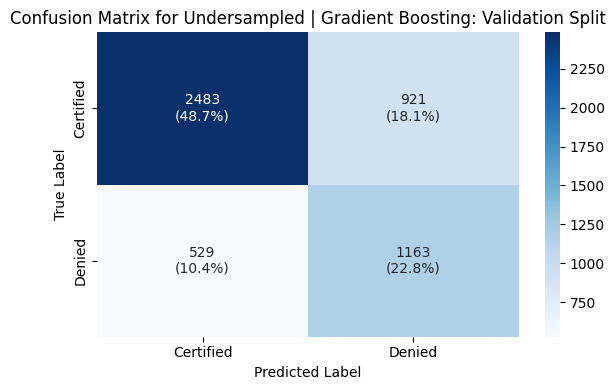

Classification Report for Undersampled | Gradient Boosting: Validation Scores

              precision    recall  f1-score   support

   Certified       0.82      0.73      0.77      3404
      Denied       0.56      0.69      0.62      1692

    accuracy                           0.72      5096
   macro avg       0.69      0.71      0.69      5096
weighted avg       0.74      0.72      0.72      5096



In [ ]:
model_val_scores_df = evaluate_model(gb_model_under,
            X_val, y_val_enc_under,model_name='Undersampled | Gradient Boosting',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Validation")

In [ ]:
#18. XGBoost
xgb_model_under = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_under.fit(X_train_under, y_train_under)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

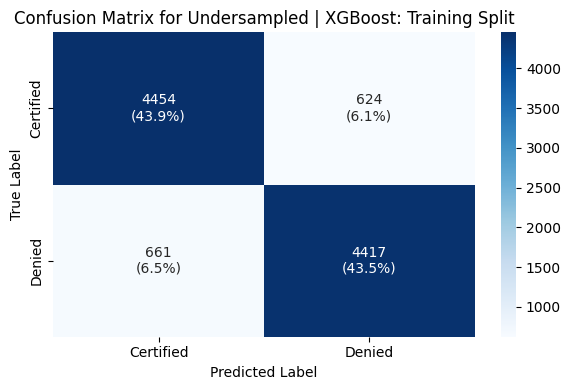

Classification Report for Undersampled | XGBoost: Training Scores

              precision    recall  f1-score   support

   Certified       0.87      0.88      0.87      5078
      Denied       0.88      0.87      0.87      5078

    accuracy                           0.87     10156
   macro avg       0.87      0.87      0.87     10156
weighted avg       0.87      0.87      0.87     10156



In [ ]:
model_train_scores_df = evaluate_model(xgb_model_under, X_train_under, y_train_under,
    model_name='Undersampled | XGBoost',scores_df=model_train_scores_df,label_encoder=le_under,data_split="Training"
)

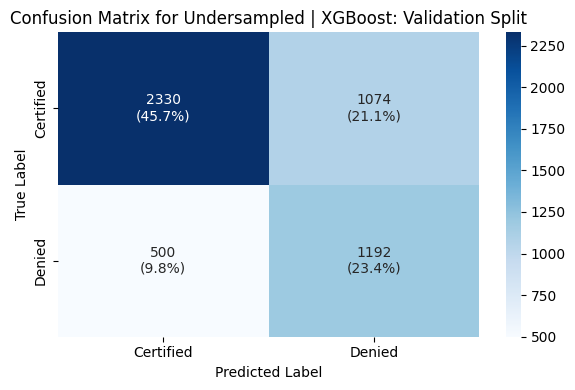

Classification Report for Undersampled | XGBoost: Validation Scores

              precision    recall  f1-score   support

   Certified       0.82      0.68      0.75      3404
      Denied       0.53      0.70      0.60      1692

    accuracy                           0.69      5096
   macro avg       0.67      0.69      0.67      5096
weighted avg       0.72      0.69      0.70      5096



In [ ]:

model_val_scores_df = evaluate_model(xgb_model_under, X_val, y_val_enc_under,
    model_name='Undersampled | XGBoost',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Validation")

In [ ]:
# Show final comparison table (with SMOTE & Undersampling results)
print("\n Model Comparison Summary: Training Scores")
display(model_train_scores_df.sort_values(by='F1 Score', ascending=False))


 Model Comparison Summary: Training Scores


Model  Accuracy  Precision  Recall  \
0                             Decision Tree    1.0000     1.0000  1.0000   
7                     SMOTE | Random Forest    1.0000     1.0000  1.0000   
12             Undersampled | Decision Tree    1.0000     1.0000  1.0000   
6                     SMOTE | Decision Tree    1.0000     1.0000  1.0000   
13             Undersampled | Random Forest    1.0000     1.0000  1.0000   
1                             Random Forest    0.9999     1.0000  0.9999   
8          SMOTE | Bagging (Decision Trees)    0.9998     0.9998  0.9998   
14  Undersampled | Bagging (Decision Trees)    0.9997     0.9997  0.9997   
2                  Bagging (Decision Trees)    0.9995     0.9997  0.9993   
11                          SMOTE | XGBoost    0.8786     0.8822  0.8786   
17                   Undersampled | XGBoost    0.8735     0.8735  0.8735   
5                                   XGBoost    0.8513     0.8501  0.8065   
10                SMOTE | Gradient Boosting    0.8113     0.8159  0.8113   
9                          SMOTE | AdaBoost    0.7922     0.7940  0.7922   
16         Undersampled | Gradient Boosting    0.7274     0.7282  0.7274   
4                         Gradient Boosting    0.7578     0.7325  0.6948   
15                  Undersampled | AdaBoost    0.6985     0.6997  0.6985   
3                                  AdaBoost    0.7386     0.7093  0.6659   

    F1 Score  
0     1.0000  
7     1.0000  
12    1.0000  
6     1.0000  
13    1.0000  
1     0.9999  
8     0.9998  
14    0.9997  
2     0.9995  
11    0.8783  
17    0.8735  
5     0.8222  
10    0.8106  
9     0.7919  
16    0.7271  
4     0.7057  
15    0.6980  
3     0.6758

In [ ]:
# Show final comparison table (with SMOTE & Undersampling results)
print("\n Model Comparison Summary: Validation Scores")
display(model_val_scores_df.sort_values(by='F1 Score', ascending=False))


 Model Comparison Summary: Validation Scores


Model  Accuracy  Precision  Recall  \
10                SMOTE | Gradient Boosting    0.7504     0.7210  0.6901   
4                         Gradient Boosting    0.7524     0.7254  0.6876   
16         Undersampled | Gradient Boosting    0.7155     0.6912  0.7084   
9                          SMOTE | AdaBoost    0.7347     0.6993  0.6838   
15                  Undersampled | AdaBoost    0.7078     0.6822  0.6978   
11                          SMOTE | XGBoost    0.7374     0.7037  0.6770   
17                   Undersampled | XGBoost    0.6911     0.6747  0.6945   
13             Undersampled | Random Forest    0.6929     0.6725  0.6905   
3                                  AdaBoost    0.7382     0.7092  0.6642   
5                                   XGBoost    0.7325     0.6990  0.6637   
2                  Bagging (Decision Trees)    0.7266     0.6899  0.6633   
8          SMOTE | Bagging (Decision Trees)    0.7221     0.6837  0.6642   
1                             Random Forest    0.7255     0.6883  0.6619   
7                     SMOTE | Random Forest    0.7208     0.6820  0.6592   
14  Undersampled | Bagging (Decision Trees)    0.6843     0.6639  0.6812   
6                     SMOTE | Decision Tree    0.6635     0.6212  0.6218   
0                             Decision Tree    0.6652     0.6213  0.6200   
12             Undersampled | Decision Tree    0.6264     0.6117  0.6248   

    F1 Score  
10    0.6996  
4     0.6981  
16    0.6950  
9     0.6896  
15    0.6859  
11    0.6852  
17    0.6749  
13    0.6743  
3     0.6741  
5     0.6726  
2     0.6709  
8     0.6706  
1     0.6695  
7     0.6660  
14    0.6653  
6     0.6215  
0     0.6206  
12    0.6083

### **Key Observations & Conclusions**

**Models Built**:
The following models were built for the classification solution - Decision Tree, Random Forest, Bagging Classifier (Using Decision Tree), Gradient Boosting, AdaBoosting & XGBoosting

**Target Class Sampling**:
Model building has been done on 3 different sets of data based on sampling of the target class i.e "case_status" - Original target class size, oversampled target class (denied cases) using SMOTE & undersampling target class (certified cases) using Random Undersampler

**Model Performance Overview:**
- It is to be noted that across the 2 target classes to predict i.e denied and certified, denied class has lesser obversations in general and as a result, has a lower scores and more challenging to predict accurately.
- Across original, undersampled and oversampled classes models - Single Decision tree & bagging models seem to have performed perfectly but overfit on training sets but undersampled by a huge margin on the validation sets, based on f1 scores
- Boosting techniques seems to have generalized better across both training & validation datasets.

**Conclusion & Next Steps**:
Based on performance & generalization across training and validation, we see Gradient Boosting models (SMOTE, original target class & undersampled) have consistent 69-71% f1 scores and hence will be used for hyperparameter tuning


## HYPERPARAMETER TUNING

In [ ]:
param_grid_gb_smote = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 4, 6]
}

param_dist_gb_smote = {
    'n_estimators': np.arange(50, 151, 10),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 4, 6, 8, 10]
}


In [ ]:
gb_smote_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb_smote,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)
gb_smote_grid.fit(X_train_smote, y_train_smote)
print("GridSearch | SMOTE | Gradient Boosting:", gb_smote_grid.best_params_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
GridSearch | SMOTE | Gradient Boosting → {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 50, 'subsample': 0.8}


In [ ]:
best_gb_smote_grid = gb_smote_grid.best_estimator_

In [ ]:
joblib.dump(best_gb_smote_grid, 'best_gb_smote_grid.pkl')

['best_gb_smote_grid.pkl']

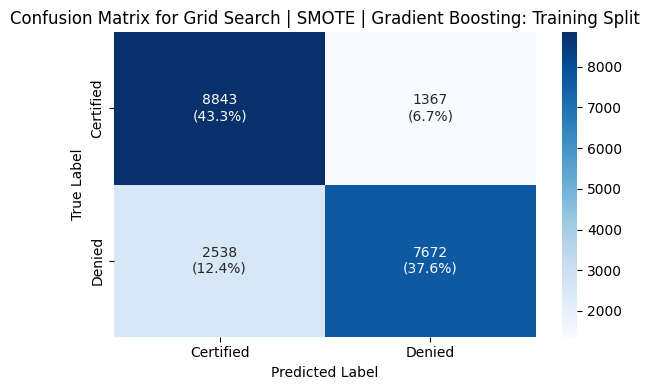

Classification Report for Grid Search | SMOTE | Gradient Boosting: Training Scores

              precision    recall  f1-score   support

   Certified       0.78      0.87      0.82     10210
      Denied       0.85      0.75      0.80     10210

    accuracy                           0.81     20420
   macro avg       0.81      0.81      0.81     20420
weighted avg       0.81      0.81      0.81     20420



In [ ]:
model_train_scores_df = evaluate_model(best_gb_smote_grid, X_train_smote, y_train_smote,
    model_name='Grid Search | SMOTE | Gradient Boosting',scores_df=model_train_scores_df,label_encoder=le_under,data_split="Training"
)

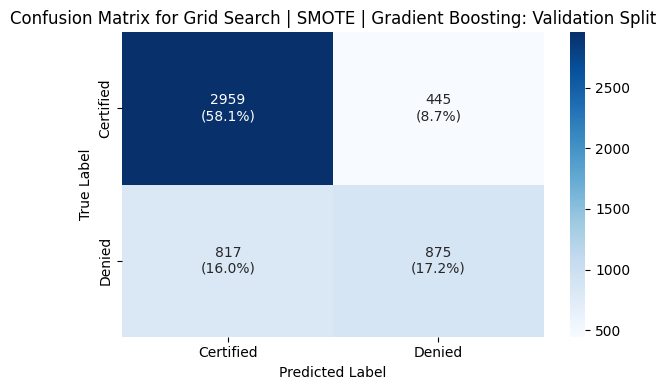

Classification Report for Grid Search | SMOTE | Gradient Boosting: Validation Scores

              precision    recall  f1-score   support

   Certified       0.78      0.87      0.82      3404
      Denied       0.66      0.52      0.58      1692

    accuracy                           0.75      5096
   macro avg       0.72      0.69      0.70      5096
weighted avg       0.74      0.75      0.74      5096



In [ ]:
model_val_scores_df = evaluate_model(best_gb_smote_grid, X_val, y_val_enc,
    model_name='Grid Search | SMOTE | Gradient Boosting',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Validation"
)

In [ ]:
gb_smote_random = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb_smote,
    scoring='f1_macro',
    n_iter=25,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
gb_smote_random.fit(X_train_smote, y_train_smote)
print("RandomSearch | SMOTE | Gradient Boosting:", gb_smote_random.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
RandomSearch | SMOTE | Gradient Boosting: {'subsample': 1.0, 'n_estimators': np.int64(70), 'min_samples_split': 8, 'max_depth': 4, 'learning_rate': np.float64(0.07333333333333333)}


In [ ]:
best_gb_smote_random = gb_smote_random.best_estimator_

In [ ]:
joblib.dump(best_gb_smote_random, 'best_gb_smote_random.pkl')

['best_gb_smote_random.pkl']

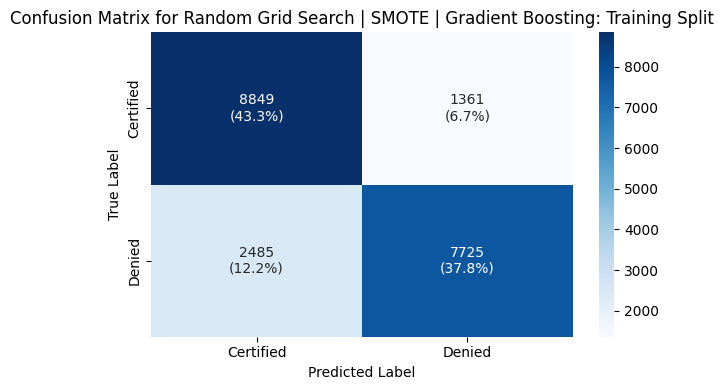

Classification Report for Random Grid Search | SMOTE | Gradient Boosting: Training Scores

              precision    recall  f1-score   support

   Certified       0.78      0.87      0.82     10210
      Denied       0.85      0.76      0.80     10210

    accuracy                           0.81     20420
   macro avg       0.82      0.81      0.81     20420
weighted avg       0.82      0.81      0.81     20420



In [ ]:
model_train_scores_df = evaluate_model(best_gb_smote_random, X_train_smote, y_train_smote,
    model_name='Random Grid Search | SMOTE | Tuned Gradient Boosting',scores_df=model_train_scores_df,label_encoder=le_under,data_split="Training"
)

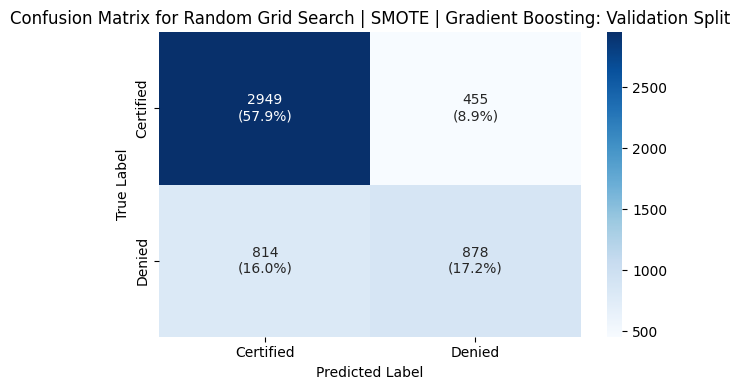

Classification Report for Random Grid Search | SMOTE | Gradient Boosting: Validation Scores

              precision    recall  f1-score   support

   Certified       0.78      0.87      0.82      3404
      Denied       0.66      0.52      0.58      1692

    accuracy                           0.75      5096
   macro avg       0.72      0.69      0.70      5096
weighted avg       0.74      0.75      0.74      5096



In [ ]:
model_val_scores_df = evaluate_model(best_gb_smote_random, X_val, y_val_enc,
    model_name='Random Grid Search | SMOTE | Tuned Gradient Boosting',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Validation"
)

In [ ]:
gb_orig_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb_smote,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)
gb_orig_grid.fit(X_train, y_train)
print("GridSearch | Original | Gradient Boosting:", gb_orig_grid.best_params_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
GridSearch | Original | Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}


In [ ]:
gb_orig_grid_best = gb_orig_grid.best_estimator_

In [ ]:
joblib.dump(gb_orig_grid_best, 'gb_orig_grid_best.pkl')

['gb_orig_grid_best.pkl']

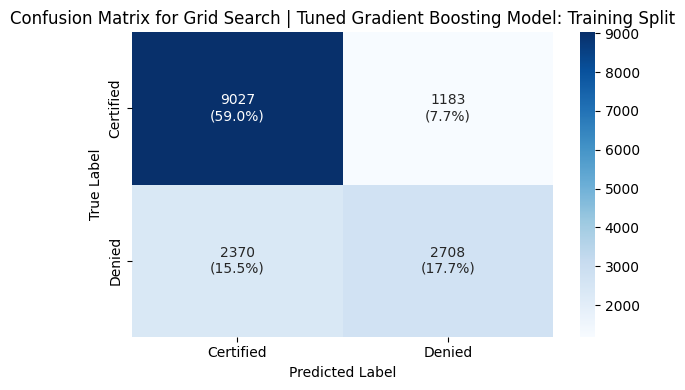

Classification Report for Grid Search | Tuned Gradient Boosting Model: Training Scores

              precision    recall  f1-score   support

   Certified       0.79      0.88      0.84     10210
      Denied       0.70      0.53      0.60      5078

    accuracy                           0.77     15288
   macro avg       0.74      0.71      0.72     15288
weighted avg       0.76      0.77      0.76     15288



In [ ]:
model_train_scores_df = evaluate_model(gb_orig_grid_best, X_train, y_train, model_name='Grid Search | Tuned Gradient Boosting Model', scores_df=model_train_scores_df, data_split="Training")

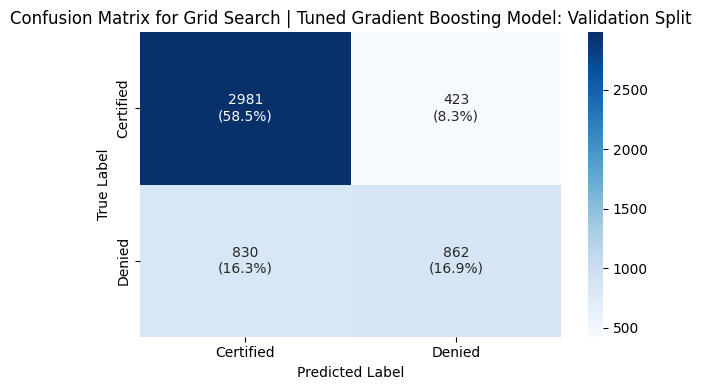

Classification Report for Grid Search | Tuned Gradient Boosting Model: Validation Scores

              precision    recall  f1-score   support

   Certified       0.78      0.88      0.83      3404
      Denied       0.67      0.51      0.58      1692

    accuracy                           0.75      5096
   macro avg       0.73      0.69      0.70      5096
weighted avg       0.75      0.75      0.74      5096



In [ ]:
model_val_scores_df = evaluate_model(gb_orig_grid_best, X_val, y_val, model_name='Grid Search | Tuned Gradient Boosting Model', scores_df=model_val_scores_df, data_split="Validation")

In [ ]:
gb_orig_random = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb_smote,
    scoring='f1_macro',
    n_iter=25,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
gb_orig_random.fit(X_train, y_train)
print("RandomSearch | Original | Gradient BoostingL", gb_orig_random.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
RandomSearch | Original | Gradient BoostingL {'subsample': 1.0, 'n_estimators': np.int64(70), 'min_samples_split': 8, 'max_depth': 4, 'learning_rate': np.float64(0.07333333333333333)}


In [ ]:
gb_orig_random_best = gb_orig_random.best_estimator_

In [ ]:
joblib.dump(gb_orig_random_best, 'gb_orig_random_best.pkl')

['gb_orig_random_best.pkl']

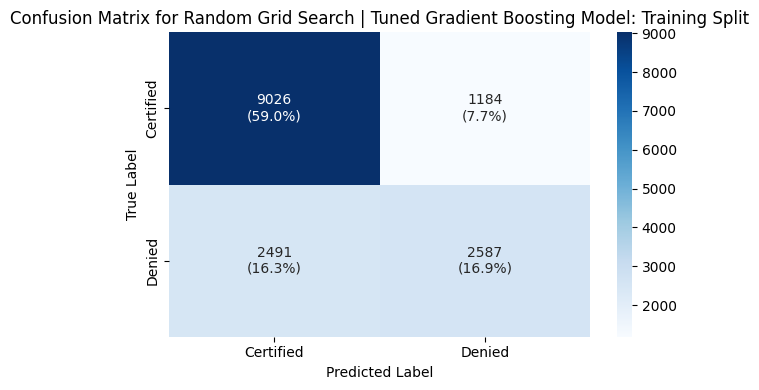

Classification Report for Random Grid Search | Tuned Gradient Boosting Model: Training Scores

              precision    recall  f1-score   support

   Certified       0.78      0.88      0.83     10210
      Denied       0.69      0.51      0.58      5078

    accuracy                           0.76     15288
   macro avg       0.73      0.70      0.71     15288
weighted avg       0.75      0.76      0.75     15288



In [ ]:
model_train_scores_df = evaluate_model(gb_orig_random_best, X_train, y_train, model_name='Random Grid Search | Tuned Gradient Boosting Model', scores_df=model_train_scores_df, data_split="Training")

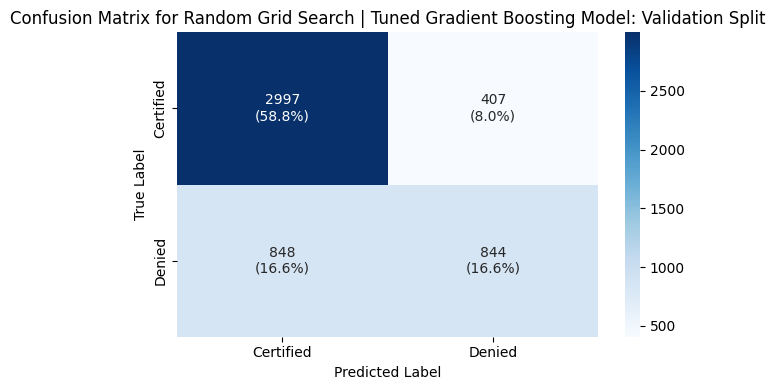

Classification Report for Random Grid Search | Tuned Gradient Boosting Model: Validation Scores

              precision    recall  f1-score   support

   Certified       0.78      0.88      0.83      3404
      Denied       0.67      0.50      0.57      1692

    accuracy                           0.75      5096
   macro avg       0.73      0.69      0.70      5096
weighted avg       0.74      0.75      0.74      5096



In [ ]:
model_val_scores_df = evaluate_model(gb_orig_random_best, X_val, y_val, model_name='Random Grid Search | Tuned Gradient Boosting Model', scores_df=model_val_scores_df, data_split="Validation")

In [ ]:
gb_under_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb_smote,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=1
)
gb_under_grid.fit(X_train_under, y_train_under)
print("GridSearch | Undersampled | Gradient Boosting:", gb_under_grid.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
GridSearch | Undersampled | Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 150, 'subsample': 1.0}


In [ ]:
gb_under_grid_best = gb_under_grid.best_estimator_

In [ ]:
joblib.dump(gb_under_grid_best, 'gb_under_grid_best.pkl')

['gb_under_grid_best.pkl']

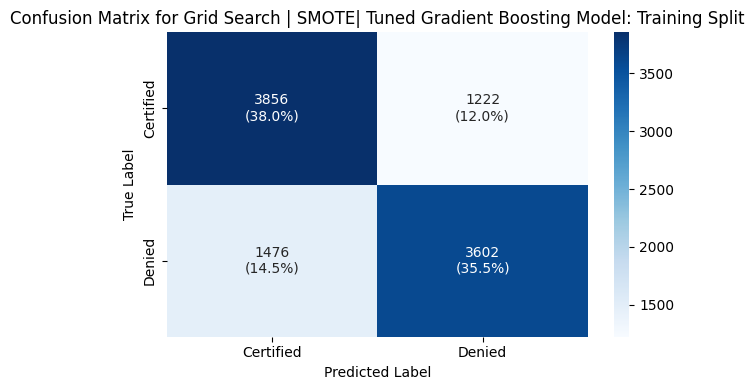

Classification Report for Grid Search | SMOTE| Tuned Gradient Boosting Model: Training Scores

              precision    recall  f1-score   support

   Certified       0.72      0.76      0.74      5078
      Denied       0.75      0.71      0.73      5078

    accuracy                           0.73     10156
   macro avg       0.73      0.73      0.73     10156
weighted avg       0.73      0.73      0.73     10156



In [ ]:
model_train_scores_df = evaluate_model(gb_under_grid_best,
                        X_train_under, y_train_under, model_name='Grid Search | SMOTE| Tuned Gradient Boosting Model', scores_df=model_train_scores_df, data_split="Training",label_encoder=le_under)

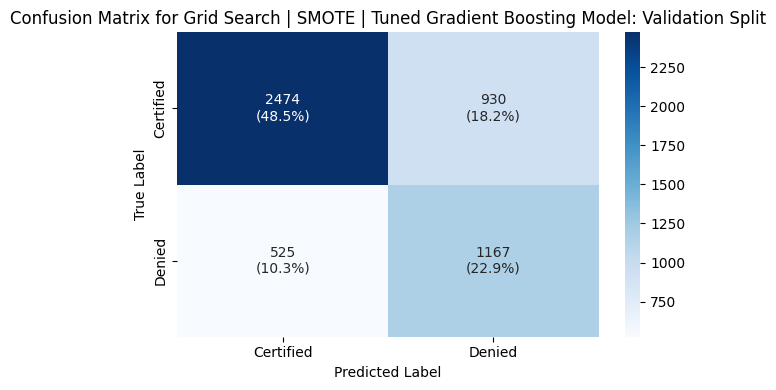

Classification Report for Grid Search | SMOTE | Tuned Gradient Boosting Model: Validation Scores

              precision    recall  f1-score   support

   Certified       0.82      0.73      0.77      3404
      Denied       0.56      0.69      0.62      1692

    accuracy                           0.71      5096
   macro avg       0.69      0.71      0.69      5096
weighted avg       0.74      0.71      0.72      5096



In [ ]:
model_val_scores_df = evaluate_model(gb_under_grid_best, X_val, y_val_enc_under,
                        model_name='Grid Search | SMOTE | Tuned Gradient Boosting Model', scores_df=model_val_scores_df, data_split="Validation",label_encoder=le_under)

In [ ]:
gb_under_random = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_dist_gb_smote,
    scoring='f1_macro',
    n_iter=25,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
gb_under_random.fit(X_train_under, y_train_under)
print("RandomSearch | Undersampled | Gradient Boosting:", gb_under_random.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
RandomSearch | Undersampled | Gradient Boosting: {'subsample': 1.0, 'n_estimators': np.int64(100), 'min_samples_split': 6, 'max_depth': 3, 'learning_rate': np.float64(0.07333333333333333)}


In [ ]:
gb_under_random_best = gb_under_random.best_estimator_

In [ ]:
joblib.dump(gb_under_random_best, 'gb_under_random_best.pkl')

['gb_under_random_best.pkl']

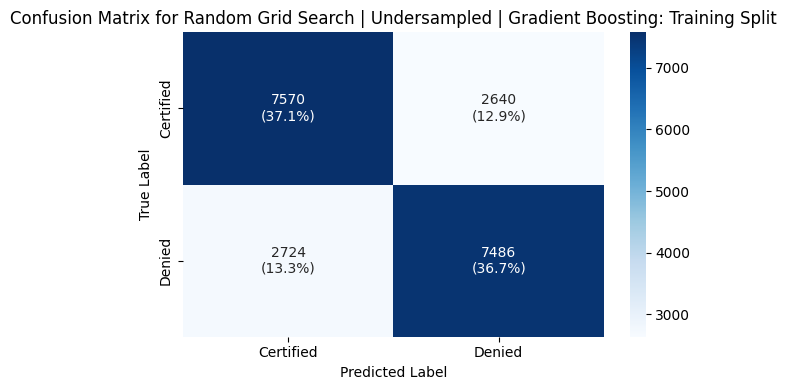

Classification Report for Random Grid Search | Undersampled | Gradient Boosting: Training Scores

              precision    recall  f1-score   support

   Certified       0.74      0.74      0.74     10210
      Denied       0.74      0.73      0.74     10210

    accuracy                           0.74     20420
   macro avg       0.74      0.74      0.74     20420
weighted avg       0.74      0.74      0.74     20420



In [ ]:
model_train_scores_df = evaluate_model(gb_under_random_best, X_train_smote, y_train_smote,
    model_name='Random Grid Search | Undersampled | Tuned Gradient Boosting',scores_df=model_train_scores_df,label_encoder=le_under,data_split="Training"
)

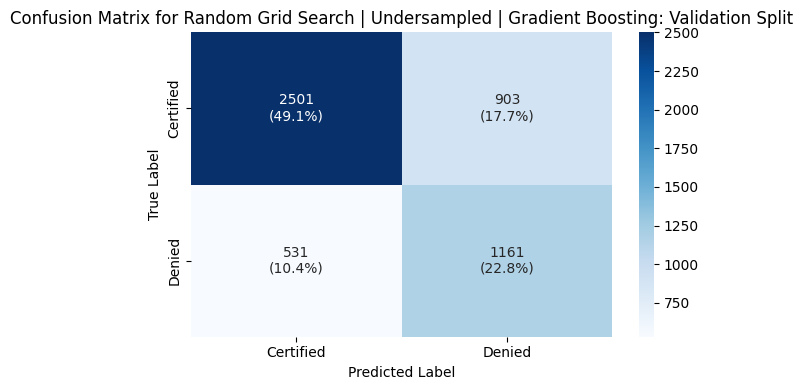

Classification Report for Random Grid Search | Undersampled | Gradient Boosting: Validation Scores

              precision    recall  f1-score   support

   Certified       0.82      0.73      0.78      3404
      Denied       0.56      0.69      0.62      1692

    accuracy                           0.72      5096
   macro avg       0.69      0.71      0.70      5096
weighted avg       0.74      0.72      0.72      5096



In [ ]:
model_val_scores_df = evaluate_model(gb_under_random_best, X_val, y_val_enc_under,
    model_name='Random Grid Search | Undersampled | Tuned Gradient Boosting',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Validation")

In [ ]:
print("\n Model Comparison Summary: Train Scores\n")
display(model_train_scores_df[model_train_scores_df.Model.str.contains("Grid")].sort_values(by="F1 Score",ascending=False))


 Model Comparison Summary: Train Scores



Model  Accuracy  Precision  \
19     Random Grid Search | SMOTE | Gradient Boosting    0.8117     0.8155   
18            Grid Search | SMOTE | Gradient Boosting    0.8088     0.8129   
24  Random Grid Search | Undersampled | Gradient B...    0.7373     0.7373   
23  Grid Search | SMOTE| Tuned Gradient Boosting M...    0.7343     0.7349   
21        Grid Search | Tuned Gradient Boosting Model    0.7676     0.7440   
22  Random Grid Search | Tuned Gradient Boosting M...    0.7596     0.7349   

    Recall  F1 Score  
19  0.8117    0.8111  
18  0.8088    0.8081  
24  0.7373    0.7373  
23  0.7343    0.7342  
21  0.7087    0.7197  
22  0.6967    0.7078

In [ ]:
print("\n Model Comparison Summary: Validation Scores\n")
display(model_val_scores_df[model_val_scores_df.Model.str.contains("Grid")].sort_values(by="F1 Score",ascending=False))


 Model Comparison Summary: Validation Scores



Model  Accuracy  Precision  \
20        Grid Search | Tuned Gradient Boosting Model    0.7541     0.7265   
18            Grid Search | SMOTE | Gradient Boosting    0.7524     0.7233   
19     Random Grid Search | SMOTE | Gradient Boosting    0.7510     0.7212   
21  Random Grid Search | Tuned Gradient Boosting M...    0.7537     0.7271   
23  Random Grid Search | Undersampled | Gradient B...    0.7186     0.6937   
22  Grid Search | SMOTE | Tuned Gradient Boosting ...    0.7145     0.6907   

    Recall  F1 Score  
20  0.6926    0.7027  
18  0.6932    0.7026  
19  0.6926    0.7017  
21  0.6896    0.7002  
23  0.7104    0.6977  
22  0.7083    0.6944

## Model Performances

Based on hyperparameter tuning across different models & using differnet techniques - we've chosen

1. **Tuned Gradient Boosting (Original)**
2. **Tuned Gradient Boosting with SMOTE**



### Why These Models Were Chosen

#### 1. Strong Overall Performance (F1 Score Focus)

* Both models consistently delivered **F1 scores above 0.70 on validation data**, outperforming other candidates.

* **Tuned Gradient Boosting (Original):**
  * **Training F1 Score**: 0.7197
  * **Validation F1 Score**: 0.7027

* **Tuned Gradient Boosting with SMOTE:**
  * **Training F1 Score**: 0.8081
  * **Validation F1 Score**: 0.7026

> These F1 scores reflect a **balanced trade-off between precision and recall**, critical in our use case where both false positives and false negatives matter.


#### 2. Consistency Across Train and Validation

* The **SMOTE model** showed strong generalization:

  * Training F1 Score = 0.8081 vs. Validation F1 Score = 0.7026
* The **non-SMOTE model** had slightly lower training performance (F1 = 0.7197), but matched validation performance.
* This shows that both models maintain **stable performance across unseen data**, avoiding overfitting while still capturing useful patterns.


#### 3. Generalization Across Class Distributions

* By selecting one model trained on **SMOTE-balanced data** and another on the **original distribution**, we ensure:

  * Robustness across different class balance scenarios
  * Flexibility for future deployment where class imbalance may vary


#### Final Model Selection Conclusion

> We selected **Tuned Gradient Boosting models (SMOTE and non-SMOTE)** for their strong F1 performance, consistent behavior across datasets, and ability to generalize to new, unseen applicants — making them the most reliable choice for production-ready visa screening.



In [ ]:
X_test = data_transformation_pipeline.transform(X_test)
y_test_enc = le_smote.transform(y_test)

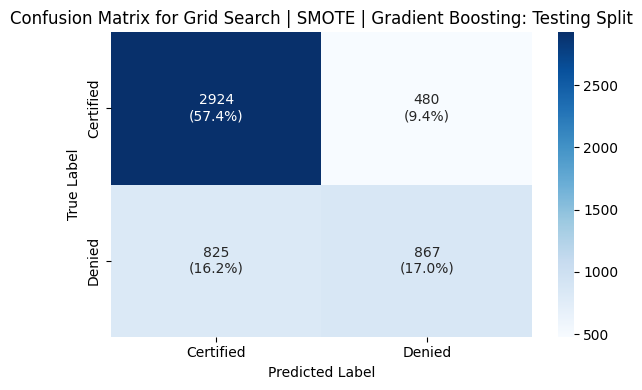

Classification Report for Grid Search | SMOTE | Gradient Boosting: Testing Scores

              precision    recall  f1-score   support

   Certified       0.78      0.86      0.82      3404
      Denied       0.64      0.51      0.57      1692

    accuracy                           0.74      5096
   macro avg       0.71      0.69      0.69      5096
weighted avg       0.73      0.74      0.74      5096



In [ ]:
testing_results = evaluate_model(best_gb_smote_grid, X_test, y_test_enc,
    model_name='Grid Search | SMOTE | Gradient Boosting',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Testing")

In [ ]:
testing_results = evaluate_model(best_gb_smote_grid, X_test, y_test_enc,
    model_name='Grid Search | SMOTE | Gradient Boosting',scores_df=model_val_scores_df,label_encoder=le_under,data_split="Testing")

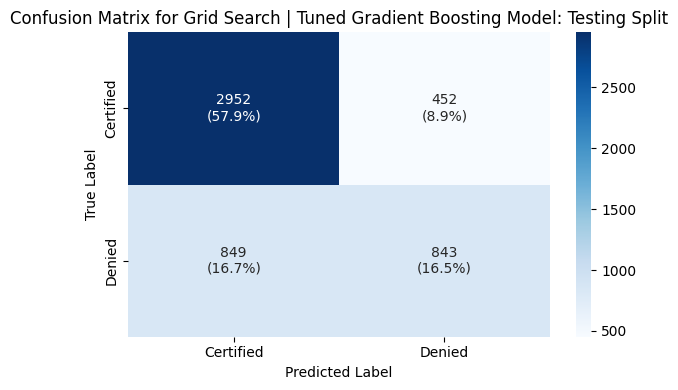

Classification Report for Grid Search | Tuned Gradient Boosting Model: Testing Scores

              precision    recall  f1-score   support

   Certified       0.78      0.87      0.82      3404
      Denied       0.65      0.50      0.56      1692

    accuracy                           0.74      5096
   macro avg       0.71      0.68      0.69      5096
weighted avg       0.73      0.74      0.73      5096



In [ ]:
testing_results = evaluate_model(gb_orig_grid_best, X_test, y_test,
                                 model_name='Grid Search | Tuned Gradient Boosting Model', scores_df=model_val_scores_df, data_split="Testing")

## Actionable Insights & Recommendations

Based on a comprehensive exploratory data analysis of past visa applications and outcomes + insights from the model building, specific applicant characteristics have been identified for recommending to OLFC that most strongly correlate with successful certification.

To enhance the efficiency, fairness, and impact of visa screening, we recommend to OLFC department prioritizing applicants who align with the following high-predictive indicators:

**Education Level**

Applicants holding Master’s degrees or Doctorates exhibit the highest visa approval rates, reaching up to 86%.

In contrast, those with only high school education face a significantly higher risk of denial.

**Prior Work Experience**

Candidates with documented previous job experience are approved at a rate of nearly 75%, making this a strong positive signal.

Applicants without experience show a much more uncertain outcome, with approvals close to 50%.

**Continent of Origin**

European nationals consistently show the highest likelihood of visa certification (~81%), especially when coupled with strong education and experience.

Asian applicants follow with high-moderate approval rates (~66%), indicating some regional variation.

**U.S. Region of Intended Employment**

Applications tied to jobs in the Midwest or Southern U.S. regions have historically seen approval rates over 70%, particularly when targeting experienced hires.

The Northeast and Western regions tend to show more balanced outcomes, often supporting candidates without prior experience.



### **Ideal Applicant Profile for Prioritized Certification**

Based on the above, OFLC may consider focusing its screening and fast-tracking efforts on applicants who meet the following profile:

- Hold at least a Master’s degree

- Have prior professional job experience

- Are nationals of European or Asian countries

- Are applying for positions located in the Midwest or Southern U.S.



In [ ]:
## Converting the google colab notebook to HTML
!jupyter nbconvert --to html content/drive/MyDrive/Masters_2025_AI_ML/content/AdvancedMachineLearning_EasyVisa_Assignment_VarunSagarTheegala.ipynb

[NbConvertApp] WARNING | pattern 'content/drive/MyDrive/Masters_2025_AI_ML/content/AdvancedMachineLearning_EasyVisa_Assignment_VarunSagarTheegala.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to

In [5]:
# 1) Install once
%pip install -U nbconvert[webpdf] nbformat

# 2) Convert notebook → report-style PDF (no code cells, outputs kept)
!jupyter nbconvert "AdvancedMachineLearning_EasyVisa_Assignment_VarunSagarTheegala.ipynb" \
  --to webpdf \
  --no-input \
  --output "AdvancedMachineLearning_EasyVisa_Assignment_VarunSagarTheegala.pdf"

SyntaxError: invalid syntax (ipython-input-1046650059.py, line 5)